<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/sala_de_premsa/noticies/2016/202-nova-marca-uoc.jpg", align="left" width="380" height="120">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; text-align:right;">Grado en Ciencia de Datos Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>


# Trabajo Final de Grado: Modelo de *credit score* basado en IA responsable y explicable
## Autor: Manuel Merayo Rabanal
    

---
## Descripción del proyecto a desarrollar

El objetivo del TFG es desarrollar un modelo de *machine learning* (ML) para evaluar la solvencia de los solicitantes de crédito, también conocidos como modelos de *credit score*, siguiendo las premisas de la IA Responsable, poniendo especial énfasis en la explicabilidad del modelo. Esto último enlaza el proyecto con el concepto de IA Explicable (XAI por sus siglas en inglés).

En este Notebook, se va a desarrollar todo el código Python necesario para realizar las diferentes fases técnicas del proyecto. Estas incluyen las siguientes tareas.

- Análisis exploratorio de datos (EDA)
- Ingeniería de características y preparación del dataset para su procesamiento.
- Selección e implementación del modelo de ML para *credit score*.
- Implementación de la explicabilidad para facilitar su interpretabilidad.
    
El conjunto de datos seleccionado para realizar el proyecto es *Home Credit Default Risk*, que se puede encontrar en el siguiente enlace: https://www.kaggle.com/c/home-credit-default-risk/overview. El conjunto de datos está formado por los siguientes ficheros:

- application_train.csv – Información demográfica y financiera de los clientes que solicitaron un préstamo (incluye la variable objetivo TARGET, donde 1 indica que el cliente incumplió el pago y 0 que no).
- application_test.csv – Mismo formato que application_train.csv, pero sin la columna TARGET (para predicciones).
- bureau.csv – Historial crediticio de los clientes con otras entidades financieras.
- bureau_balance.csv – Estados mensuales de los créditos en bureau.csv.
- previous_application.csv – Información sobre préstamos previos solicitados por los clientes.
- POS_CASH_balance.csv – Información de préstamos en punto de venta y de efectivo.
- installments_payments.csv – Historial de pagos de los clientes en préstamos anteriores.
- credit_card_balance.csv – Datos de comportamiento de tarjetas de crédito anteriores.

Para el desarrollo del proyecto, se generará a partir de los datos de los ficheros anteriores un conjunto de datos con todas aquellas variables predictoras que se puedan considerar relevantes. En relación a los ficheros se ha de tener en cuenta lo siguiente: 

- La base del conjunto de datos que se usará en el modelo son los ficheros *application_train* y *application_test*, ya que contienen variables relacionadas con la solicitud y con el cliente que la realiza.

- Los ficheros *bureau* y *bureau_balance* son ficheros con información de otros créditos del cliente en otras entidades, que permitirán inferir información relevante de su comportamiento crediticio que podrá ser integrada en el conjunto de datos final.

- Los ficheros *previous_application*, *POS_CASH_balance*, *installments_payments* y *credit_card_balance* son ficheros con información de otros créditos del cliente en la entidad, que permitirán inferir información relevante de su comportamiento crediticio que podrá ser integrada en el conjunto de datos final.

Antes de continuar, se han de tener en cuenta que en los ficheros *application_train* y *application_test* se está registrando una solicitud de crédito por cliente. No existen más de dos solicitudes del mismo cliente, y si las hay no existe forma de relacionarlas. Este punto es relevante ya que toda la información recopilada en los ficheros de *bureau* y de solicitudes previas en la misma entidad se relacionan por el identificador del préstamo, que es a su vez el indicador del cliente.

## 1.  Preparación del conjunto de datos

### 1.1. Análisis exploratorio de datos (EDA)

En este primer apartado se realizará la carga de los ficheros del conjunto de datos y se realizará un análisis exploratorio de los mismos. Posteriormente, se generará el conjunto de datos definitivo a partir de los datos de entrenamiento y otros datos relevantes procedentes del resto de ficheros, después de haber realizado las tareas de transformación necesarias: ingeniería de características, tratamiento de nulos, tratamiento de outliers, etc.

En primer lugar, se van a referenciar todas aquellas librerías necesarias para realizar las diferentes tareas del proyecto, y vamos a cargar los ficheros que componen el conjunto de datos.

In [1]:
# Se importan las librerías necesarias para la realización del proyecto
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, r2_score, recall_score, roc_curve, auc, precision_score 
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from huggingface_hub import login
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import joblib
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
import accelerate

c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
# Se cargan los conjuntos de datos con los que trabajar
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_app = pd.read_csv('previous_application.csv')
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')
installments = pd.read_csv('installments_payments.csv')
credit_card = pd.read_csv('credit_card_balance.csv')

Una vez cargados los ficheros, ya se puede realizar el análisis exploratorio de los mismos. En primer lugar, definimos una serie de funciones que servirán de ayuda en el análisis, ya que nos proporcionarán la funcionalidad necesaria para poder graficar características de las variables.

In [4]:
# Se cra una función para pintar las distribuciones de variables en
# formato tarta
def print_pie_chart_by_column(column, df):
    """
    Genera un gráfico de tarta con la distribución
    de los valores de una variable.
    
    Parámetros:
    - column: (str) columna del DataFrame de pandas sobe la que se va a crear el gráfico.
    - df: DataFrame de Pandas.
    """
    # Se crea un dataframe con los valores agrupados
    df_grouped = df.groupby(column)['SK_ID_CURR'].count().reset_index()
    
    # Se establecen las categorías y los porcentajes
    categorias = df_grouped[column]
    conteo = df_grouped['SK_ID_CURR']
    total = sum(conteo)
        
    # Crear etiquetas personalizadas
    etiquetas = ['%s, %1.1f%%' % (cat, (float(pct) / total) * 100) 
                 for cat, pct in zip(categorias, conteo)]

    # Crear el gráfico de pastel
    fig, ax = plt.subplots()
    wedges, texts = ax.pie(conteo, startangle=90, radius=1800)

    # Ajustar las etiquetas para que no se solapen
    for text in texts:
        text.set_fontsize(12)
        text.set_color('black')

    # Añadir leyenda con etiquetas personalizadas
    ax.legend(wedges, etiquetas, title='Categorías', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

    # Asegurar que el gráfico es circular
    ax.axis('equal')
    
    plt.title('Proporción de las categorías de la variable ' + column + '\n\n')
    plt.show()

# Se cra una función para pintar las distribuciones de variables en
# formato gráfico de barras horizontales
def get_hbar_char_by_column(column, df, width, length):
    """
    Genera un gráfico de barras verticales con la distribución
    de los valores de una variable.
    
    Parámetros:
    - column: (str) columna del DataFrame de pandas sobe la que se va a crear el gráfico.
    - df: DataFrame de Pandas.
    - width: (int) tamaño del ancho del gráfico.
    - length: (int) tamaño del largo del gráfico.
    """
    # Se establece el tamaño de la figura
    plt.figure(figsize=(width,length))
    # Se crea el objeto
    sns.countplot(y=df[column], order=df[column].value_counts().index)
    # Se asigna el título
    plt.title('Distribución de la variable ' + column + '\n\n')
    # Se muestra el gráfico
    plt.show()

# Se crea una función para pintar las distribuciones de variables en
# formato gráfico de barras verticales
def get_vbar_char_by_column(column, df, width, length):
    """
    Genera un gráfico de barras horizontales con la distribución
    de los valores de una variable.
    
    Parámetros:
    - column: (str) columna del DataFrame de pandas sobe la que se va a crear el gráfico.
    - df: DataFrame de Pandas.
    - width: (int) tamaño del ancho del gráfico.
    - length: (int) tamaño del largo del gráfico.
    """
    # Se establece el tamaño de la figura
    plt.figure(figsize=(width, length))
    # Se crea el objeto
    sns.countplot(x=column, data=df)
    # Se asigna el título
    plt.title('Distribución de la variable '+ column + '\n\n')
    # Se muestra el gráfico
    plt.show()
    
# Se crea una función para mostrar la distribución de las variables categóricas 
# y su relación con la variable objetivo TARGET
def get_distribution_by_target(column, df, width, lenght, labels_angle):
    """
    Genera un gráfico de barras apiladas en base a la variable objetivo de la distribución
    de los valores de una variable.
    
    Parámetros:
    - column: (str) columna del DataFrame de pandas sobe la que se va a crear el gráfico.
    - df: DataFrame de Pandas.
    - width: (int) tamaño del ancho del gráfico.
    - length: (int) tamaño del largo del gráfico.
    - labels_angle: (int) porcentaje de inclinación de las etiquetas del eje de abcisas.
    """
    # Se crear el gráfico de barras apiladas
    plt.figure(figsize=( width, lenght))
    # Se setean los parámetros del gráfico
    sns.histplot(data=df, x=column, hue='TARGET', multiple='stack', shrink=0.8)
    plt.title('Distribución de la variable categórica '+ column +' y su relación con TARGET')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    # Se ajustan las etiquetas del eje x para que estén en horizontal
    plt.xticks(rotation=labels_angle)
    plt.show()
      
# Se crea una función para dibujar gráficos combinados de barras y líneas
# para mostrar la distribución de variables categóricas y el porcentaje de 
# imapago de cada una de ellas
def get_default_by_category(column, df, width, lenght, labels_angle):
    """
    Genera un gráfico de barras y líneas con la distribución de los valores de una variable 
    y el valor de la tasa de impago por categoría.
    
    Parámetros:
    - column: (str) columna del DataFrame de pandas sobe la que se va a crear el gráfico.
    - df: DataFrame de Pandas.
    - width: (int) tamaño del ancho del gráfico.
    - length: (int) tamaño del largo del gráfico.
    - labels_angle: (int) porcentaje de inclinación de las etiquetas del eje de abcisas.
    """
    grouped = df.groupby(column).agg(
        total_clients=('TARGET', 'count'),
        default_rate=('TARGET', 'mean')  # Promedio de TARGET = tasa de impago
    ).reset_index()

    # Crear la figura y los ejes
    fig, ax1 = plt.subplots(figsize=(width, lenght))
    plt.xticks(rotation=labels_angle)  # Rotar etiquetas si son muchas categorías

    # Gráfico de barras (número de clientes en cada categoría)
    sns.barplot(data=grouped, x=column, y='total_clients', color='blue', ax=ax1)
    ax1.set_ylabel('Número de Clientes', color='blue')
    ax1.set_xlabel(column)
    ax1.tick_params(axis='y', colors='blue')

    # Crear un segundo eje para la tasa de impago (línea)
    ax2 = ax1.twinx()
    #sns.lineplot(data=grouped, x=column, y='default_rate', marker='o', color='red', ax=ax2)
    sns.lineplot(data=grouped, x=range(len(grouped)), y='default_rate', marker='o', color='red', ax=ax2)
    ax2.set_ylabel('Porcentaje de Impago', color='red')
    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylim(0, grouped['default_rate'].max() * 1.2)  # Ajuste del rango
    
    for i, row in grouped.iterrows():
        ax2.text(i, row.default_rate, f"{row['default_rate']:.2%}", color='red', fontsize=10, ha='center', va='bottom')

    # Mostrar el gráfico
    plt.title(f'Número de clientes y Tasa de Impago por {column}')
    plt.show()
    
# Se crea una función comparativa de los valores de una variable por el valor del target
def get_distplot_vs_target(column, df, width, lenght):
    """
    Genera un gráfico comparativo de la distribución de los valores de una variable en función del
    valor de la variable objetivo (TARGET).
    
    Parámetros:
    - column: (str) columna del DataFrame de pandas sobe la que se va a crear el gráfico.
    - df: DataFrame de Pandas.
    - width: (int) tamaño del ancho del gráfico.
    - length: (int) tamaño del largo del gráfico.
    """
    # Se establece el tamaño del gráfico y el estilo
    plt.figure(figsize = (width, lenght))
    sns.set_style('whitegrid')
    
    sns.distplot(df[column][df['TARGET'] == 0].dropna(), 
                  label='No Default', hist = False, color='black')
    sns.distplot(df[column][df['TARGET'] == 1].dropna(), 
                 label='Default', hist = False, color='red')
    plt.xlabel(column)
    plt.ylabel('Probability Density')
    plt.legend(fontsize='medium')
    plt.title("Dist-Plot de {}".format(column))
    plt.show()
    
# Se crea una función para crear un boxplot de una variable
def get_boxplot(column, df, width, lenght):
    """
    Genera un gráfico boxplot con la distribución de los valores de una variable en base a sus cuartiles.
    
    Parámetros:
    - column: (str) columna del DataFrame de pandas sobe la que se va a crear el gráfico.
    - df: DataFrame de Pandas.
    - width: (int) tamaño del ancho del gráfico.
    - length: (int) tamaño del largo del gráfico.
    """
    plt.figure(figsize=(width, lenght))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot de {column}')
    plt.show()
    
# Se crea una función para mostrar un gráfico con la prorpocion de nulos 
# por cada variable
def show_null_values(df, width, lenght, labels_angle):
    """
    Genera un gráfico de barras con el porcentaje de valores nulos en cada columna del dataframe.
    
    Parámetros:
    - df: DataFrame de Pandas.
    - width: (int) tamaño del ancho del gráfico.
    - length: (int) tamaño del largo del gráfico.
    - labels_angle: (int) porcentaje de inclinación de las etiquetas del eje de abcisas.
    """
    # Calcula el porcentaje de valores nulos por columna
    porcentaje_nulos = df.isnull().mean() * 100
    
    # Muestra el porcentaje de valores nulos de manera gráfica
    porcentaje_nulos.plot(kind='bar', figsize=(width, lenght), color='blue')
    plt.title('Porcentaje de Valores Nulos por Columna')
    plt.xlabel('Columnas')
    plt.ylabel('Porcentaje de Valores Nulos (%)')
    plt.xticks(rotation=labels_angle)
    plt.show()

# Se crea una función para mostrar diagramas de dispersión
def get_scatter_plot_by_column(df, variable, target_variable=None):
    """
    Genera un diagrama de dispersión para una sola variable (opcionalmente contra una variable objetivo).

    Parámetros:
    - df: DataFrame de Pandas.
    - variable: (str) Nombre de la variable independiente (eje x).
    - target_variable: (str, opcional) Nombre de la variable dependiente (eje y). Si es None, se usa el índice.
    """
    if variable not in df.columns:
        raise ValueError(f"La variable '{variable}' no existe en el DataFrame.")

    if target_variable and target_variable not in df.columns:
        raise ValueError(f"La variable objetivo '{target_variable}' no existe en el DataFrame.")

    plt.figure(figsize=(6, 4))
    if target_variable:
        plt.scatter(df[variable], df[target_variable], alpha=0.6, edgecolors='k')
        plt.xlabel(variable)
        plt.ylabel(target_variable)
        plt.title(f'Diagrama de Dispersión: {variable} vs {target_variable}')
    else:
        plt.scatter(range(len(df)), df[variable], alpha=0.6, edgecolors='k')
        plt.xlabel('Índice')
        plt.ylabel(variable)
        plt.title(f'Diagrama de Dispersión: {variable}')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Se crea una función para obtenerinformación sobre la distribución de 
# las varaibles de un dataframe
def get_variable_distribution(df, variable, width, lenght, labels_angle):
    """
    Muestra la distribución de una variable, su conteo y porcentaje, y dibuja un diagrama de barras.

    Parámetros:
    - df: DataFrame de Pandas.
    - variable: (str) Nombre de la variable a analizar.
    """
    if variable not in df.columns:
        raise ValueError(f"La variable '{variable}' no existe en el DataFrame.")

    total = len(df)
    distribution = df[variable].value_counts(dropna=False).reset_index()
    distribution.columns = ['Valor', 'Conteo']
    distribution['Porcentaje'] = (distribution['Conteo'] / total * 100).round(2)
    
    print(f"\nDistribución de la variable '{variable}':\n")
    print(distribution.to_string(index=False))
    
    # Gráfico
    plt.figure(figsize=(width, lenght))
    bars = plt.bar(distribution['Valor'].astype(str), distribution['Conteo'], color='blue', edgecolor='black')
    plt.title(f'Distribución de la variable {variable}')
    plt.xlabel(variable)
    plt.ylabel('Número de registros')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=labels_angle)
    
    # Añadir etiquetas de porcentaje encima de las barras
    for bar, pct in zip(bars, distribution['Porcentaje']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct}%', 
                 ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

Se empieza obteniendo el número de filas y columnas de los diferentes ficheros para hacernos una idea de la volumetría con la que vamos a trabajar.

In [5]:
# Tamaño de los datasets: número de filas, número de columnas
print(f'application_train: {app_train.shape}\napplication_test: {app_test.shape}\n'
      f'bureau:{bureau.shape}\nbureau_balance:{bureau_balance.shape}\n'
      f'previous_app: {previous_app.shape}\ninstallments: {installments.shape}\ncredit_card:{credit_card.shape}')

application_train: (307511, 122)
application_test: (48744, 121)
bureau:(1716428, 17)
bureau_balance:(27299925, 3)
previous_app: (1670214, 37)
installments: (13605401, 8)
credit_card:(3840312, 23)


Se puede ver que los ficheros *applicattion* tienen 121 atributos (el de entrenamiento tiene 1 atributo más por la variable dependiente). El resto tienen entre 3 (*bureau_balance*) y 37 (*previous_app*) atributos. El fichero con mayor número de registros es el *bureau_balance* con 27299925, y el que menos registros tiene es el fichero *application_test* con 48744.

A continuación, se analizarán los ficheros y se adaptan para para prepararlos de cara a las siguientes fases necesarias para obtener el conjunto de datos definitivo a utilizar en el proyecto. Antes, se configuran ciertas opciones para facilitar la visualización de los resultados obtenidos en las diferentes ejecuciones.

In [7]:
# Se setean los parámetros de visualización de pandas para que muestre todas las columnas y todas las filas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Se configura la salida de la celda para que no muestre scroll
from IPython.core.display import display, HTML
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

#### application

Se inicia el análisis por los ficheros de *application*. Para simplificar el tratamiento, se va a analizar solo el *application_train*, que además tiene la variable *TARGET*. Este fichero es la base del conjunto de datos que se va a usar para entrenar el modelo, por lo que antes de iniciar ningún proceso de análisis, limpieza o ingeniería de características, se va a comprobar si el conjunto está balanceado, y si no lo está, se tendrá que tener en cuenta a la hora de montar el conjunto de datos definitivo, para que el desarrollo del modelo no esté condicionado por esta circunstancia.

Se comprueba la distribución de la variable target para ver la proporción entre registros con mal comportamiento y registros con buen comportamiento.


Distribución de la variable 'TARGET':

 Valor  Conteo  Porcentaje
     0  282686       91.93
     1   24825        8.07


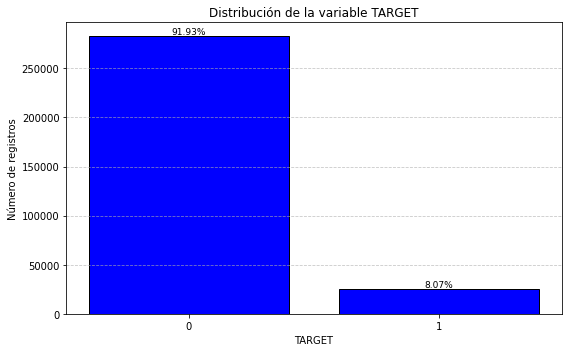

In [7]:
# Se muestra la distribución de la variable TARGET
get_variable_distribution(app_train, 'TARGET', 8, 5, 0)

Como se puede apreciar, solo el 8% de los registros han sido marcados como mal pagadores. Una de las opciones para optimizar el proceso de clasificación es el balancear el conjunto de datos para evitar que el modelo tienda a predecir la clase mayoritaria, es decir, que el cliente es buen pagador. Para realizar el proceso de balanceo se pueden usar diferentes técnicas:

- Submuestreo (Under-sampling): Reducir el número de muestras de la clase mayoritaria.

- Sobremuestreo (Over-sampling): Aumentar el número de muestras de la clase minoritaria. Esto se puede lograr mediante diferentes técnicas, como SMOTE (Synthetic Minority Over-sampling Technique) que permite generar nuevas muestras sintéticas de la clase minoritaria.
- Combinación de ambas técnicas anteriores: Se reduce por un lado el número de registros de la clase mayoritaria y se aumenta el número de registros de la clase minoritaria.

Cuando llegue el momento de balancear el conjunto de datos se seleccionará la técnica que mejor se ajuste en base a las características del mismo y de las necesidades del proyecto. A continuación, se continua con el análisis exploratorio.

En primer lugar, se muestran los primeros 5 registros para ver la apariencia de los datos, así como el número de filas y columnas y el número de registros duplicados.

In [8]:
# Primeras 5 filas del dataframe application_train
app_train.head(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [9]:
# Se muestra el número de registros y columnas
print("Dimensiones del fichero: " + str(app_train.shape))
# Se muestra el número de registros duplicados
print("Número de registros duplicados: " + str(app_train.shape[0] - app_train.duplicated().shape[0]))

Dimensiones del fichero: (307511, 122)
Número de registros duplicados: 0


Se puede observar que tiene tanto atributos numéricos como atributos categóricos. Los valores categóricos tendrán que ser tratados para que puedan ser procesados por el modelo mediante *One Hot Encoding*, por ejemplo. Además, los atributos de tiempo vienen en días negativos, por lo que habrá que pasarlos a una escala más interpretable. También existen variables dicotómicas en formato texto (Y/N) que tendrán que ser convertidas a variables dicotómicas numéricas con *label encoding*, u otra técnica similar. Se puede apreciar la presencia de muchos atributos con valor nulo, si es una constante en el dataset habrá que prestarle especial atención.

Por otro lado, como ya se mencionó anteriormente, se cuenta con 307511 registros y 122 atributos, de los cuales uno es la variable objetivo y otro es el identificador del préstamo, por lo que son 120 variables predictoras originales. Además, se confirma que no existen registros duplicados en el conjunto de datos.

Se muestra a continuación la información del fichero y de sus columnas.

In [10]:
# Información del dataframe application_train
app_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

En su mayoría, las variables que componen el fichero son numéricas, pero existen 16 variables categóricas que habrá que tratar. Se muestran a continuación los estadísticos básicos de las variables numéricas, y la descripción de las variables categóricas del fichero application_train.

In [11]:
# Estadisticos básicos de las variables númericas
app_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [12]:
# Descripción de las variables categóricas
app_train.describe(include="object")

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
count              307511      307511       307511          307511   
unique                  2           3            2               2   
top            Cash loans           F            N               Y   
freq               278232      202448       202924          213312   

       NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
count           306219           307511                         307511   
unique               7                8                              5   
top      Unaccompanied          Working  Secondary / secondary special   
freq            248526           158774                         218391   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE OCCUPATION_TYPE  \
count              307511             307511          211120   
unique                  6                  6              18   
top               Married  House / apartment        Laborers   
freq               196432             272868           55186   

       WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE FONDKAPREMONT_MODE  \
count                      307511                  307511              97216   
unique                          7                      58                  4   
top                       TUESDAY  Business Entity Type 3   reg oper account   
freq                        53901                   67992              73830   

        HOUSETYPE_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  
count           153214             151170              161756  
unique               3                  7                   2  
top     block of flats              Panel                  No  
freq            150503              66040              159428

Por los valores de la variable *TARGET*, se confirma lo que ya se vio anteriormente, que el conjunto de datos está muy desbalanceado. Esto puede ser un problema para el rendimiento del modelo, ya que habrá que buscar la mejor forma de conseguir el equilibrio entre los registros identificados como mal pagadores y buenos pagadores.

Se ven en algunas variables desequilibrios en su distribución que pueden traducirse en *outliers*. Cuando llegue el momento se analizarán estos datos para analizar cuál es la mejor estrategia para tratarlos. Tampoco se sabe el porcentaje de valores nulos de las diferentes variables por lo que, en base a su proporción, quizás no sean un problema porque la mejor solución es eliminarlas del modelo.

Se pueden ver otras características interesantes, como que la mayoría son solicitudes de préstamos, que en su mayoría son solicitados por mujeres, que el solicitante en la mayoría de las ocasiones va solo, que el justificante de los ingresos de la mayoría es el trabajo, etc.

A continuación, se comprueban los valores nulos en los diferentes atributos. En función de los registros con valores nulos de cada variable se puede considerar si se les ha de tener en cuenta o no. En el caso de ser tenidos en cuenta se tendrá que decidir qué hacer con los nulos.

In [13]:
# Registros nulos por cada una de las variables
null_values = app_train.isnull().sum().sort_values()
# Se muestran los resultados obtenidos
print(null_values.to_string())

SK_ID_CURR                           0
HOUR_APPR_PROCESS_START              0
REG_REGION_NOT_WORK_REGION           0
LIVE_REGION_NOT_WORK_REGION          0
REG_CITY_NOT_LIVE_CITY               0
REG_CITY_NOT_WORK_CITY               0
LIVE_CITY_NOT_WORK_CITY              0
ORGANIZATION_TYPE                    0
FLAG_DOCUMENT_21                     0
FLAG_DOCUMENT_20                     0
FLAG_DOCUMENT_19                     0
FLAG_DOCUMENT_18                     0
FLAG_DOCUMENT_17                     0
FLAG_DOCUMENT_16                     0
FLAG_DOCUMENT_15                     0
FLAG_DOCUMENT_14                     0
FLAG_DOCUMENT_13                     0
FLAG_DOCUMENT_12                     0
FLAG_DOCUMENT_11                     0
FLAG_DOCUMENT_10                     0
FLAG_DOCUMENT_9                      0
FLAG_DOCUMENT_8                      0
FLAG_DOCUMENT_7                      0
FLAG_DOCUMENT_6                      0
FLAG_DOCUMENT_5                      0
FLAG_DOCUMENT_4          

Se observa que en algunos casos el número de valores nulos es muy alto, por lo tanto se va a calcular el porcentaje de valores nulos por columna y comprobar que variables son las que cuentan con más valores de este tipo.

In [14]:
# Se calcula el porcentaje de valores nulos por cada una de las variables
print(app_train.isnull().sum().sort_values() * 100 / len(app_train))

SK_ID_CURR                       0.000000
HOUR_APPR_PROCESS_START          0.000000
REG_REGION_NOT_WORK_REGION       0.000000
LIVE_REGION_NOT_WORK_REGION      0.000000
REG_CITY_NOT_LIVE_CITY           0.000000
REG_CITY_NOT_WORK_CITY           0.000000
LIVE_CITY_NOT_WORK_CITY          0.000000
ORGANIZATION_TYPE                0.000000
FLAG_DOCUMENT_21                 0.000000
FLAG_DOCUMENT_20                 0.000000
FLAG_DOCUMENT_19                 0.000000
FLAG_DOCUMENT_18                 0.000000
FLAG_DOCUMENT_17                 0.000000
FLAG_DOCUMENT_16                 0.000000
FLAG_DOCUMENT_15                 0.000000
FLAG_DOCUMENT_14                 0.000000
FLAG_DOCUMENT_13                 0.000000
FLAG_DOCUMENT_12                 0.000000
FLAG_DOCUMENT_11                 0.000000
FLAG_DOCUMENT_10                 0.000000
FLAG_DOCUMENT_9                  0.000000
FLAG_DOCUMENT_8                  0.000000
FLAG_DOCUMENT_7                  0.000000
FLAG_DOCUMENT_6                  0

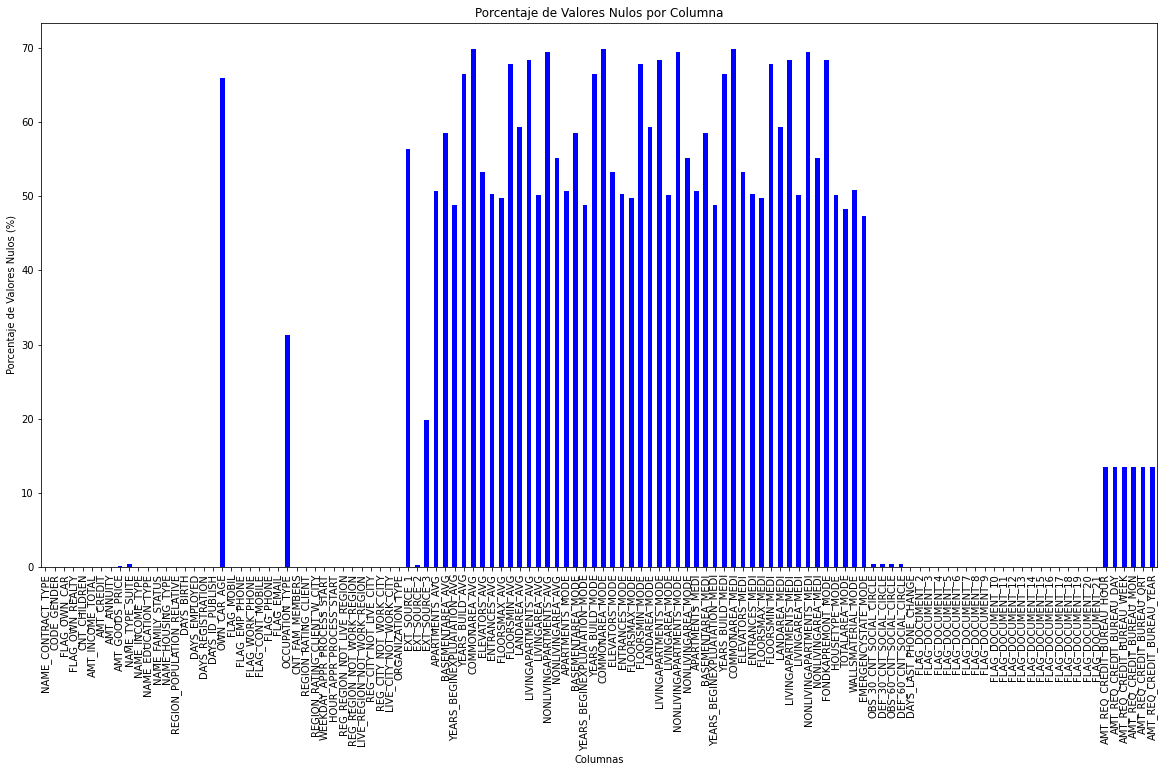

In [15]:
# Se muestran los valores nulos por columna
df_null = app_train.drop(columns=['SK_ID_CURR', 'TARGET'])
show_null_values(df_null, 20, 10, 90)

Se puede ver que existen varios atributos con porcentajes de valores nulos elevados, llegando a tener variables con hasta un 70% de valores nulos. Se pueden eliminar aquellas variables con unos porcentajes de valores a partir de un umbral, por ejemplo, del 50%, si se ve que no aportan nada. En otros casos, se puede analizar si es conveniente conservar la variable analizando la técnica de imputación. 

A la hora de realizar la imputación de valores se ha de ser cuidadoso. Si la variable tiene muchos valores nulos, dependiendo de la forma de imputación se puede crear una variable que no sea representativa o que enmascare la variable objetivo, lo que se puede traducir en un problema de *data leakage*, que se ha de prevenir para garantizar la robustez y eficiencia del modelo.

Dentro del proceso de análisis exploratorio, se va a proceder a eliminar las variables con un porcentaje de nulos por encima del 40%, ya que imputar valores en esas variables seria arriesgado por la aparición de *data leakage*. Solo se va a conservar de ese grupo de variables la variable EXT_SOURCE_1, que es una nota de score externa que puede ser relevante a la hora de identificar mal pagadores.

En lo que respecta al resto de variables del conjunto de datos, se va a proceder a realizar una imputación de los valores nulos, que será diferente en función del tipo de variable. Por otro lado, y buscando evitar la aparición de sesgos siguiendo las premisas de la IA responsable, se va a eliminar del modelo la variable CODE_GENDER. El motivo es que observando la distribución de las variables las solicitudes realizadas por mujeres son el doble que las realizadas por hombres, lo que puede llevar a la aparición de sesgos de género. Evidentemente, estos sesgos se pueden mitigar, por ejemplo, balanceando el conjunto de datos, pero en este caso se prefiere eliminar la variable y así eliminar el riesgo de aparición de un sesgo de este tipo.

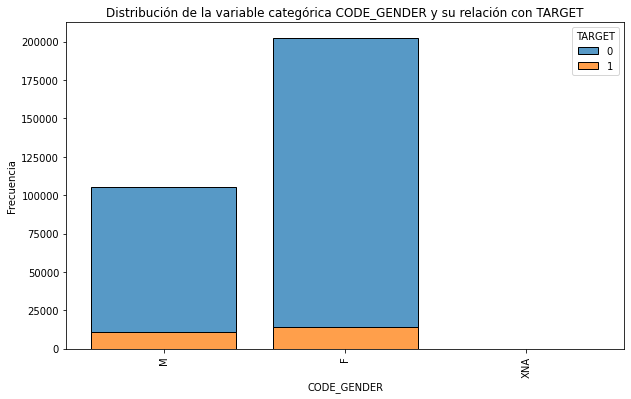

In [16]:
# Se muestra la distribución de la variable CODE_GENDER
get_distribution_by_target('CODE_GENDER', app_train, 10, 6, 90)

La lógica que se va a seguir para la imputación de valores es la siguiente:

- Variables numéricas continuas: Mediana para los valores con muchos nulos. Para los valores de score (EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3), al ser scores externos es mejor buscar valores que mantengan la correlación entre las variables.

- Variables categóricas: Valor más frecuente (moda).

- Variables de recuento: Asignar valor cero (Se intenta indicar que no hubo registros).

A continuación, se eliminan las variables con más del 40% de sus registros a nulo y se imputan los valores nulos a aquellas variables que se quieren conservar.

In [17]:
# Se eliminan las variables de moda y mediana más la variable CODE_GENDER
# Lista de columnas a eliminar
columns_to_drop = ['EMERGENCYSTATE_MODE',            
'TOTALAREA_MODE',                 
'YEARS_BEGINEXPLUATATION_MODE',
'YEARS_BEGINEXPLUATATION_AVG',  
'YEARS_BEGINEXPLUATATION_MEDI',   
'FLOORSMAX_AVG',                  
'FLOORSMAX_MODE',                 
'FLOORSMAX_MEDI',                 
'HOUSETYPE_MODE',                 
'LIVINGAREA_AVG',                 
'LIVINGAREA_MODE',                
'LIVINGAREA_MEDI',                
'ENTRANCES_AVG',                  
'ENTRANCES_MODE',                 
'ENTRANCES_MEDI',                
'APARTMENTS_MODE',                
'APARTMENTS_AVG',                 
'APARTMENTS_MEDI',                
'WALLSMATERIAL_MODE',             
'ELEVATORS_AVG',                  
'ELEVATORS_MEDI',                 
'ELEVATORS_MODE',                 
'NONLIVINGAREA_MEDI',             
'NONLIVINGAREA_MODE',             
'NONLIVINGAREA_AVG',                              
'BASEMENTAREA_AVG',               
'BASEMENTAREA_MEDI',              
'BASEMENTAREA_MODE',              
'LANDAREA_AVG',                   
'LANDAREA_MODE',                  
'LANDAREA_MEDI',                  
'OWN_CAR_AGE',                    
'YEARS_BUILD_MEDI',               
'YEARS_BUILD_AVG',               
'YEARS_BUILD_MODE',               
'FLOORSMIN_MODE',                 
'FLOORSMIN_AVG',                  
'FLOORSMIN_MEDI',                 
'LIVINGAPARTMENTS_AVG',           
'LIVINGAPARTMENTS_MEDI',          
'LIVINGAPARTMENTS_MODE',          
'FONDKAPREMONT_MODE',             
'NONLIVINGAPARTMENTS_MODE',       
'NONLIVINGAPARTMENTS_MEDI',       
'NONLIVINGAPARTMENTS_AVG',        
'COMMONAREA_MEDI',                
'COMMONAREA_MODE',                
'COMMONAREA_AVG',
'CODE_GENDER']

# Se eliminan las columnas del DataFrame
app_train = app_train.drop(columns=columns_to_drop)

Se imputan los valores nulos en función de su tipo.

In [18]:
# Imputación de variables numéricas con la mediana
num_vars_median = [
    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE']

# Recorremos las variables e imputamos en base a si son buenos o malos pagadores
for var in num_vars_median:
    # Calcular la mediana separada por clases
    median_0 = app_train[app_train['TARGET'] == 0][var].median()
    median_1 = app_train[app_train['TARGET'] == 1][var].median()
    
    # Imputar según el TARGET
    app_train.loc[(app_train[var].isnull()) & (app_train['TARGET'] == 0), var] = median_0
    app_train.loc[(app_train[var].isnull()) & (app_train['TARGET'] == 1), var] = median_1

In [19]:
# Imputación con KNN para las variables EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3
knn_imputer = KNNImputer(n_neighbors=50, weights='uniform')

# Variables a imputar con KNN
knn_vars = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Aplicar KNN Imputer
app_train[knn_vars] = knn_imputer.fit_transform(app_train[knn_vars])

In [20]:
# Imputación de variables categóricas con la moda (valor más repetido)
cat_vars_mode = [
    'NAME_TYPE_SUITE', 'OCCUPATION_TYPE']

# Recorremos las variables e imputamos en base a si son buenos o malos pagadores
for var in cat_vars_mode:
    # Calcular la mediana separada por clases
    mode_0 = app_train[app_train['TARGET'] == 0][var].mode().iloc[0]
    mode_1 = app_train[app_train['TARGET'] == 1][var].mode().iloc[0]
    
    # Imputar según el TARGET
    app_train.loc[(app_train[var].isnull()) & (app_train['TARGET'] == 0), var] = mode_0
    app_train.loc[(app_train[var].isnull()) & (app_train['TARGET'] == 1), var] = mode_1

In [21]:
# Imputación de variables de recuento con 0
count_vars = [
    'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_FAM_MEMBERS'
]

# Se realiza la asignación
app_train[count_vars] = app_train[count_vars].fillna(0)

Se comprueba que no hay valores nulos en las variables del conjunto de datos.

In [22]:
# Se muestra de nuevo el porcentaje de valores nulos por cada una de las variables
print(app_train.isnull().sum().sort_values() * 100 / len(app_train))

SK_ID_CURR                     0.0
FLAG_DOCUMENT_6                0.0
FLAG_DOCUMENT_5                0.0
FLAG_DOCUMENT_4                0.0
FLAG_DOCUMENT_3                0.0
FLAG_DOCUMENT_2                0.0
DAYS_LAST_PHONE_CHANGE         0.0
FLAG_DOCUMENT_7                0.0
DEF_60_CNT_SOCIAL_CIRCLE       0.0
DEF_30_CNT_SOCIAL_CIRCLE       0.0
OBS_30_CNT_SOCIAL_CIRCLE       0.0
EXT_SOURCE_3                   0.0
EXT_SOURCE_2                   0.0
EXT_SOURCE_1                   0.0
ORGANIZATION_TYPE              0.0
OBS_60_CNT_SOCIAL_CIRCLE       0.0
FLAG_DOCUMENT_8                0.0
FLAG_DOCUMENT_9                0.0
FLAG_DOCUMENT_10               0.0
AMT_REQ_CREDIT_BUREAU_MON      0.0
AMT_REQ_CREDIT_BUREAU_WEEK     0.0
AMT_REQ_CREDIT_BUREAU_DAY      0.0
AMT_REQ_CREDIT_BUREAU_HOUR     0.0
FLAG_DOCUMENT_21               0.0
FLAG_DOCUMENT_20               0.0
FLAG_DOCUMENT_19               0.0
FLAG_DOCUMENT_18               0.0
FLAG_DOCUMENT_17               0.0
FLAG_DOCUMENT_16    

Centrando la atención en las variables categóricas, se va a comprobar que valores posibles tienen y a mostrarlos para poder analizar que procesos de transformación y/o limpieza han de ser aplicados. En este punto es importante identificar todas las variables categóricas, independientemente de que el valor almacenado sea numérico o texto. Por ejemplo, en el conjunto de datos existen dos variables llamadas REGION_RATING_CLIENT y REGION_RATING_CLIENT_W_CITY. Estas variables indican el riesgo de impago de las ciudades y regiones donde viven los clientes, siendo sus posibles valores los siguientes:

- 1: riesgo bajo
- 2: riesgo medio
- 3: riesgo alto

Por lo tanto, se tendrá que tratar a estas variables como categóricas, no como variables numéricas.

In [23]:
# Se convierten las variables REGION_RATING_CLIENT y REGION_RATING_CLIENT_W_CITY a categóricas
app_train['REGION_RATING_CLIENT'] = app_train['REGION_RATING_CLIENT'].astype('object')
app_train['REGION_RATING_CLIENT_W_CITY'] = app_train['REGION_RATING_CLIENT_W_CITY'].astype('object')

# Establecemos el conjunto de variables categóricas
# obteniendo las variables object
categorical_variables = app_train.select_dtypes(include=["object"]).columns.tolist()

# Recorremos los valores únicos de cada variable categórica
for column in categorical_variables:
    print(f'Nombre de la columna: {column}. Número de valores distintos:{len(app_train[column].unique())}')

Nombre de la columna: NAME_CONTRACT_TYPE. Número de valores distintos:2
Nombre de la columna: FLAG_OWN_CAR. Número de valores distintos:2
Nombre de la columna: FLAG_OWN_REALTY. Número de valores distintos:2
Nombre de la columna: NAME_TYPE_SUITE. Número de valores distintos:7
Nombre de la columna: NAME_INCOME_TYPE. Número de valores distintos:8
Nombre de la columna: NAME_EDUCATION_TYPE. Número de valores distintos:5
Nombre de la columna: NAME_FAMILY_STATUS. Número de valores distintos:6
Nombre de la columna: NAME_HOUSING_TYPE. Número de valores distintos:6
Nombre de la columna: OCCUPATION_TYPE. Número de valores distintos:18
Nombre de la columna: REGION_RATING_CLIENT. Número de valores distintos:3
Nombre de la columna: REGION_RATING_CLIENT_W_CITY. Número de valores distintos:3
Nombre de la columna: WEEKDAY_APPR_PROCESS_START. Número de valores distintos:7
Nombre de la columna: ORGANIZATION_TYPE. Número de valores distintos:58


Se puede apreciar que existen varias variables dicotómicas, por lo que se trata de atributos que indican la presencia o no de lo que representa la variable. Estas variables se pueden sustituir por variables numéricas del tipo 1: lo tiene, 0: no lo tiene. Por otro lado, existen dos variables con un gran número de valores distintos: OCCUPATION_TYPE con 19 y ORGANIZATION_TYPE con 58. Se tendrán que reducir buscando crear una categoría alternativa con menos valores. El resto de variables tienen un número coherente de valores distintos, aunque se revisarán para valorar la posibilidad de reducirlos y crear agrupaciones más lógicas. Posteriormente, todas ellas serán convertidas en variables *dummy* utilizando técnicas como *One Hot Encoding* o *Label Encoding*. 

Se muestran a continuación unos gráficos para facilitar la comprensión de la distribución de las variables categóricas. Se muestran por un lado las distribuciones de cada variable en relación con la variable objetivo, tanto en número como en porcentaje.

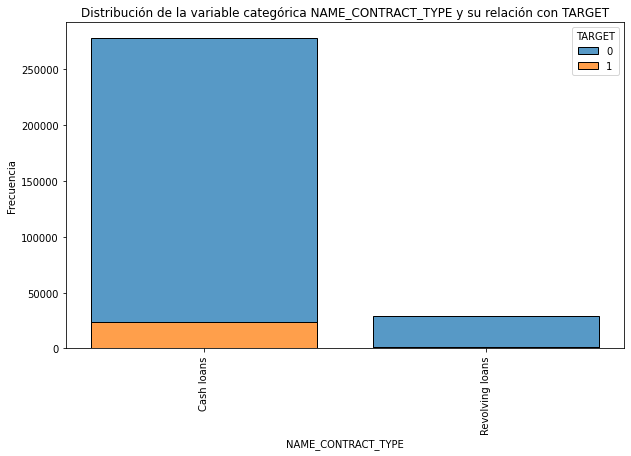

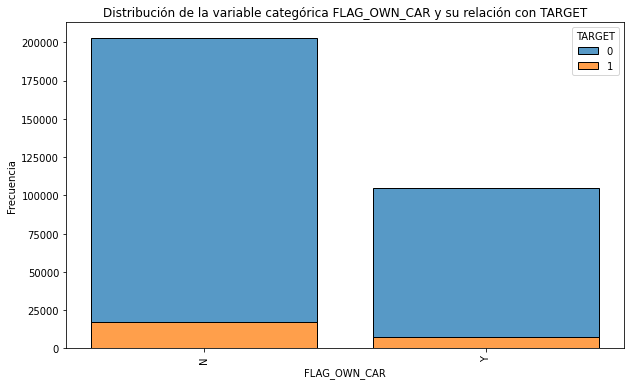

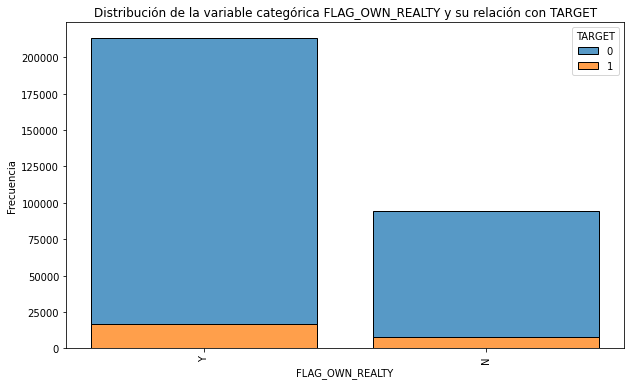

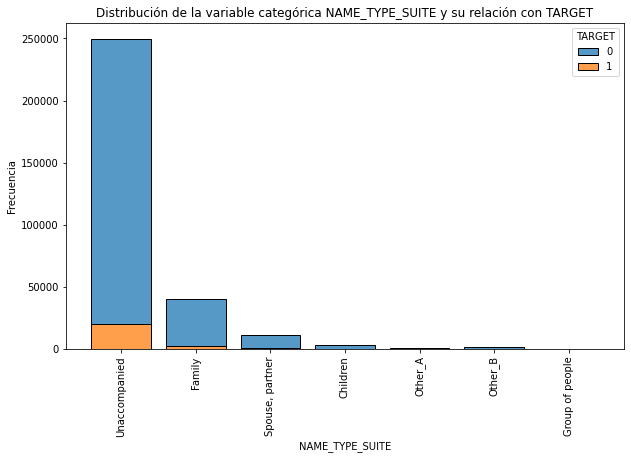

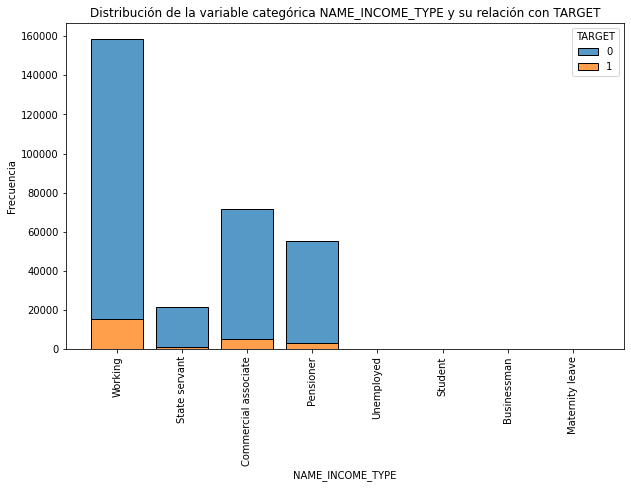

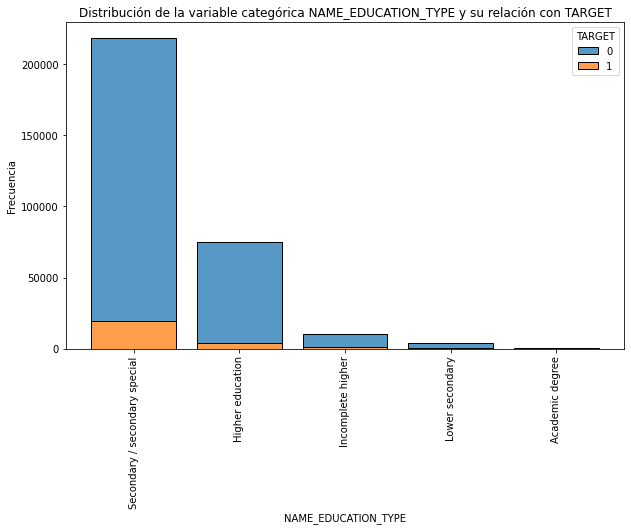

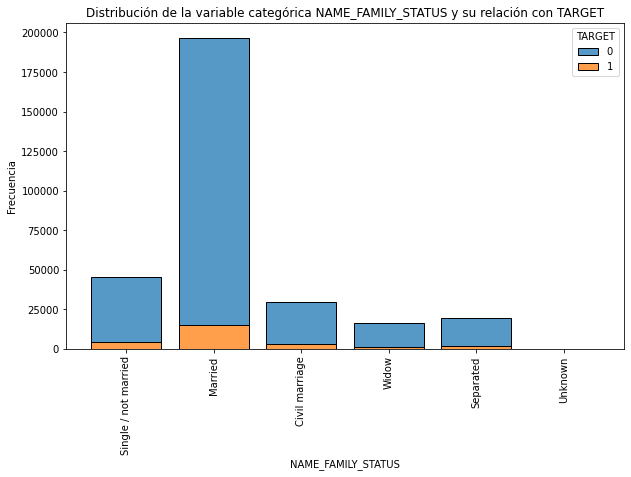

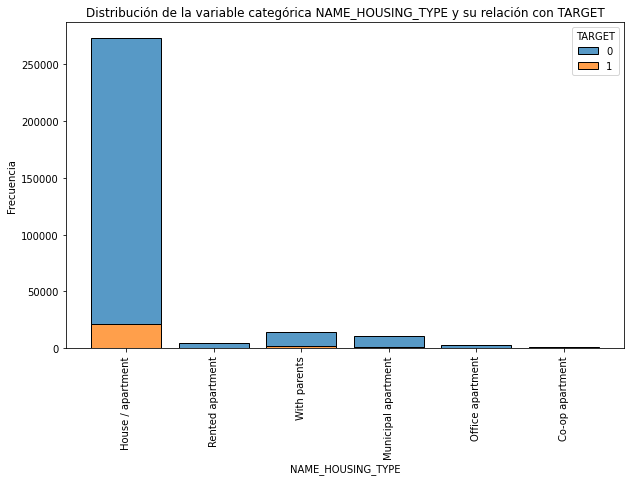

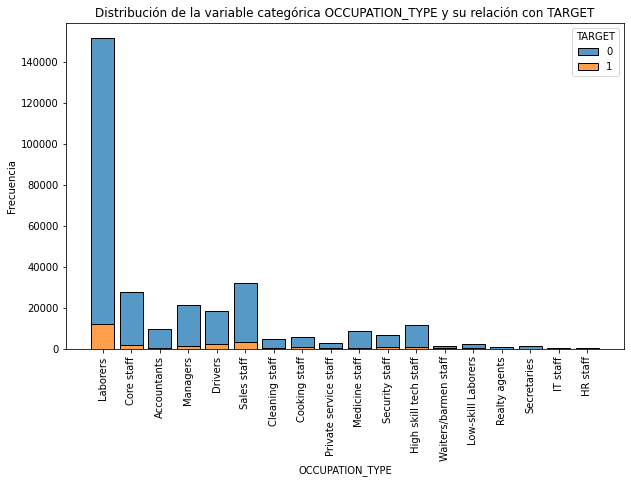

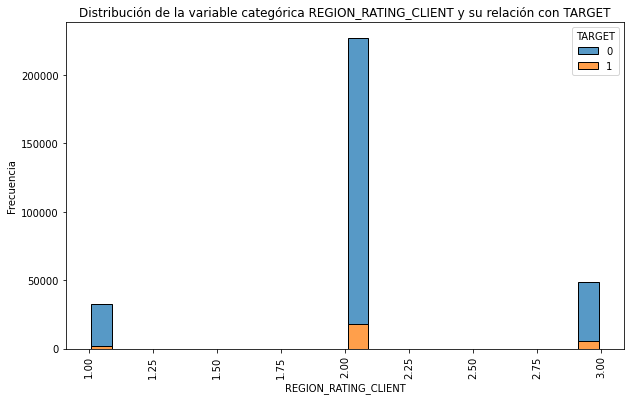

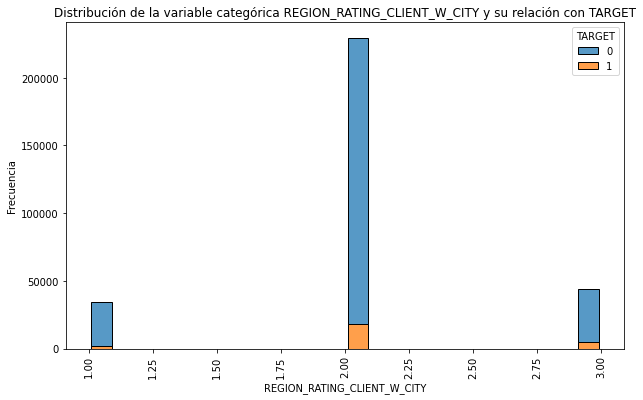

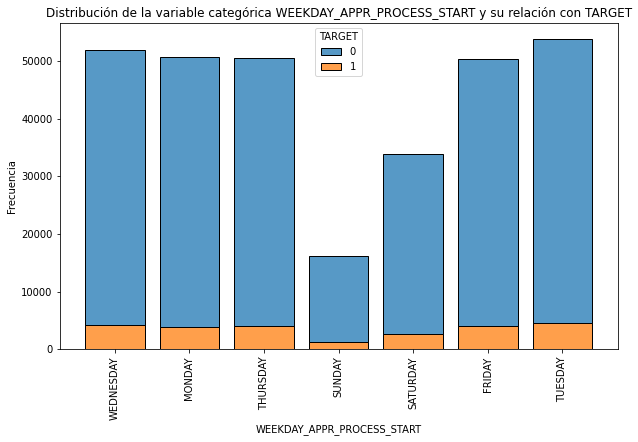

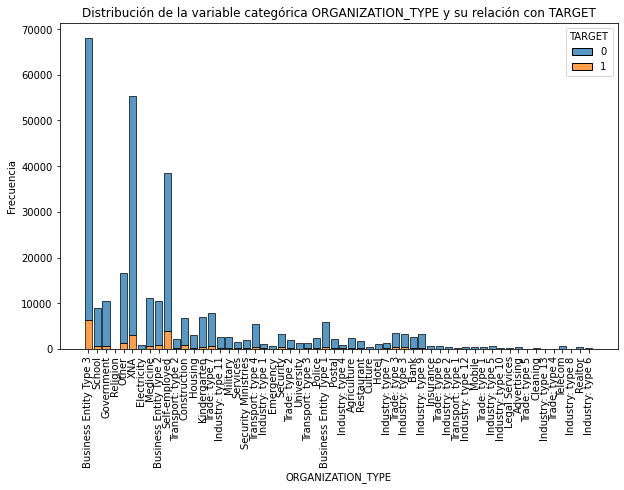

In [24]:
# Recorremos las variables categóricas a excepción de OCCUPATION_TYPE y ORGANIZATION_TYPE
# para mostrar la proporción de sus categorías
for column in categorical_variables:
    get_distribution_by_target(column, app_train, 10, 6, 90)

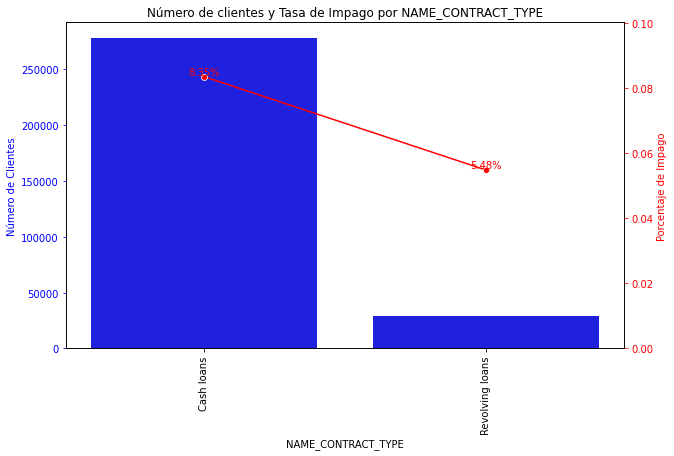

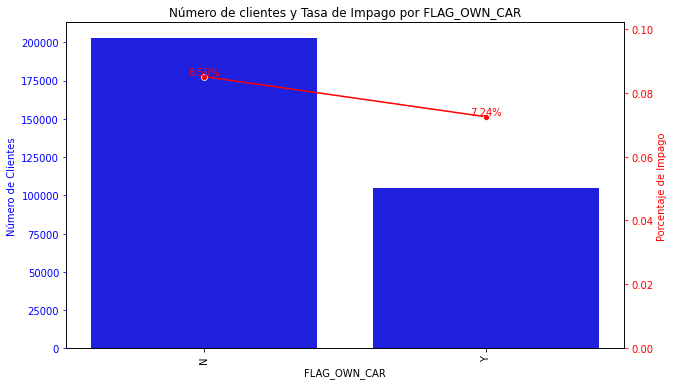

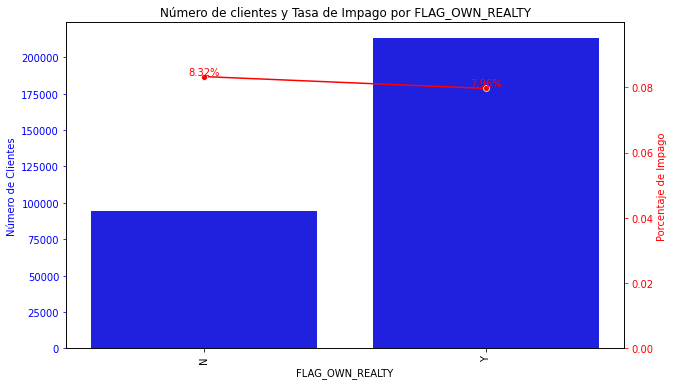

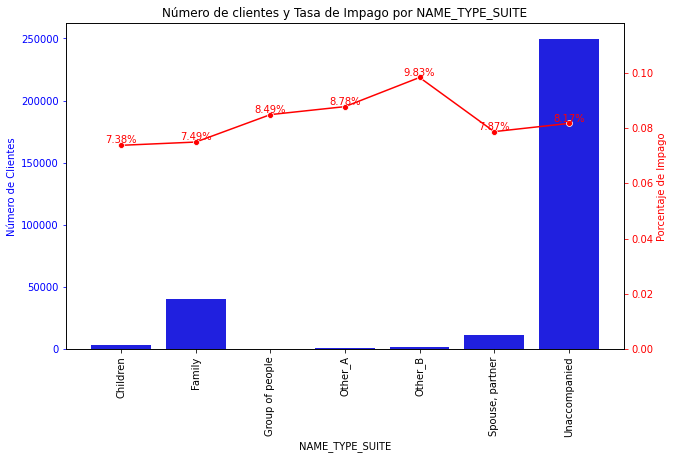

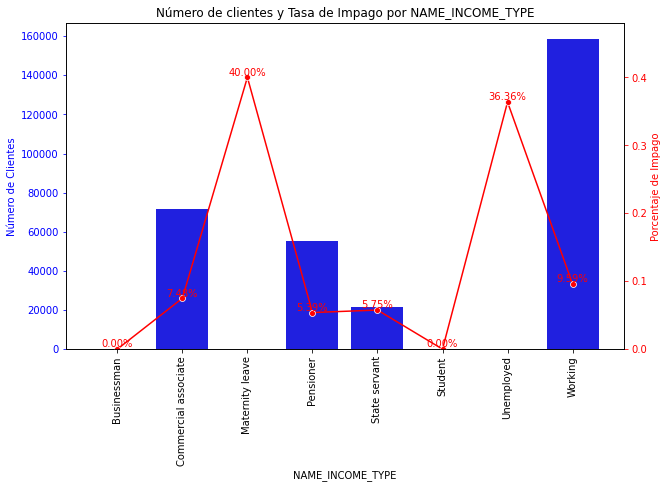

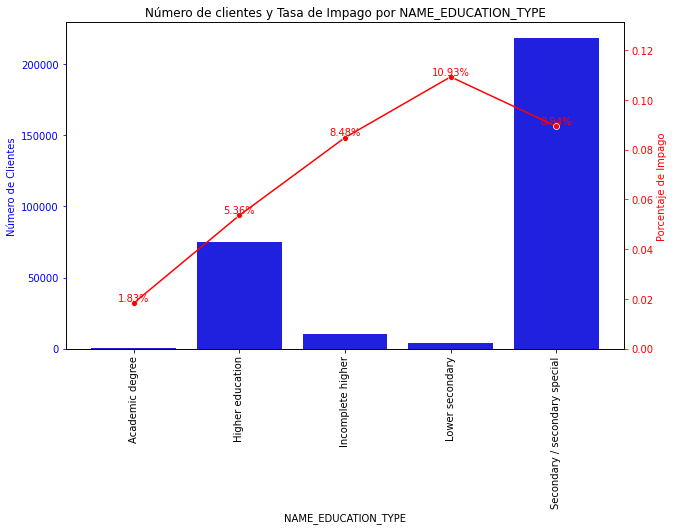

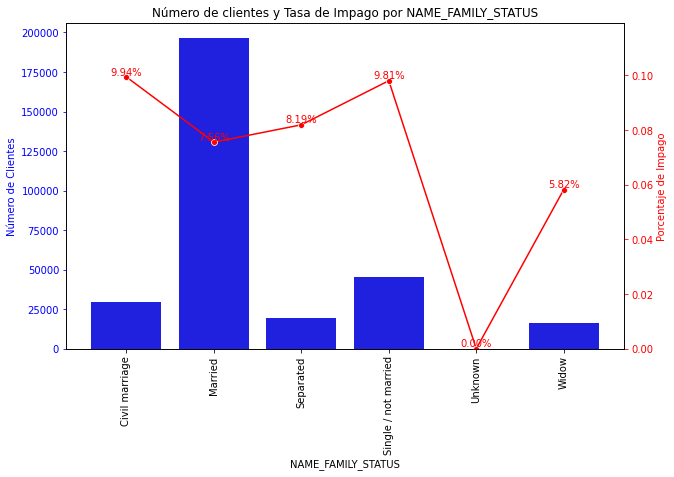

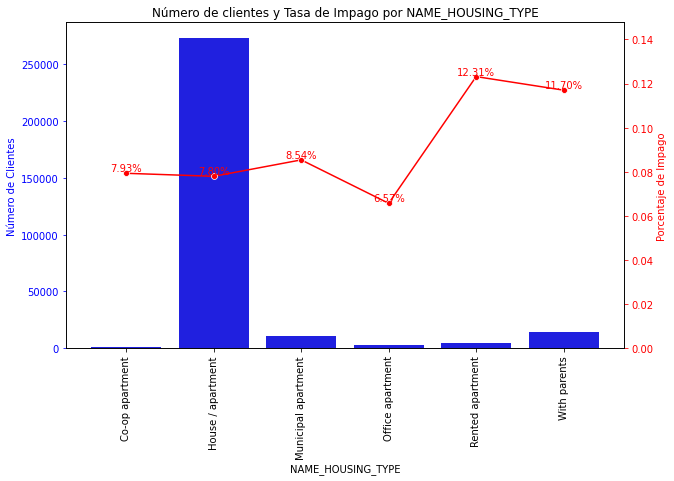

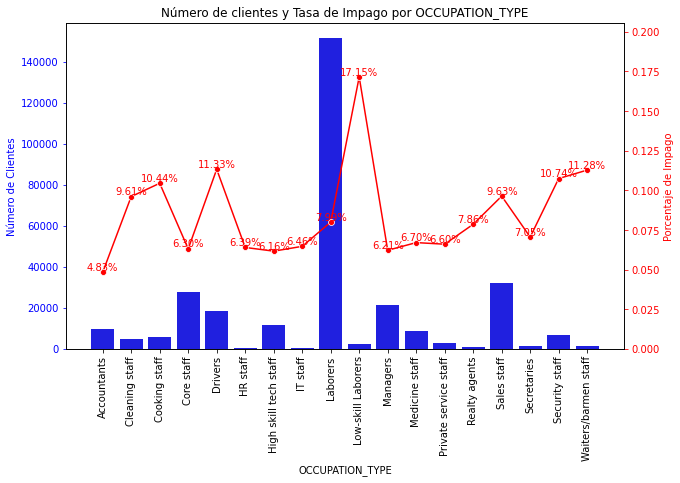

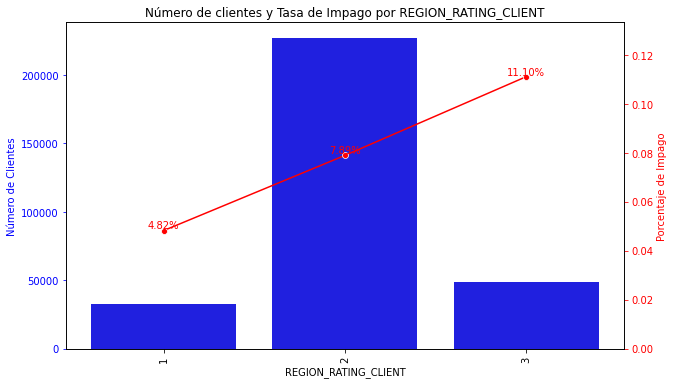

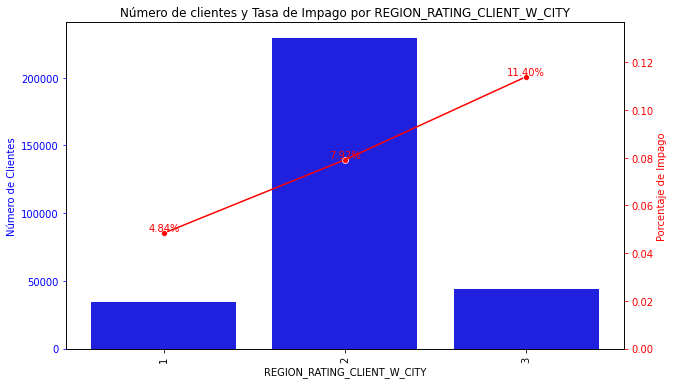

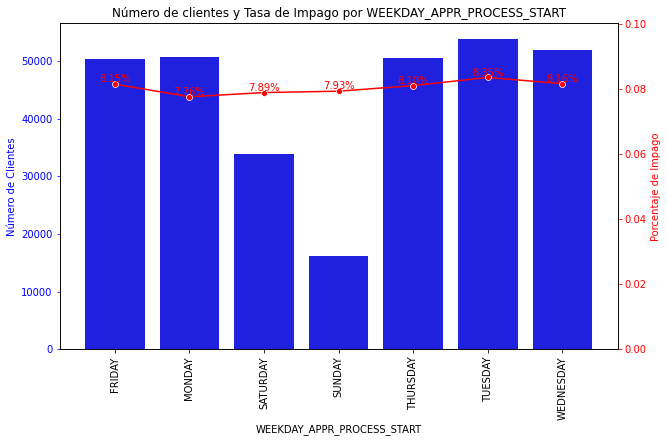

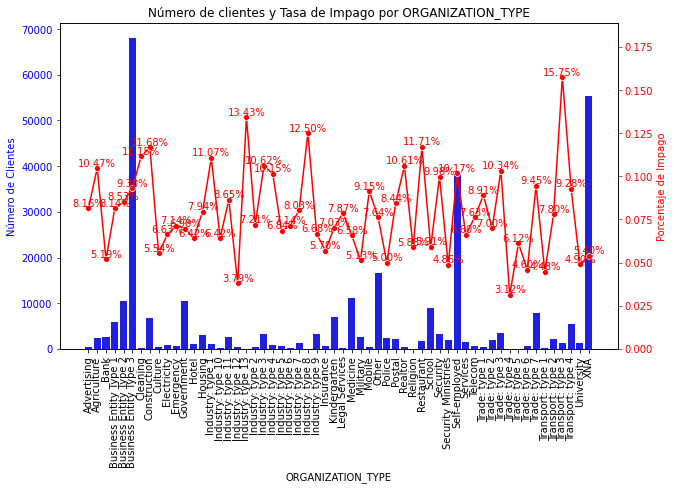

In [25]:
# Recorremos las variables categóricas a excepción de OCCUPATION_TYPE y ORGANIZATION_TYPE
# para mostrar la proporción de sus categorías y el porcentaje de impago de cada una de ellas
for column in categorical_variables:
    get_default_by_category(column, app_train, 10, 6, 90)

Se pueden ver algunos puntos interesantes. En la variable ORGANIZATION_TYPE se puede ver que un gran número de registros tiene el valor XNA, que equivale a valores nulos, por lo que se ha de tratar ese valor como si fuera un NaN, sustituyendo estos valores por el más común, es decir, la moda. Aplicamos el cambio a todas las columnas por si se produce en alguna otra columna, aunque no se ha apreciado.

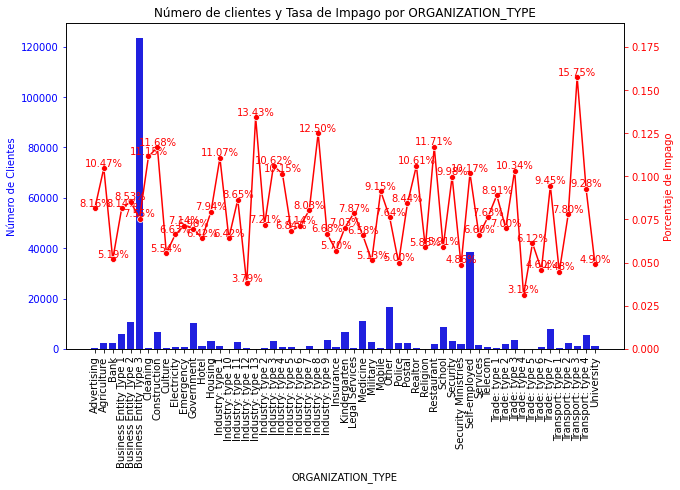

In [26]:
# Se sustituye el valor XNA en las columnas
for col in categorical_variables:
    mode = app_train[col].mode()[0]  # Calcular la moda
    app_train[col] = app_train[col].replace('XNA', mode)  # Reemplazar 'XNA' por la moda
    
# Se muestra de nuevo la distribución de la variable ORGANIZATION_TYPE
get_default_by_category('ORGANIZATION_TYPE', app_train, 10, 6, 90)

Por otro lado, se ve que las variables de rating por región, con y sin ciudad (REGION_RATING_CLIENT y REGION_RATING_CLIENT_W_CITY), concentra el mayor porcentaje de impagos en el nivel 3, lo cual debería ayudar al modelo en su proceso de decisión. En OCUPATION_TYPE y ORGANIZATION_TYPE los grupos que peor pagan son *low skills laborers* y *Transport: type 3*, pero al agruparse en un número menor de agrupaciones habrá que ver como quedan estos porcentajes. A nivel educativo los peores pagadores son los que tienen nivel de estudios *lower secondary*, que es un nivel de estudios bajos, mientras que en lo que respecta a tipo de vivienda, las personas alquiladas tienen peor comportamiento. Otro punto curioso es que en lo que respecta al origen de los ingresos, el porcentaje de impago de las excedencias por maternidad son muy altas. Todas estas consideraciones son relevantes a la hora de determinar la probabilidad de impago de un cliente.

A continuación, se muestran los diferentes valores de las variables que no son OCCUPATION_TYPE y ORGANIZATION_TYPE y se indican posibles transformaciones a realizar para optimizar su tratamiento.

In [27]:
# Recorremos las variables categóricas a excepción de OCCUPATION_TYPE y ORGANIZATION_TYPE
# para mostrar sus diferentes valores
for column in categorical_variables:
    if column not in ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']:
        print(f'Nombre de la columna: {column}. Valores distintos:{app_train[column].unique()}')

Nombre de la columna: NAME_CONTRACT_TYPE. Valores distintos:['Cash loans' 'Revolving loans']
Nombre de la columna: FLAG_OWN_CAR. Valores distintos:['N' 'Y']
Nombre de la columna: FLAG_OWN_REALTY. Valores distintos:['Y' 'N']
Nombre de la columna: NAME_TYPE_SUITE. Valores distintos:['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']
Nombre de la columna: NAME_INCOME_TYPE. Valores distintos:['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
Nombre de la columna: NAME_EDUCATION_TYPE. Valores distintos:['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Nombre de la columna: NAME_FAMILY_STATUS. Valores distintos:['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
Nombre de la columna: NAME_HOUSING_TYPE. Valores distintos:['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartme

Analizando los valores de las diferentes variables se pueden identificar las siguientes transformaciones a tratar. 

- La variable NAME_CONTRACT_TYPE se puede transformar en un flag que indique si es un préstamo o una tarjeta, del tipo IS_LOAN.
- Las variables FLAG_OWN_CAR y FLAG_OWN_REALTY han de convertirse en variables numéricas donde Y = 1 y N = 0.
- En la variable NAME_TYPE_SUITE, se pueden agregar los valores en tres categorías: No acompañado, Familia (family, spouse/partner, children) y otros (Other_A, Other_B y group of people).
- En la variable NAME_INCOME_TYPE, se pueden agregar los valores en cuatro categorías: Salaried (Working, Pensioner, State servant), Self-Employed (Commercial associate, Businessman), Unemployed (Unemployed) y Other (Maternity leave, Student).
- En la variable NAME_FAMILY_STATUS, se pueden agrupar sus valores en 5 categorías uniendo los valores Married y Civil marriage en una sola categoría Married.
- En la variable NAME_EDUCATION_TYPE, se pueden agregar los valores en tres categorías: Secondary (Secondary / secondary special, Lower secondary), Higher (Incomplete higher, Higher education) y Academic degree (Academic degree).
- En la variable NAME_HOUSING_TYPE, se pueden agregar los valores en cuatro categorías: Owned (House / apartment), Rented (Rented apartment), Social (Municipal apartment, Co-op apartment) y Other (With parents, Office apartment).
- En la varaible WEEKDAY_APPR_PROCESS_START, se pueden agrupar los valores en dos categorías: WEEKEND (SUNDAY, SATURDAY) y WEEKDAY (WEDNESDAY, MONDAY, TUESDAY, THURSDAY, FRIDAY).

Una vez realizadas estas transformaciones, estas variables junto con las que no se han mencionado, se pueden convertir en variables *dummy* mediante procesos como *label encoding* y *One Hot Encoding*.

A continuación, se van a analizar los valores de las variables OCCUPATION_TYPE y ORGANIZATION_TYPE. En primer lugar, vamos a ver los valores de la variable OCCUPATION_TYPE.

In [28]:
# Mostramos los valores de la variable OCCUPATION_TYPE 
app_train['OCCUPATION_TYPE'].unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Drivers',
       'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

Después de analizar las diferentes ocupaciones, podemos agruparlas por sus características en cuatro grupos:

- Workers: Laborers, Low-skill Laborers, Drivers, Cleaning staff, Security staff 
- Service and commerce: Sales staff, Private service staff, Realty agents, Cooking staff, Waiters/barmen staff
- Finance and administration: Secretaries, HR staff, Accountants, Core staff
- Managers and technicians: High skill tech staff, IT staff, Medicine staff, Managers

A continuación, se analizan los valores de la variable ORGANIZATION_TYPE:

In [29]:
# Mostramos los valores de la variable ORGANIZATION_TYPE 
app_train['ORGANIZATION_TYPE'].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'Electricity', 'Medicine', 'Business Entity Type 2',
       'Self-employed', 'Transport: type 2', 'Construction', 'Housing',
       'Kindergarten', 'Trade: type 7', 'Industry: type 11', 'Military',
       'Services', 'Security Ministries', 'Transport: type 4',
       'Industry: type 1', 'Emergency', 'Security', 'Trade: type 2',
       'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry

Después de analizar los diferentes tipos de organizaciones, podemos agruparlas por sus características en seis grupos:

- Public services: School, Government, Religion, Military, Security Ministries, Police, University, Emergency, Postal, Kindergarten, Medicine
- Private business: Business Entity Type 1, Business Entity Type 2, Business Entity Type 3, Self-employed, Legal Services, Bank, Insurance, Realtor, Advertising, Telecom, Mobile
- Industry and construction: Construction, Electricity, Industry: type 1, Industry: type 2, Industry: type 3, Industry: type 4, Industry: type 5, Industry: type 6, Industry: type 7, Industry: type 8, Industry: type 9, Industry: type 10, Industry: type 11, Industry: type 12, Industry: type 13, Agriculture, Housing
- Commerce and services: Trade: type 1, Trade: type 2, Trade: type 3, Trade: type 4, Trade: type 5, Trade: type 6, Trade: type 7, Restaurant, Hotel, Cleaning, Culture, Services
- Transport and security: Transport: type 1, Transport: type 2, Transport: type 3, Transport: type 4, Security
- Other: Other, XNA

Respecto a las variables numéricas no categóricas, vamos a mostrar gráficos con su distribución.

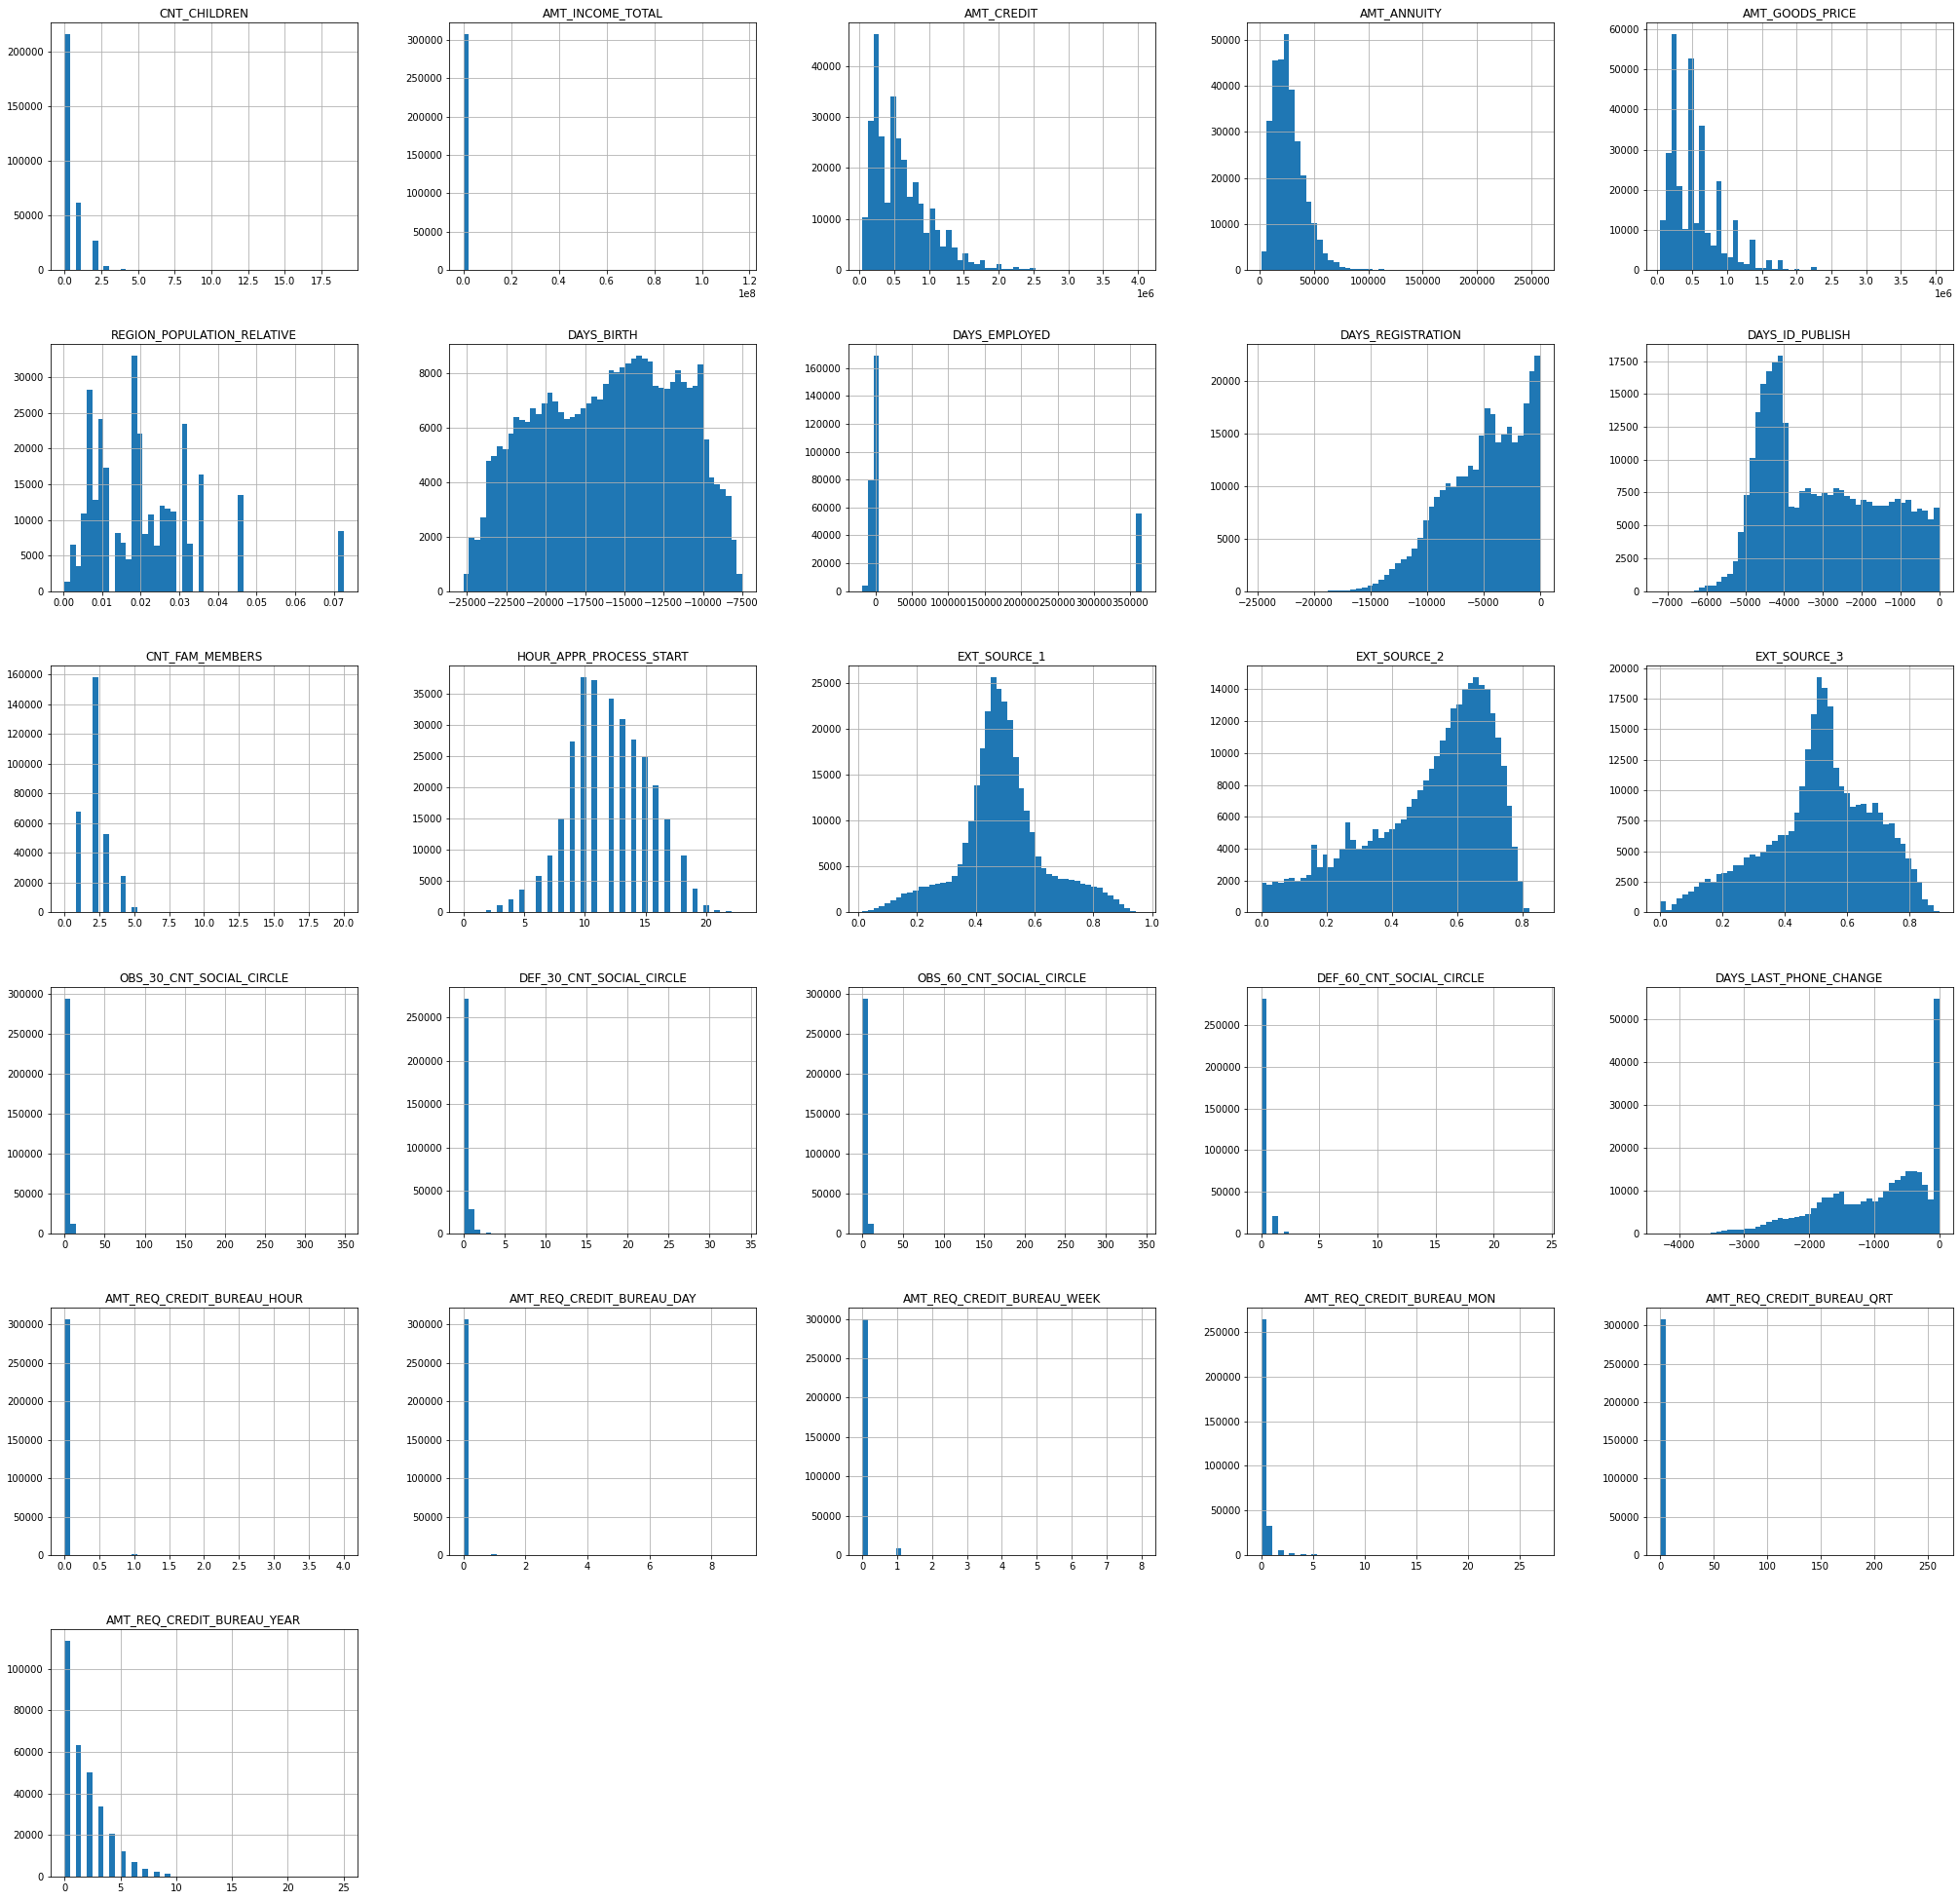

In [30]:
# Se muestra la distribución de las variables númericas no categóricas
# Se crea una lista con las variables a excluir
list_num_variables_to_drop = ['SK_ID_CURR']
# Se identifican las columnas dicotómicas
dicotomic_columns = [col for col in app_train.columns if app_train[col].nunique() <= 2]
# Se unen las dos listas
list_num_variables_to_drop.extend(dicotomic_columns)

# Se seleccionan las variables a mostrar
numerical_features = app_train.loc[:, ~app_train.columns.isin(list_num_variables_to_drop)
                                           ].select_dtypes(include=['int64', 'float64']).columns

# Se muestran los histogramas
app_train[numerical_features].hist(figsize=(35,35), bins=50)
plt.show()

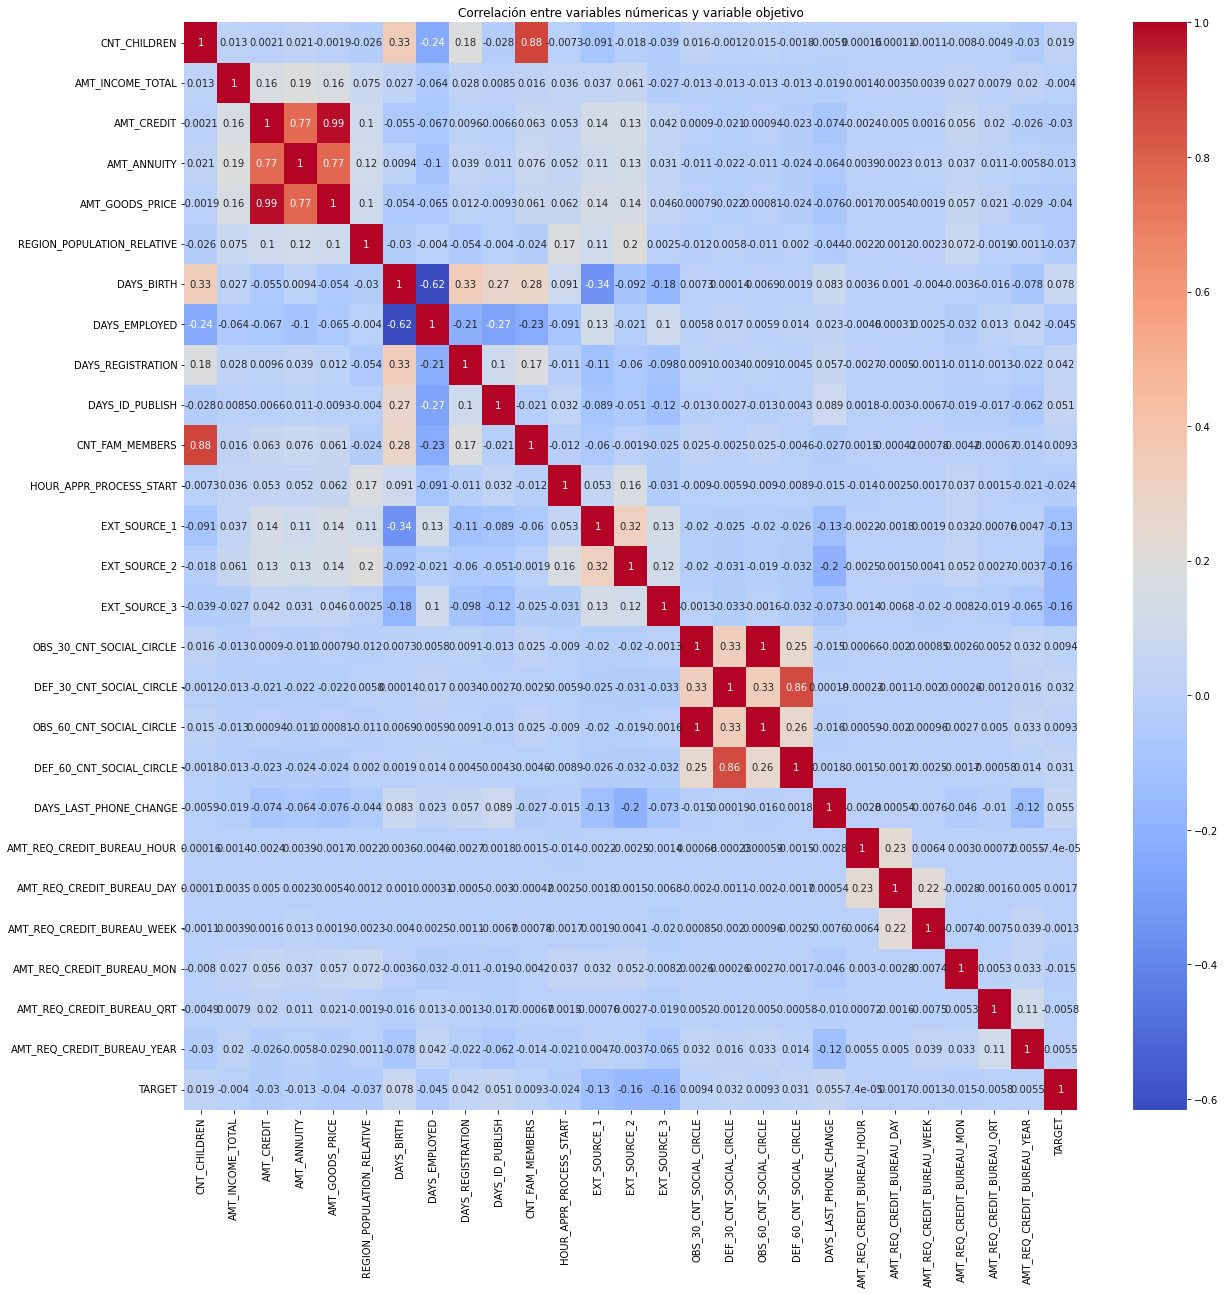

In [31]:
# Se muestra la correlación de las variables númericas no categóricas con la variable objetivo
numeric_columns = list(numerical_features)
numeric_columns.append('TARGET')

fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(app_train[numeric_columns].corr(), 
            annot=True, cmap="coolwarm")
plt.title("Correlación entre variables númericas y variable objetivo")
plt.show()

Muchas de las variables son dicotómicas, aquellas que se identifican como *flag_* y algunas otras, teniendo solo dos valores en el histograma. En el resto de variables encontramos distribuciones dispares. Por ejemplo, en las variables de scores de riesgo, EXT_SOURCE_1, EXT_SOURCE_2 y EXT_SOURCE_3 muestran distribuciones normales, las dos últimas con una ligera cola a la izquierda. Lo mismo ocurre con la variable DAYS_BIRTH, que representa la edad, lo que es lógico al tratarse de una evolución normal en una variable de este tipo. En líneas generales no se aprecian anomalías en los histogramas, aunque en algunas de ellas se ven anomalías, como por ejemplo en los ingresos anuales (AMT_INCOME_TOTAL) o el número de hijos (CNT_CHILDREN). Este, y otros casos parecidos, son claramente casos de *outliers* que habrá que analizar para determinar qué hacer con ellos.

Por otro lado, debido a que son dicotómicas y no se sabe muy bien qué tipo de documentación representan, las variables FLAG_DOCUMENT_ se consolidarán en una sola variable para reducir la dimensionalidad del conjunto de datos. Esta variable indicará el número de documentos presentados en la solicitud.

Las variables EXT_SOURCE_1, EXT_SOURCE_2 y EXT_SOURCE_3 son variables que informan de notas de score de riesgo de los clientes solicitantes de préstamos. Estas variables, como se ha visto en los estadísticos básicos de las variables numéricas, tienen valores entre 0 y 1, pero no sabemos que indica que el cliente tenga un valor cercano a 0 o a 1. Por este motivo, se muestra la distribución de los valores de estas variables en función de si son malos pagadores o no.

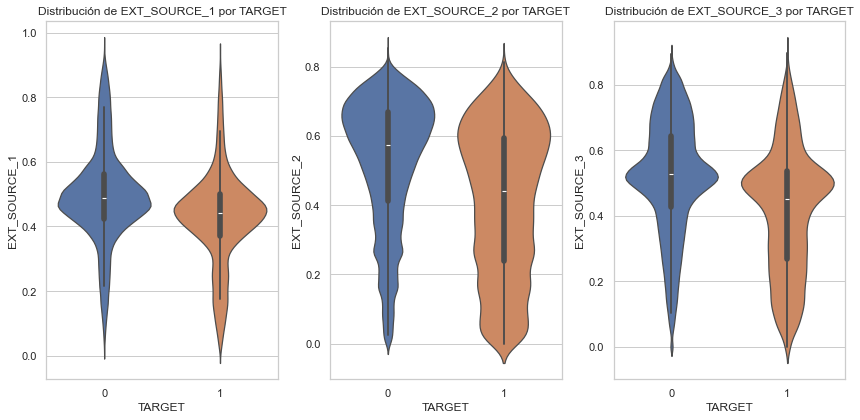

In [32]:
# Se configura el estilo del gráfico a mostrar
sns.set(style="whitegrid")

# Se crea un gráfico
plt.figure(figsize=(12, 6))

# Se crean los gráficos de violin de EXT_SOURCE_1, EXT_SOURCE_2 y EXT_SOURCE_3 por TARGET
for i, col in enumerate(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], 1):
    plt.subplot(1, 3, i)
    sns.violinplot(x="TARGET", y=col, data=app_train, hue='TARGET', legend=False)
    plt.title(f"Distribución de {col} por TARGET")

# Se muestran los gráficos
plt.tight_layout()
plt.show()

<ipython-input-4-a01c5553ca61>:172: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column][df['TARGET'] == 0].dropna(),
<ipython-input-4-a01c5553ca61>:174: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column][df['TARGET'] == 1].dropna(),


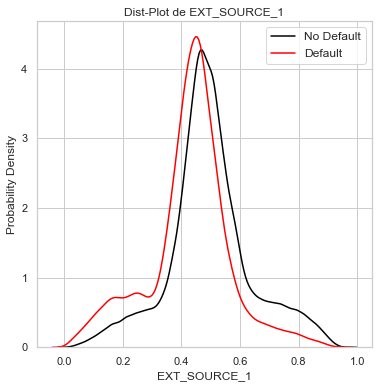

<ipython-input-4-a01c5553ca61>:172: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column][df['TARGET'] == 0].dropna(),
<ipython-input-4-a01c5553ca61>:174: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column][df['TARGET'] == 1].dropna(),


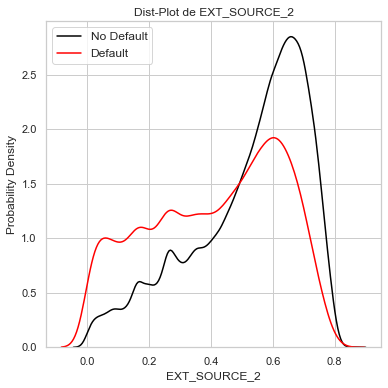

<ipython-input-4-a01c5553ca61>:172: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column][df['TARGET'] == 0].dropna(),
<ipython-input-4-a01c5553ca61>:174: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column][df['TARGET'] == 1].dropna(),


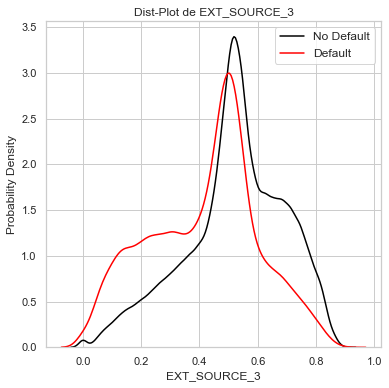

In [33]:
# Se crean los gráficos de violin de EXT_SOURCE_1, EXT_SOURCE_2 y EXT_SOURCE_3 por TARGET
for i, col in enumerate(["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"], 1):
    get_distplot_vs_target(col, app_train, 6, 6)

En base a la mediana de las distribuciones, todas las variables parecen indicar que valores cercanos a 0 son malos pagadores y valores cercanos a 1 son buenos pagadores.

Dentro de las variables numéricas se han de tener en cuenta los valores extremos o *outliers*, y valorar la forma en la que vamos a tratarlos, ya que su presencia puede impactar en el rendimiento del modelo. El proceso de identificación se va a basar en percentiles. Se establece el límite inferior en el 1% y el límite superior en el 99%. Todo lo que esté por encima o por debajo de estos límites se considerará un *outlier* y se tendrá que analizar para valorar cual será la mejor medida a tomar.

In [34]:
# Se seleccionan las variables númericas excluyenfo el identificador de la solicitud
numeric_columns = app_train.loc[:, ~app_train.columns.isin(list_num_variables_to_drop)
                                        ].select_dtypes(include=['int64', 'float64'])

# establecemos los límites superior e inferior
upper_threshold = numeric_columns.quantile(0.99)
lower_threshold = numeric_columns.quantile(0.01)

# Se identifican los outliers
over_outliers = numeric_columns.max() > upper_threshold
under_outliers = numeric_columns.min() < lower_threshold

# Mostramos los outliers detectados
print("Outliers que están por encima del 99% del conjunto:\n")
print(numeric_columns.loc[:, over_outliers].max())
print("\n\n")
print("Outliers que están por debajo del 1% del conjunto:\n")
print(numeric_columns.loc[:, under_outliers].min())

Outliers que están por encima del 99% del conjunto:

CNT_CHILDREN                  1.900000e+01
AMT_INCOME_TOTAL              1.170000e+08
AMT_CREDIT                    4.050000e+06
AMT_ANNUITY                   2.580255e+05
AMT_GOODS_PRICE               4.050000e+06
DAYS_BIRTH                   -7.489000e+03
DAYS_REGISTRATION             0.000000e+00
DAYS_ID_PUBLISH               0.000000e+00
CNT_FAM_MEMBERS               2.000000e+01
HOUR_APPR_PROCESS_START       2.300000e+01
EXT_SOURCE_1                  9.626928e-01
EXT_SOURCE_2                  8.549997e-01
EXT_SOURCE_3                  8.960095e-01
OBS_30_CNT_SOCIAL_CIRCLE      3.480000e+02
DEF_30_CNT_SOCIAL_CIRCLE      3.400000e+01
OBS_60_CNT_SOCIAL_CIRCLE      3.440000e+02
DEF_60_CNT_SOCIAL_CIRCLE      2.400000e+01
AMT_REQ_CREDIT_BUREAU_HOUR    4.000000e+00
AMT_REQ_CREDIT_BUREAU_DAY     9.000000e+00
AMT_REQ_CREDIT_BUREAU_WEEK    8.000000e+00
AMT_REQ_CREDIT_BUREAU_MON     2.700000e+01
AMT_REQ_CREDIT_BUREAU_QRT     2.610000e+02
A

Para entender mejor las diferentes casuísticas en lo referente a los outliers, se van a representar gráficamente.

In [35]:
# Se crea un diccionario para almacenar los datos a mostrar
outliers = {}

# Por cada columna, se crea un gráfico con su distribución y los valores que se pueden 
# considerar como outliers
for column in numeric_columns.columns:
    lower_bound = lower_threshold[column]
    upper_bound = upper_threshold[column]
    outliers[column] = numeric_columns[(numeric_columns[column] < lower_bound) | 
                                    (numeric_columns[column] > upper_bound)]

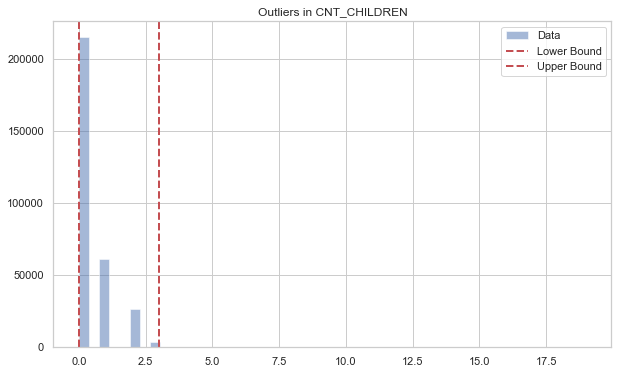

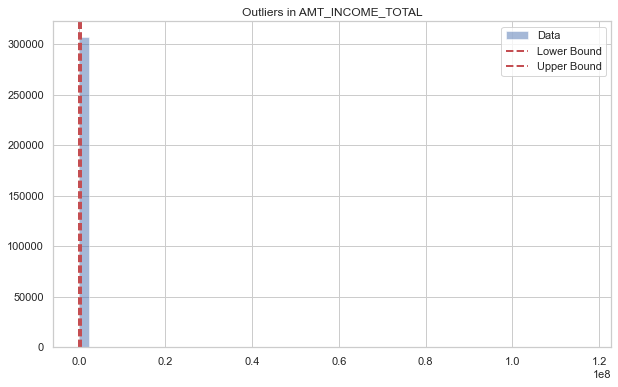

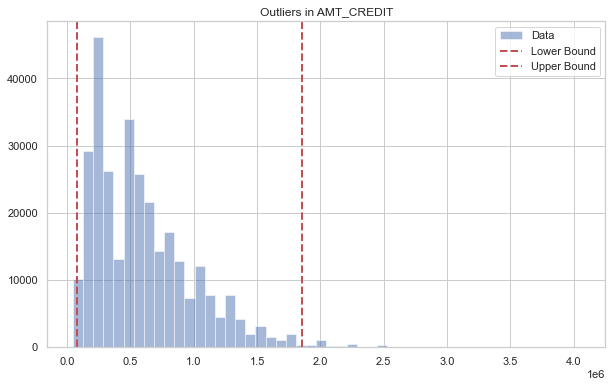

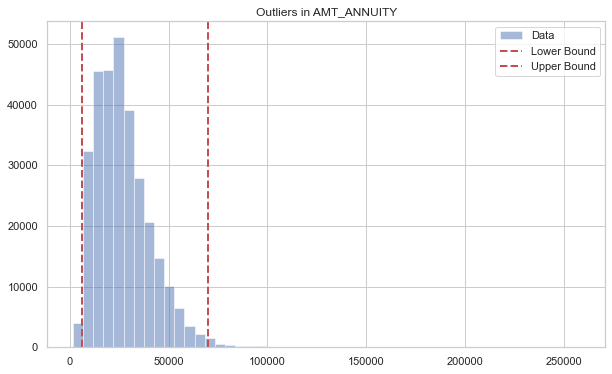

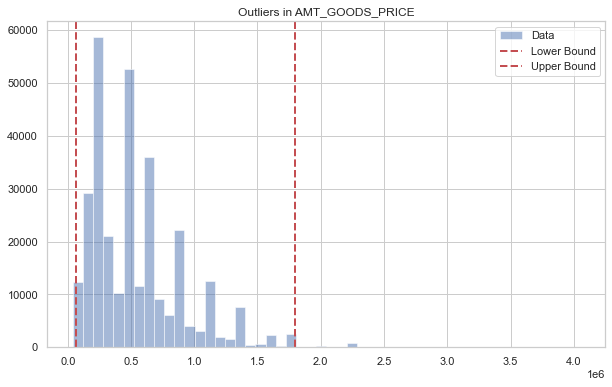

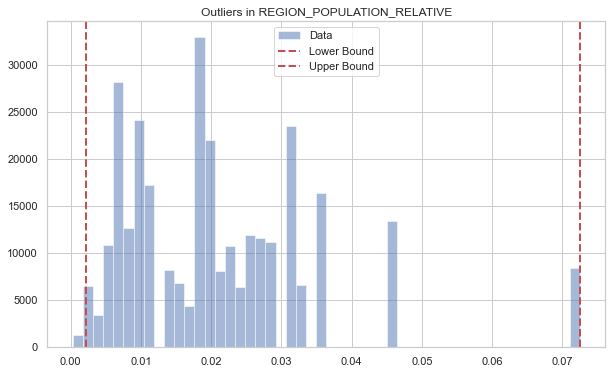

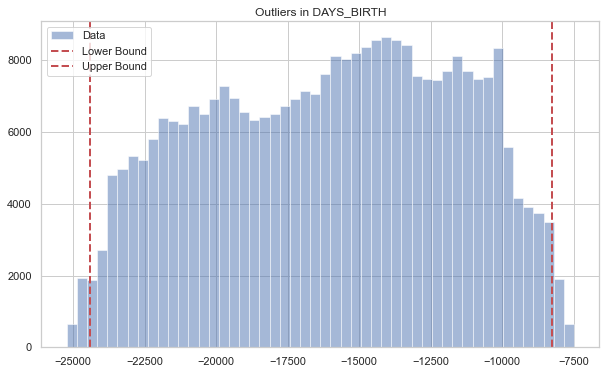

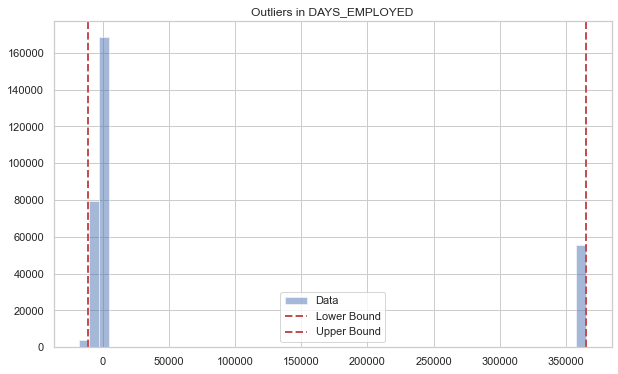

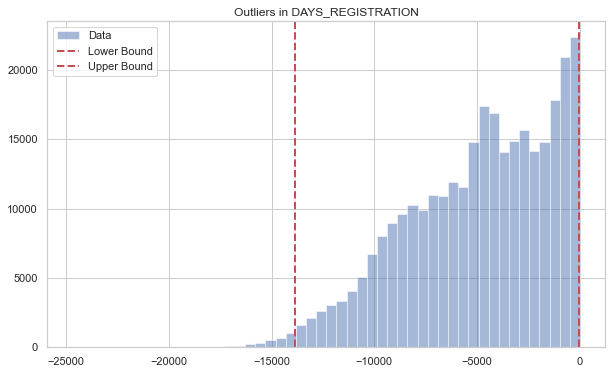

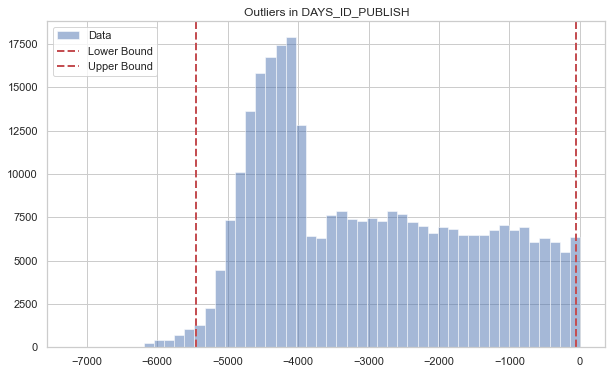

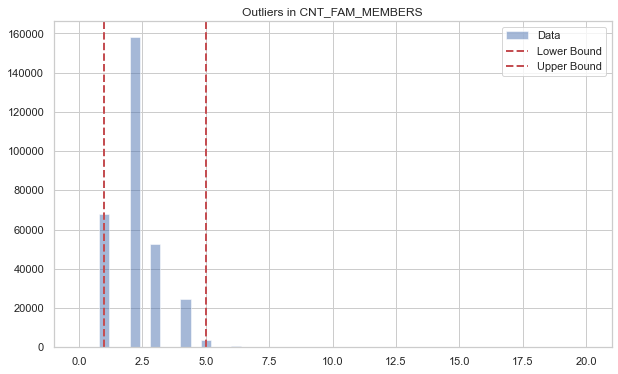

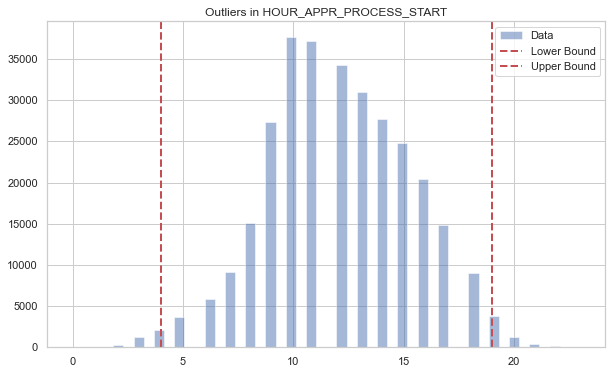

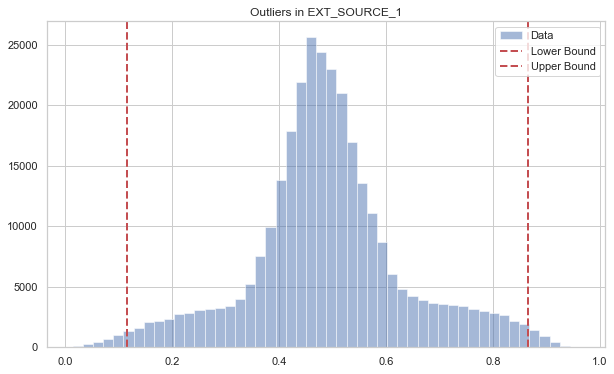

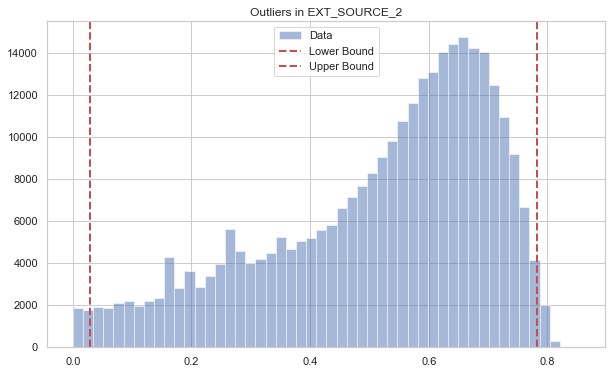

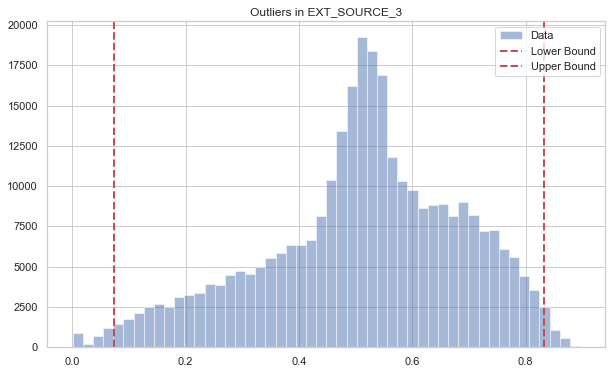

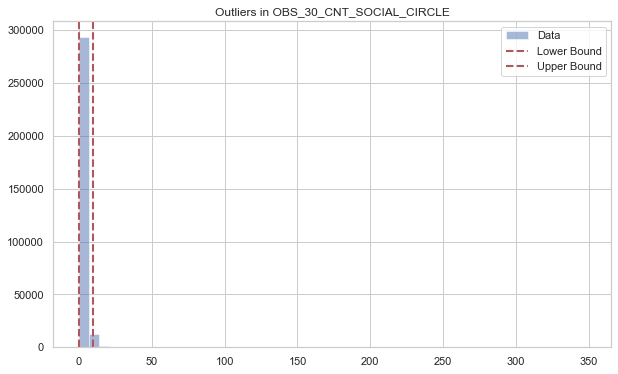

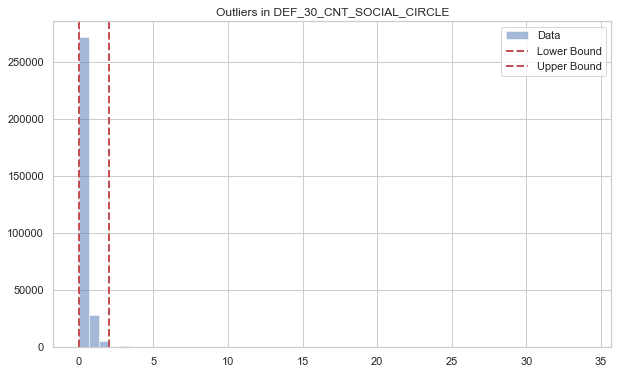

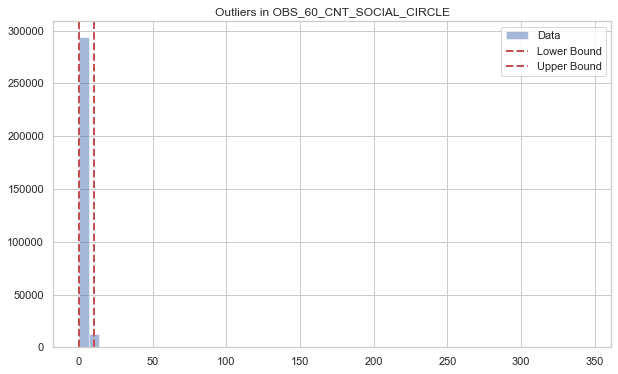

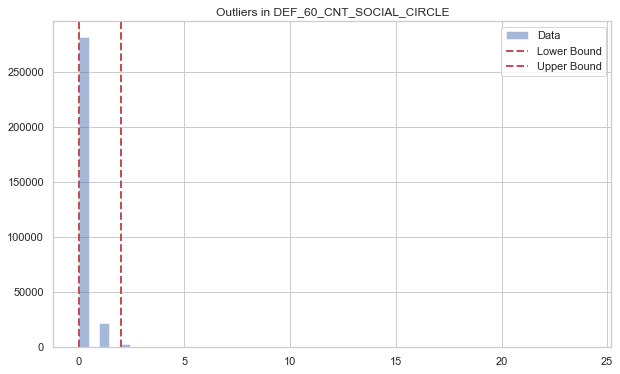

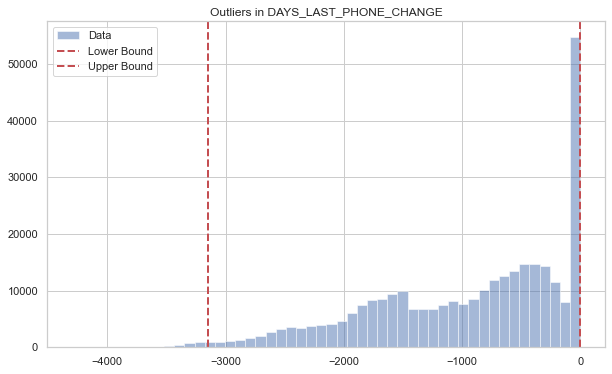

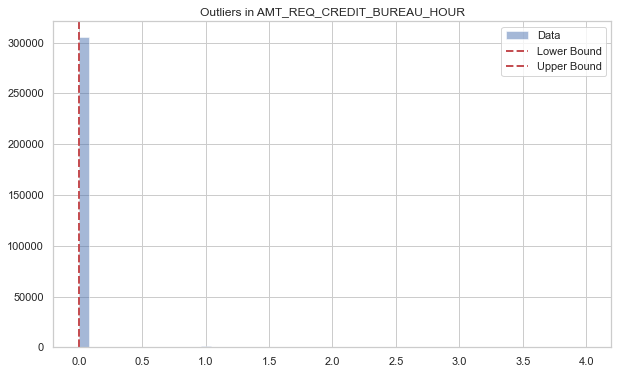

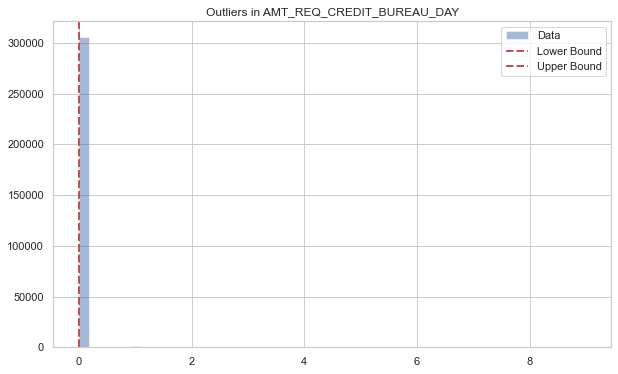

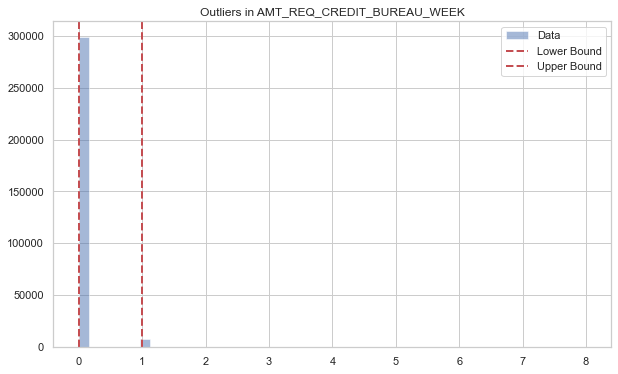

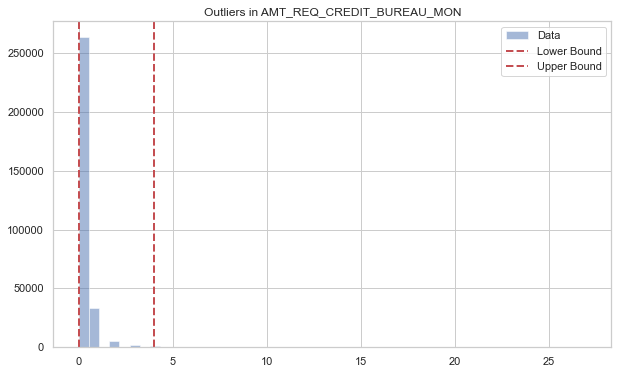

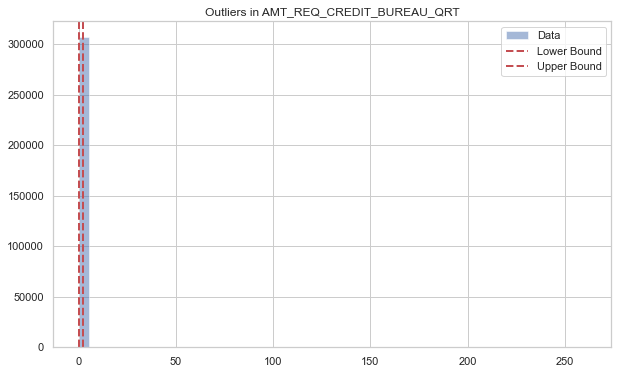

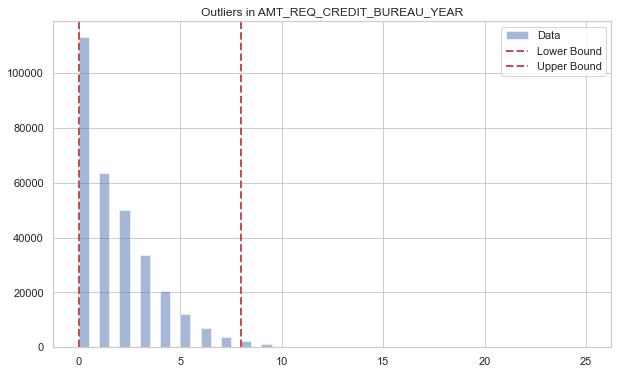

In [36]:
# Se crea un gráfico por cada columna
for column in numeric_columns.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(numeric_columns[column], bins=50, alpha=0.5, label='Data')
    plt.axvline(lower_threshold[column], color='r', linestyle='dashed', linewidth=2, label='Lower Bound')
    plt.axvline(upper_threshold[column], color='r', linestyle='dashed', linewidth=2, label='Upper Bound')
    plt.title(f'Outliers in {column}')
    plt.legend()
    plt.show()

También son de gran ayuda en estos casos los diagramas de caja.

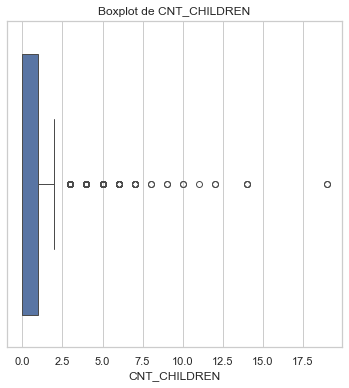

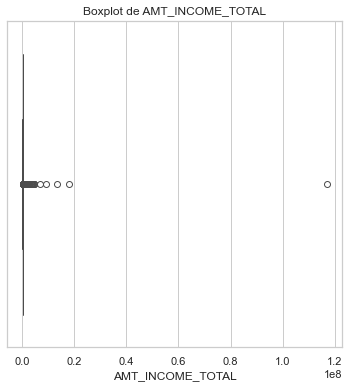

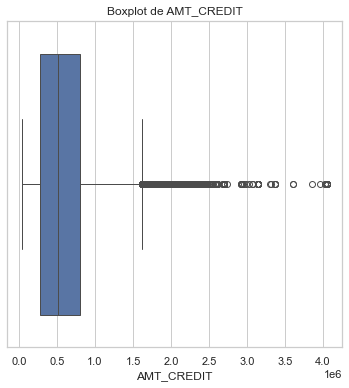

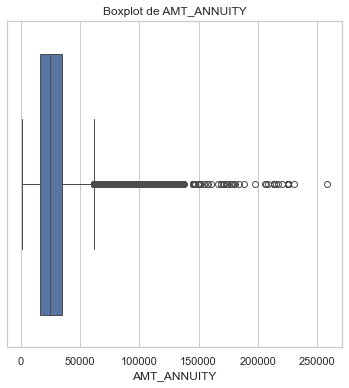

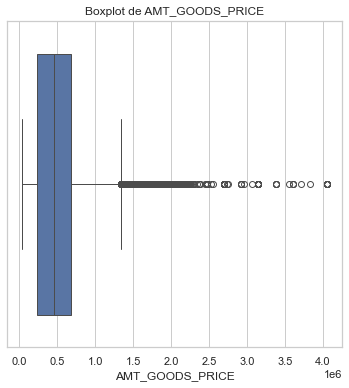

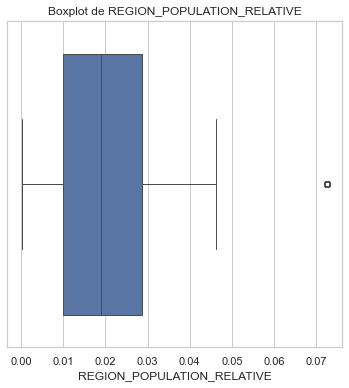

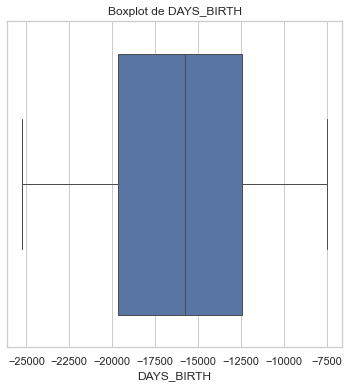

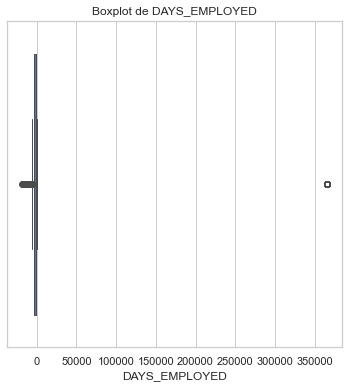

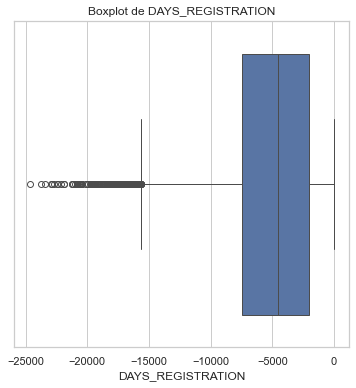

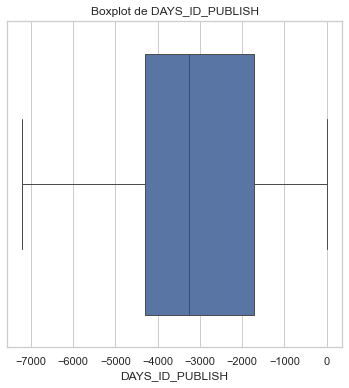

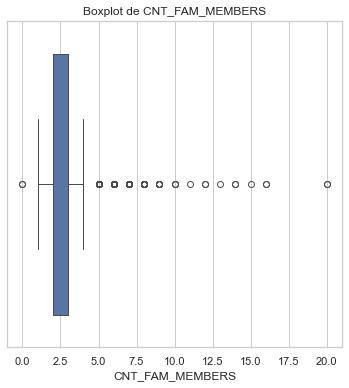

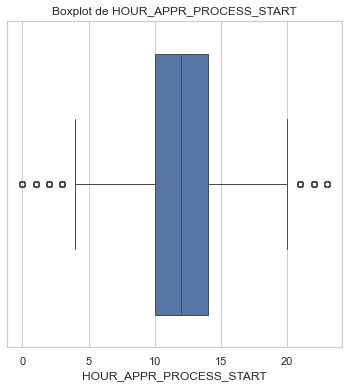

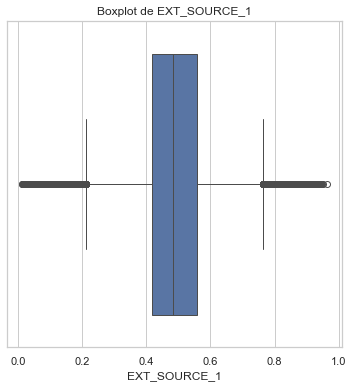

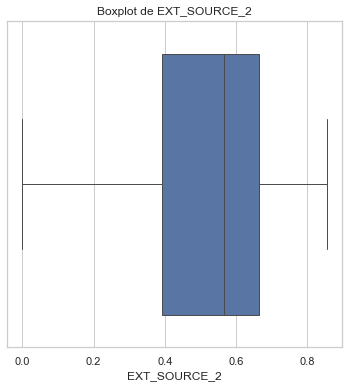

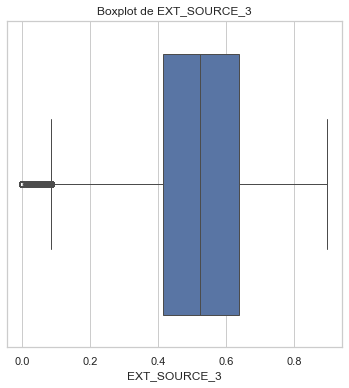

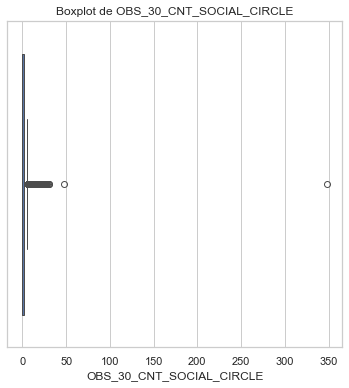

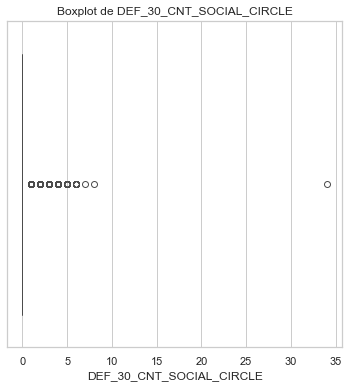

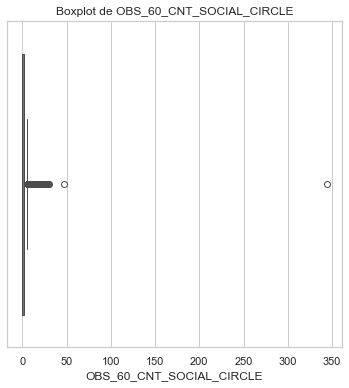

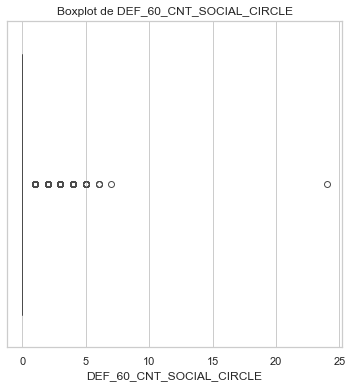

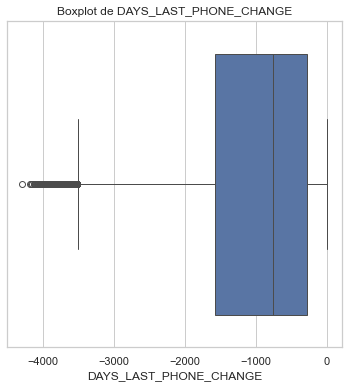

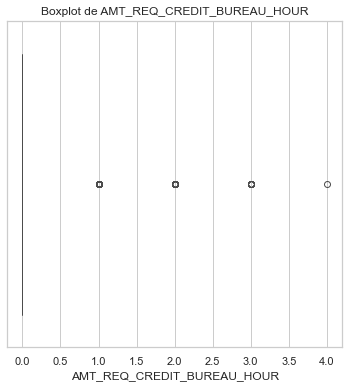

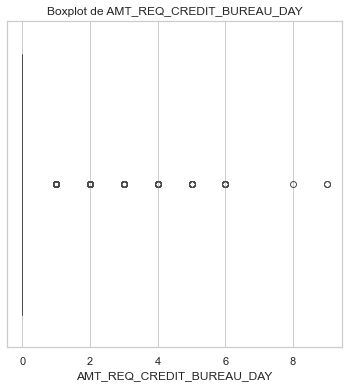

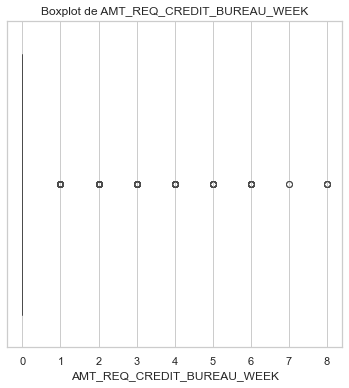

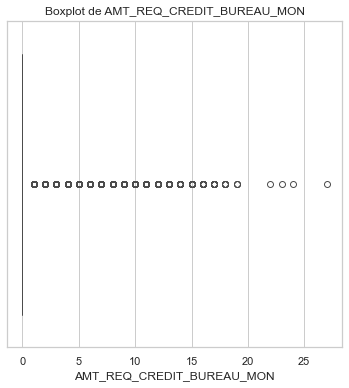

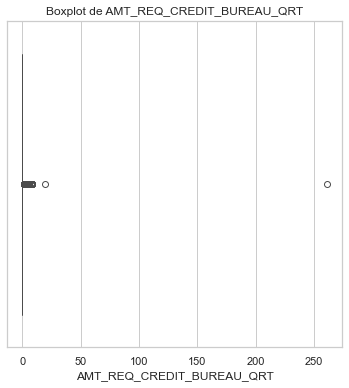

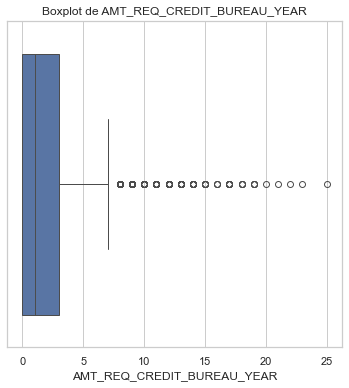

In [37]:
# Se genera un diagrama de caja para cada una de las variables
for column in numeric_columns:
    get_boxplot(column, app_train, 6, 6)

En casos más concretos, se puede analizar su distribución mediante diagramas de dispersión. Se van a analizar ciertas variables para ver si se han de considerar algunos de esos valores como *outliers* a tratar. Por ejemplo, la variable AMT_INCOME_TOTAL, existe un registro que declara unos ingresos de 117 millones, ¿puede ser un error?, sí, pero también puede ser cierto, además este registro está marcado como mal pagador, por lo que se puede considerar que es significativo, por lo tanto se mantiene en el conjunto de datos.

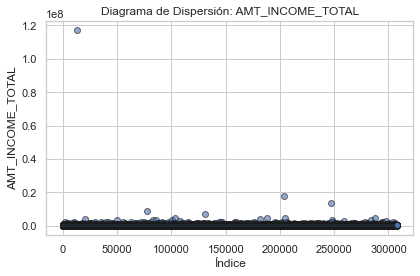

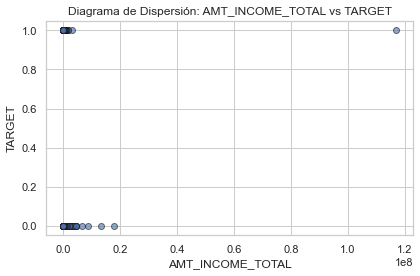

In [38]:
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL
get_scatter_plot_by_column(app_train, 'AMT_INCOME_TOTAL')
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL respecto a la variable TARGET
get_scatter_plot_by_column(app_train, 'AMT_INCOME_TOTAL', 'TARGET')

In [45]:
# Se muestra el registro con ingresos de 117 millones
app_train[app_train['AMT_INCOME_TOTAL']==117000000]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  \
12840      114967       1         Cash loans            N               Y   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
12840             1       117000000.0    562491.0      26194.5   

       AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
12840         454500.0   Unaccompanied          Working   

                 NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
12840  Secondary / secondary special            Married  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
12840                    0.010643      -12615           -922   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
12840            -6762.0            -3643           1               1   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
12840                0                 1           0           0   

      OCCUPATION_TYPE  CNT_FAM_MEMBERS REGION_RATING_CLIENT  \
12840        Laborers              3.0                    2   

      REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
12840                           2                    TUESDAY   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
12840                       14                           0   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
12840                           0                            0   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
12840                       0                       0   

       LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
12840                        0  Business Entity Type 3      0.460809   

       EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
12840      0.113161      0.145543                       0.0   

       DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
12840                       0.0                       0.0   

       DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
12840                       0.0                     0.0                0   

       FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
12840                1                0                0                0   

       FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
12840                0                0                0                 0   

       FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
12840                 0                 0                 0                 0   

       FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  \
12840                 0                 0                 0                 0   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
12840                 0                 0                 0   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
12840                         0.0                        0.0   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
12840                         0.0                        0.0   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
12840                        0.0                         1.0

Un caso especialmente significativo es el de la variable DAYS_EMPLOYED. Es una variable que indica en negativo los días que el solicitante lleva trabajando en su trabajo actual. Vemos que su valor máximo es 365243, lo que no puede ser en base a la naturaleza de la variable. Se va a comprobar cuantos registros tienen ese valor y se va a cambiar este valor por NaN para que sean tratados posteriormente como nulos.

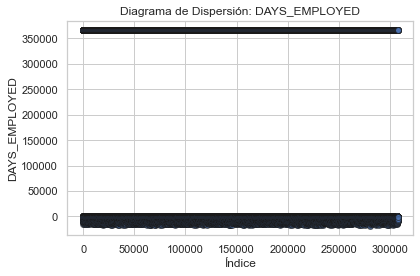

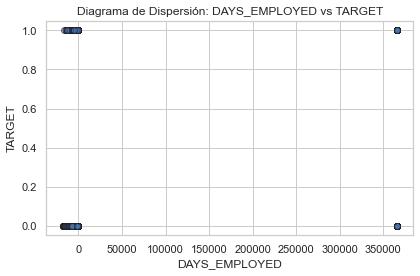

In [39]:
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL
get_scatter_plot_by_column(app_train, 'DAYS_EMPLOYED')
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL respecto a la variable TARGET
get_scatter_plot_by_column(app_train, 'DAYS_EMPLOYED', 'TARGET')

In [48]:
# Se comprueba el numero de registros con el valor indicado
print("Número de registros con DAYS_EMPLOYED igual a 365243: " + str((app_train['DAYS_EMPLOYED'] == 365243).sum()))
print("Porcentaje de registros con DAYS_EMPLOYED igual a 365243: " + str((app_train['DAYS_EMPLOYED'] == 365243).mean() * 100))

Número de registros con DAYS_EMPLOYED igual a 365243: 55374
Porcentaje de registros con DAYS_EMPLOYED igual a 365243: 18.007219277421875


Existen 55374 registros con el valor de DAYS_EMPLOYED a 365243. Para poder trabajar con el conjunto de datos se tendrá que sustituir este valor por la mediana de la variable.

In [49]:
# Se imputa  a la variabe DAYS_EMPLOYED la mediana en base a la variable objetivo
# Se reemplazan los valores 365243 por NAN
app_train['DAYS_EMPLOYED'] = app_train['DAYS_EMPLOYED'].replace(365243, np.nan)

# Calcular la mediana separada por clases
median_0 = app_train[app_train['TARGET'] == 0]['DAYS_EMPLOYED'].median()
median_1 = app_train[app_train['TARGET'] == 1]['DAYS_EMPLOYED'].median()
    
# Imputar según el TARGET
app_train.loc[(app_train['DAYS_EMPLOYED'].isnull()) & (app_train['TARGET'] == 0), 'DAYS_EMPLOYED'] = median_0
app_train.loc[(app_train['DAYS_EMPLOYED'].isnull()) & (app_train['TARGET'] == 1), 'DAYS_EMPLOYED'] = median_1

Se comprueba que el valor ha sido sustituido correctamente.

In [50]:
# Se comprueba que ya no existen registros con el valor 365243
print("Número de registros con DAYS_EMPLOYED igual a 365243: " + str((app_train['DAYS_EMPLOYED'] == 365243).sum()))

Número de registros con DAYS_EMPLOYED igual a 365243: 0


Otro caso puede ser el número de hijos (CNT_CHILDREN). Existen registros con hasta 19 hijos. ¿Son muchos? sí, ¿Pero imposible? no, por lo que se dejan los valores tal como están.

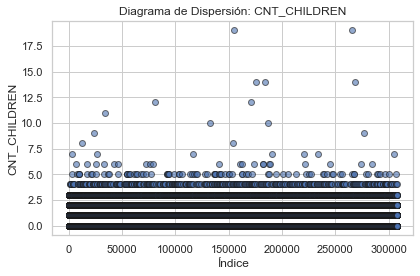

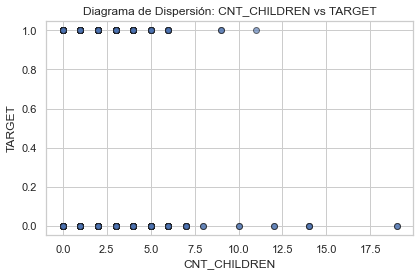

In [40]:
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL
get_scatter_plot_by_column(app_train, 'CNT_CHILDREN')
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL respecto a la variable TARGET
get_scatter_plot_by_column(app_train, 'CNT_CHILDREN', 'TARGET')

Por último, otro caso se produce en relación con las variables OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE y DEF_60_CNT_SOCIAL_CIRCLE. Existe un registro con valores muy por encima del resto en las cuatro variables.

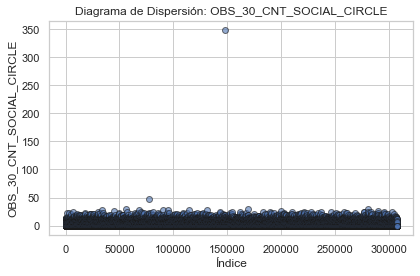

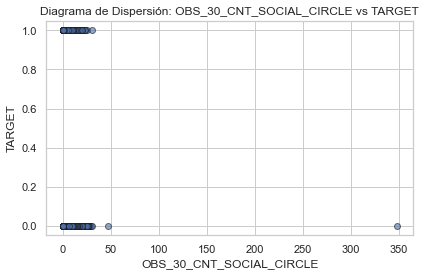

In [41]:
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL
get_scatter_plot_by_column(app_train, 'OBS_30_CNT_SOCIAL_CIRCLE')
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL respecto a la variable TARGET
get_scatter_plot_by_column(app_train, 'OBS_30_CNT_SOCIAL_CIRCLE', 'TARGET')

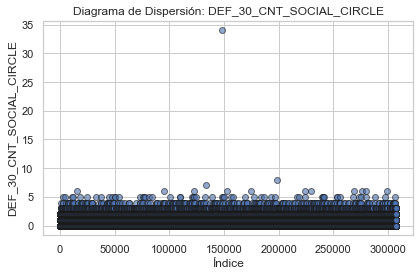

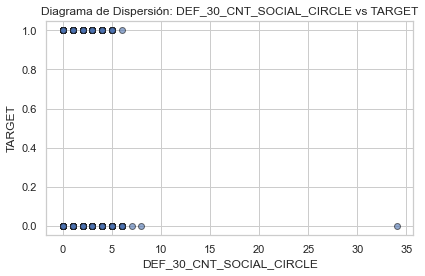

In [42]:
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL
get_scatter_plot_by_column(app_train, 'DEF_30_CNT_SOCIAL_CIRCLE')
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL respecto a la variable TARGET
get_scatter_plot_by_column(app_train, 'DEF_30_CNT_SOCIAL_CIRCLE', 'TARGET')

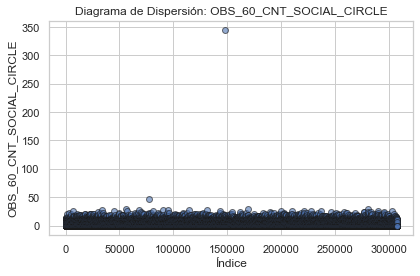

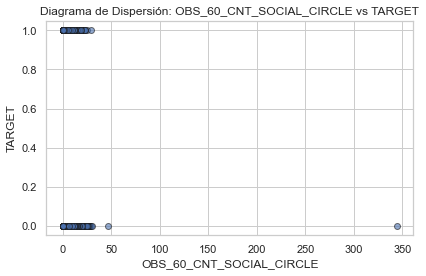

In [43]:
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL
get_scatter_plot_by_column(app_train, 'OBS_60_CNT_SOCIAL_CIRCLE')
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL respecto a la variable TARGET
get_scatter_plot_by_column(app_train, 'OBS_60_CNT_SOCIAL_CIRCLE', 'TARGET')

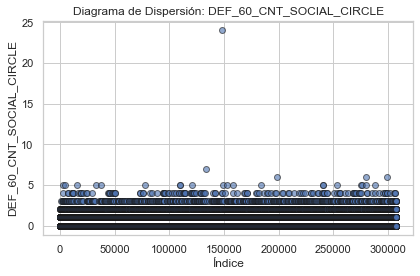

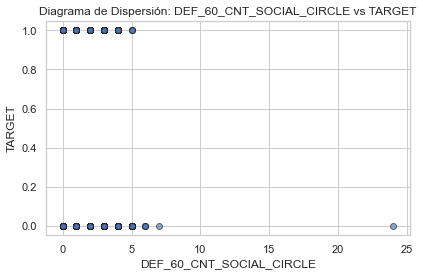

In [44]:
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL
get_scatter_plot_by_column(app_train, 'DEF_60_CNT_SOCIAL_CIRCLE')
# Se muestra el diagrama de dispersión de la variable AMT_INCOME_TOTAL respecto a la variable TARGET
get_scatter_plot_by_column(app_train, 'DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET')

In [46]:
# Se muestra el registro con los valores desproporcionados
app_train[app_train['OBS_30_CNT_SOCIAL_CIRCLE']==348.0][['SK_ID_CURR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                                                        'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'TARGET']]

SK_ID_CURR  OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
148403      272071                     348.0                     344.0   

        DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  TARGET  
148403                      34.0                      24.0       0

Ese registro es buen pagador, a pesar de tener esos valores, por lo que se intuye que es un *outlier*. Por este motivo, y considerando que existe un número suficiente y variado de registros con TARGET igual a 0, se elimina del conjunto de datos.

In [47]:
# Se elimina el registro
app_train = app_train[app_train['OBS_30_CNT_SOCIAL_CIRCLE'] != 348.0]

# Se comprueba la dimensión del conjunto de datos
app_train.shape

(307510, 73)

En algunos casos, como en las variables flag (dicotómicas con valores 1-0), si uno de los valores es mayoritario puede ocurrir que el otro aparezca como un *outlier*, por lo que se han de aislar esos casos para no tenerlos en cuenta a la hora de tratar los outliers. Analizando las variables con *outliers*, podemos tomar las siguientes consideraciones:

- Las variables binarias, como por ejemplo las variables FLAG_DOCUMENT_, FLAG_CONT_MOBILE, etc. son variables con valores dicotómicos. Si uno de estos valores es el informado en la mayoría de los registros, se puede considerar al otro como un *outlier*. Por este motivo se excluyen del tratamiento de *outliers*.

- El resto de variables identificadas como posibles *outliers* presentan valores que pueden considerarse normales para el concepto que representan, aunque estén fuera de los umbrales de tolerancia del resto de registros para esa variable, por ese motivo se mantienen tal cual están en el conjunto de datos.

A continuación, se va a proceder a hacer una análisis exploratorio superficial del resto de ficheros. Esto es así porque se trata de información relacionada con las solicitudes de los ficheros *application* a través del identificador del crédito. El objetivo del trabajo con estos ficheros es el de agrupar información relevante para la evaluación de riesgo crediticia de los créditos de los ficheros *application* y añadirla al conjunto de datos principal.

#### bureau

El fichero *bureau* almacena el historial crediticio de los clientes con otras entidades financieras, lo que puede aportar información relevante del cliente a la hora de pagar créditos solicitados. En primer lugar, se ofrece una muestra de los registros del fichero.

In [80]:
# Primeras 5 filas del dataframe bureau
bureau.head(5)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

Se puede observar que el fichero *bureau* cuenta con el identificador del préstamo, para establecer la relación con los datos de los ficheros *application*. Existen tanto variables numéricas como categóricas aunque el fichero no está formado por un gran número de variables. A continuación, se muestra la información del conjunto de datos.

In [81]:
# Información del dataframe bureau
bureau.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_CURR              1716428 non-null  int64  
 1   SK_ID_BUREAU            1716428 non-null  int64  
 2   CREDIT_ACTIVE           1716428 non-null  object 
 3   CREDIT_CURRENCY         1716428 non-null  object 
 4   DAYS_CREDIT             1716428 non-null  int64  
 5   CREDIT_DAY_OVERDUE      1716428 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     1610875 non-null  float64
 7   DAYS_ENDDATE_FACT       1082775 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  591940 non-null   float64
 9   CNT_CREDIT_PROLONG      1716428 non-null  int64  
 10  AMT_CREDIT_SUM          1716415 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     1458759 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    1124648 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  1716428 non-null  float64
 14  CR

Para completar el análisis, se muestran los estadísticos básicos de las variables numéricas, así como las características más reseñables de las variables categóricas.

In [82]:
# Estadisticos básicos de las variables númericas
bureau.describe()

SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+00   
25%          -1.138000e+03      -1.489000e+03            0.000000e+00   
50%          -3.300000e+02      -8.970000e+02            0.000000e+00   
75%           4.740000e+02      -4.250000e+02            0.000000e+00   
max           3.119900e+04       0.000000e+00            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count        1.716428e+06    1.716415e+06         1.458759e+06   
mean         6.410406e-03    3.549946e+05         1.370851e+05   
std          9.622391e-02    1.149811e+06         6.774011e+05   
min          0.000000e+00    0.000000e+00        -4.705600e+06   
25%          0.000000e+00    5.130000e+04         0.000000e+00   
50%          0.000000e+00    1.255185e+05         0.000000e+00   
75%          0.000000e+00    3.150000e+05         4.015350e+04   
max          9.000000e+00    5.850000e+08         1.701000e+08   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
count          1.124648e+06            1.716428e+06        1.716428e+06   
mean           6.229515e+03            3.791276e+01       -5.937483e+02   
std            4.503203e+04            5.937650e+03        7.207473e+02   
min           -5.864061e+05            0.000000e+00       -4.194700e+04   
25%            0.000000e+00            0.000000e+00       -9.080000e+02   
50%            0.000000e+00            0.000000e+00       -3.950000e+02   
75%            0.000000e+00            0.000000e+00       -3.300000e+01   
max            4.705600e+06            3.756681e+06        3.720000e+02   

        AMT_ANNUITY  
count  4.896370e+05  
mean   1.571276e+04  
std    3.258269e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.350000e+04  
max    1.184534e+08

In [83]:
# Características de las variables categóricas
bureau.describe(include="object")

CREDIT_ACTIVE CREDIT_CURRENCY      CREDIT_TYPE
count        1716428         1716428          1716428
unique             4               4               15
top           Closed      currency 1  Consumer credit
freq         1079273         1715020          1251615

De las variables categóricas, la que más relevancia puede tener es la variable CREDIT_ACTIVE. Por este motivo se va a mostrar su distribución.


Distribución de la variable 'CREDIT_ACTIVE':

   Valor  Conteo  Porcentaje
  Closed 1079273       62.88
  Active  630607       36.74
    Sold    6527        0.38
Bad debt      21        0.00


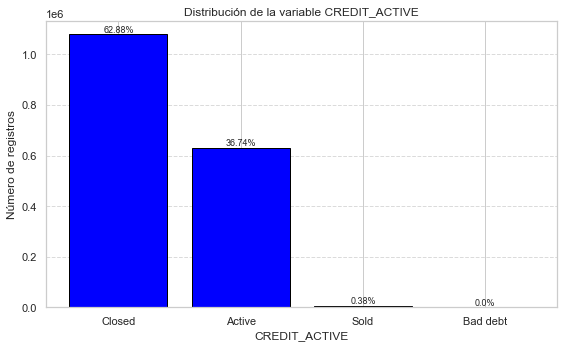

In [173]:
# Se muestra la distribución de la variable CREDIT_ACTIVE
get_variable_distribution(bureau, 'CREDIT_ACTIVE', 8, 5, 0)

Se muestra el porcentaje de valores nulos por columna del fichero.

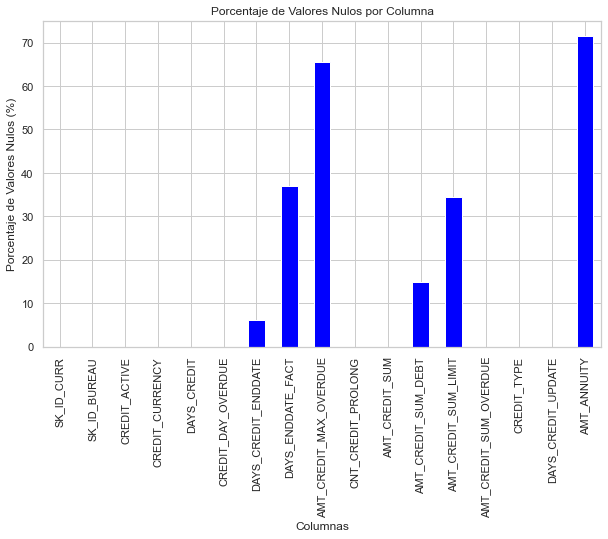

In [110]:
# Se muestran los valores nulos por columna
show_null_values(bureau, 10, 6, 90)

Existen variables con muchos valores negativos, como la supuesta anualidad del préstamo. Es una variable a considerar en el análisis, por lo que no se puede fiar mucho de su aportación. Se puede optar por rellenar con la media o informar los registros del fichero *application_train* que tengan correspondencia con valores informados.

El fichero tiene información relevante acerca de datos de otros préstamos solicitados por el cliente, tanto activos como cerrados, en otras entidades financieras. Esta información puede ser interesante para enriquecer el fichero de datos final. Además, tiene información de los días de retraso en el pago de las cuotas, lo que puede ser muy relevante. Algunos de los atributos que pueden enriquecer el conjunto de datos a utilizar por el modelo, pueden ser los siguientes:

- Número de préstamos previos
- Importe total de crédito previo
- Promedio de días de atraso
- Número de préstamos activos
- Importe total de crédito activo
- Promedio de duración de los préstamos
- Número de préstamos cerrados
- Importe total de crédito cerrado

Se analizará esta y otra información relevante, para añadirla al conjunto de datos final.

#### bureau_balance
El fichero *bureau_balance* contiene información de los estados mensuales de los créditos en bureau (créditos del cliente en otras entidades financieras), lo que puede darnos un detalle más específico del comportamiento de pago del cliente. Se ofrece, en primer lugar, una muestra de los registros del fichero.

In [111]:
# Primeras 5 filas del dataframe bureau_balance
bureau_balance.head(5)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

También se cuenta con el identificador del crédito en los ficheros *application*, lo que facilita la integración, aunque también se tiene el identificador del crédito en el fichero *bureau*. Es un fichero muy pequeño, con solo tres variables, dos numéricas y una categórica. A continuación, se muestra la información del conjunto de datos.

In [112]:
# Información del dataframe bureau_balance
bureau_balance.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   SK_ID_BUREAU    27299925 non-null  int64 
 1   MONTHS_BALANCE  27299925 non-null  int64 
 2   STATUS          27299925 non-null  object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


Se trata de un fichero con solo tres atributos. Para completar el análisis, se muestran los estadísticos básicos de las variables numéricas, así como las características más reseñables de las variables categóricas.

In [113]:
# Estadisticos básicos de las variables númericas
bureau_balance.describe()

SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00

In [114]:
# Características de las variables categóricas
bureau_balance.describe(include="object")

STATUS
count   27299925
unique         8
top            C
freq    13646993

Se ha de tener en cuenta que la variable STATUS almacena el estado del crédito en la fecha de observación. Los diferentes valores que puede almacenar son los siguientes:

- C significa cerrado.
- X significa estado desconocido.
- 0 significa sin DPD. 
- 1 significa DPD 1-30.
- 2 significa DPD 31-60.
- 3 significa DPD 61-90.
- 4 significa DPD 91-120. 
- 5 significa DPD 120+ o vendido o cancelado.

Se muestran el porcentaje de valores nulos por columna.

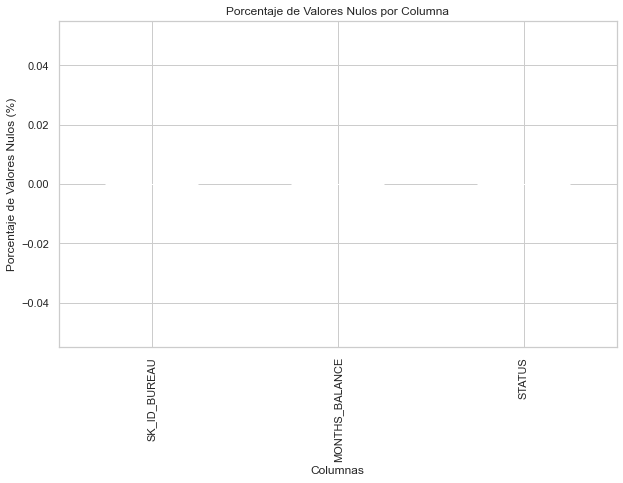

In [115]:
# Se muestran los valores nulos por columna
show_null_values(bureau_balance, 10, 6, 90)

Todos sus valores están informados.

En base a la información del fichero, se puede valorar incluir información relacionada con el comportamiento de pago mes a mes como, por ejemplo:

- Número de meses o media con estado de crédito atrasado
- Número de meses o media con estado de crédito cerrado
- Número de meses con estado de crédito sin información

Se analizará esta y otra información relevante, para añadirla al conjunto de datos final.

#### previous_application

El fichero *previous_application* tiene información relacionada con otros préstamos solicitados por el cliente en la misma entidad financiera donde se está analizando el riesgo. Esta información puede servir para generar un perfilado del comportamiento del cliente respecto al pago de sus créditos en la entidad. En primer lugar, se ofrece una muestra de los registros del fichero.

In [116]:
# Primeras 5 filas del dataframe previous_appplication
previous_app.head(5)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

De nuevo contamos con el identificador del crédito a analizar, lo que facilitará la integración con los datos finales. Es un conjunto de datos con bastantes variables, tanto numéricas como categóricas. Se muestra a continuación la información del fichero y sus campos.

In [117]:
# Información del dataframe previous_application
previous_app.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

Vemos que cuenta con bastante información de los préstamos solicitados previamente por el cliente. Se van a revisar los estadísticos básicos de sus variables numéricas, así como las características de sus variables categóricas.

In [118]:
# Estadisticos básicos de las variables númericas
previous_app.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180581e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697402e+03     2.278473e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  DAYS_DECISION  \
count            5951.000000               5951.000000   1.670214e+06   
mean                0.188357                  0.773503  -8.806797e+02   
std                 0.087671                  0.100879   7.790997e+02   
min                 0.034781                  0.373150  -2.922000e+03   
25%                 0.160716                  0.715645  -1.300000e+03   
50%                 0.189122                  0.835095  -5.810000e+02   
75%                 0.193330                  0.852537  -2.800000e+02   
max                 1.000000                  1.000000  -1.000000e+00   

       SELLERPLACE_AREA   CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count      1.670214e+06  1.297984e+06       997149.000000   997149.000000   
mean       3.139511e+02  1.605408e+01       342209.855039    13826.269337   
std        7.127443e+03  1.456729e+01        88916.115833    72444.869708   
min       -1.000000e+00  0.000000e+00        -2922.000000    -2892.000000   
25%       -1.000000e+00  6.000000e+00       365243.000000    -1628.000000   
50%        3.000000e+00  1.200000e+01       365243.000000     -831.000000   
75%        8.200000e+01  2.400000e+01       365243.000000     -411.000000   
max        4.000000e+06  8.400000e+01       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1242.000000   -1314.000000      -1270.000000   
50%                  -361.000000    -537.000000       -499.000000   
75%                   129.000000     -74.000000        -44.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
25%                     0.0000

In [119]:
# Características de las variables categóricas
previous_app.describe(include="object")

NAME_CONTRACT_TYPE WEEKDAY_APPR_PROCESS_START  \
count             1670214                    1670214   
unique                  4                          7   
top            Cash loans                    TUESDAY   
freq               747553                     255118   

       FLAG_LAST_APPL_PER_CONTRACT NAME_CASH_LOAN_PURPOSE  \
count                      1670214                1670214   
unique                           2                     25   
top                              Y                    XAP   
freq                       1661739                 922661   

       NAME_CONTRACT_STATUS      NAME_PAYMENT_TYPE CODE_REJECT_REASON  \
count               1670214                1670214            1670214   
unique                    4                      4                  9   
top                Approved  Cash through the bank                XAP   
freq                1036781                1033552            1353093   

       NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO  \
count           849809          1670214             1670214        1670214   
unique               7                4                  28              5   
top      Unaccompanied         Repeater                 XNA            POS   
freq            508970          1231261              950809         691011   

       NAME_PRODUCT_TYPE             CHANNEL_TYPE NAME_SELLER_INDUSTRY  \
count            1670214                  1670214              1670214   
unique                 3                        8                   11   
top                  XNA  Credit and cash offices                  XNA   
freq             1063666                   719968               855720   

       NAME_YIELD_GROUP PRODUCT_COMBINATION  
count           1670214             1669868  
unique                5                  17  
top                 XNA                Cash  
freq             517215              285990

De las variables categóricas, la que más relevancia puede tener es la variable CREDIT_ACTIVE. Por este motivo se va a mostrar su distribución.


Distribución de la variable 'NAME_CONTRACT_STATUS':

       Valor  Conteo  Porcentaje
    Approved 1036781       62.07
    Canceled  316319       18.94
     Refused  290678       17.40
Unused offer   26436        1.58


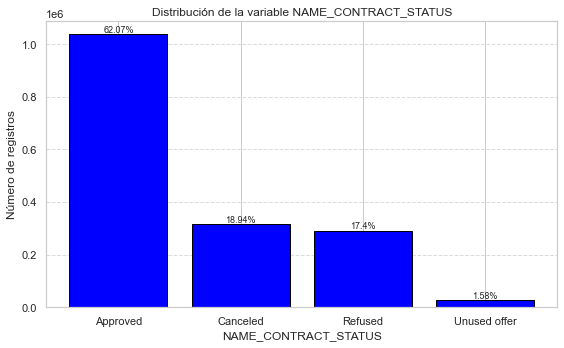

In [174]:
# Se muestra la distribución de la variable CREDIT_ACTIVE
get_variable_distribution(previous_app, 'NAME_CONTRACT_STATUS', 8, 5, 0)

Se muestra el porcentaje de valores nulos por columna.

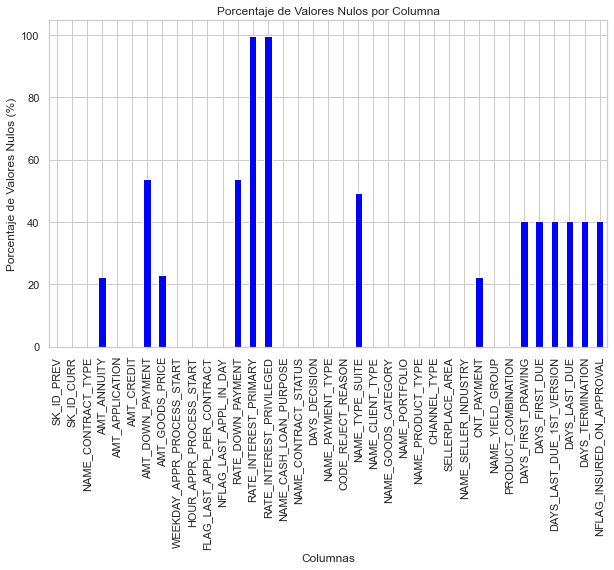

In [51]:
# Se muestran los valores nulos por columna
show_null_values(previous_app, 10, 6, 90)

Como se puede apreciar, se pueden ver varias variables con un alto porcentaje de valores nulos. Dependiendo de si se van a usar o no en nuevas variables a añadir en el proceso de ingeniería de características, es probable que sea necesario tratar esos valores.

Aunque cuenta con muchas variables que podrían ser interesantes, al tener que agrupar los datos por el identificador del crédito en los ficheros *appplication* para integrar los datos en el fichero de datos final, los datos a incluir han de estar agrupados de forma que añadan información relevante. Tenemos solicitudes tanto aprobadas como rechazadas, por lo que se puede sacar datos generales y después datos en función de si el crédito se aprobó o no. Algunas de las variables a incluir podrían ser las siguientes:

- Número de solicitudes previas
- Importe total solicitado
- Promedio del importe solicitado
- Número de solicitudes aprobadas
- Importe total aprobado
- Promedio del Importe aprobado
- Número de solicitudes rechazadas
- Importe total rechazado
- Promedio del Importe rechazado

Se analizará esta y otra información relevante, para añadirla al conjunto de datos final.

#### POS_CASH_balance
En este fichero se almacenan datos relacionados con la evolución de los préstamos (en punto de venta y de efectivo) almacenados en el fichero *previous_application*. Se muestra, en primer lugar, una muestra de los registros del fichero.

In [53]:
# Primeras 5 filas del dataframe POS_CASH_balance
pos_cash_balance.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

El conjunto de datos es pequeño, con solo siete variables, dos de ellas son el identificador del crédito en los ficheros *application* y el identificador del crédito en el fichero *previous_application*. Se muestra a continuación la información del fichero y sus campos.

In [54]:
# Información del dataframe POS_CASH_balance
pos_cash_balance.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   SK_ID_PREV             10001358 non-null  int64  
 1   SK_ID_CURR             10001358 non-null  int64  
 2   MONTHS_BALANCE         10001358 non-null  int64  
 3   CNT_INSTALMENT         9975287 non-null   float64
 4   CNT_INSTALMENT_FUTURE  9975271 non-null   float64
 5   NAME_CONTRACT_STATUS   10001358 non-null  object 
 6   SK_DPD                 10001358 non-null  int64  
 7   SK_DPD_DEF             10001358 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


Se cuenta con información de la posición del préstamo mes a mes y con información de los días de impago, lo que puede ser interesante. Se muestra a continuación, los descriptivos básicos de sus variables numéricas así como las características principales de sus variables categóricas.

In [55]:
# Estadisticos básicos de las variables númericas
pos_cash_balance.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count  1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
mean   1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std    5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min    1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%    1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%    1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%    2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max    2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

       CNT_INSTALMENT_FUTURE        SK_DPD    SK_DPD_DEF  
count           9.975271e+06  1.000136e+07  1.000136e+07  
mean            1.048384e+01  1.160693e+01  6.544684e-01  
std             1.110906e+01  1.327140e+02  3.276249e+01  
min             0.000000e+00  0.000000e+00  0.000000e+00  
25%             3.000000e+00  0.000000e+00  0.000000e+00  
50%             7.000000e+00  0.000000e+00  0.000000e+00  
75%             1.400000e+01  0.000000e+00  0.000000e+00  
max             8.500000e+01  4.231000e+03  3.595000e+03

In [56]:
# Características de las variables categóricas
pos_cash_balance.describe(include="object")

NAME_CONTRACT_STATUS
count              10001358
unique                    9
top                  Active
freq                9151119

Se muestra la distribución de la variable NAME_CONTRACT_STATUS.


Distribución de la variable 'NAME_CONTRACT_STATUS':

                Valor  Conteo  Porcentaje
               Active 9151119       91.50
            Completed  744883        7.45
               Signed   87260        0.87
               Demand    7065        0.07
Returned to the store    5461        0.05
             Approved    4917        0.05
       Amortized debt     636        0.01
             Canceled      15        0.00
                  XNA       2        0.00


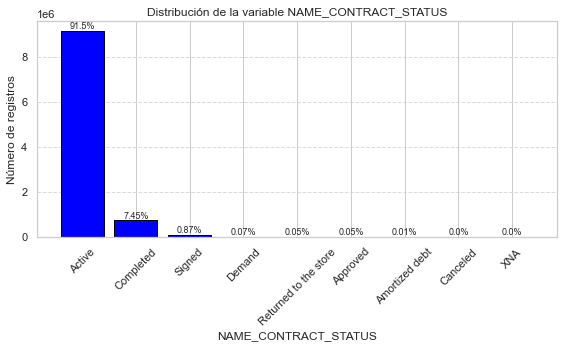

In [175]:
# Se muestra la distribución de la variable CREDIT_ACTIVE
get_variable_distribution(pos_cash_balance, 'NAME_CONTRACT_STATUS', 8, 5, 45)

La variable NAME_CONTRACT_STATUS tiene los siguientes posibles valores:

- Active: El crédito aún está en curso, es decir, el cliente sigue teniendo pagos pendientes.
- Completed: El crédito ha sido pagado en su totalidad y ya no tiene deudas pendientes.
- Signed: El contrato ha sido firmado recientemente, pero aún no ha sido activado (no ha comenzado el desembolso del crédito).
- Demand: El prestamista ha demandado el pago porque el cliente no ha cumplido con las condiciones del contrato.
- Returned to the store: se refiere a un préstamo asociado a una compra (por ejemplo, en una tienda), donde el cliente devolvió el producto y el crédito fue cancelado.
- Approved: El préstamo ha sido aprobado, pero aún no ha sido desembolsado ni activado.
- Canceled: El crédito fue aprobado, pero el cliente decidió no seguir adelante con el préstamo.
- Amortized debt: Indica que el crédito ha sido amortizado progresivamente mediante pagos regulares, pero no está claro si está - completamente liquidado o sigue en curso.
- XNA: Desconocido/No disponible

Se muestra el porcentaje de valores nulos por columna.

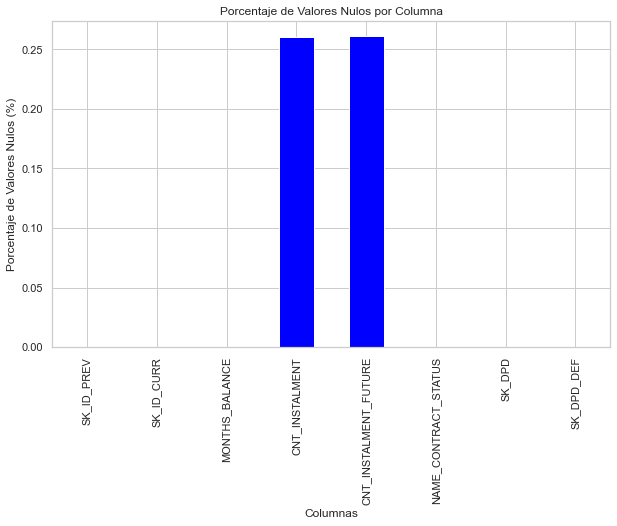

In [53]:
# Se muestran los valores nulos por columna
show_null_values(pos_cash_balance, 10, 6, 90)

Solamente dos variables tienen valores nulos, y son el 25% del total en ambos casos. Como se mencionó anteriormente, si se van a usar en el proceso de ingeniería de características, se tendrán que tratar.

Las posibles variables que se pueden añadir a partir de este fichero pueden ser las siguientes:

- Número de meses con saldo
- Promedio del saldo
- Número de meses con saldo atrasado
- Número de meses con saldo sin atraso
- Promedio de días de atraso

Se analizará esta y otra información relevante, para añadirla al conjunto de datos final.

#### installments_payments
En este fichero se almacena la evolución de la presentación de los recibos de los prestamos anteriores. Se muestra a continuación una muestra de los registros del fichero.

In [57]:
# Primeras 5 filas del dataframe installments_payments
installments.head(5)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

Se trata de un fichero con pocas variables, solamente ocho, todas ellas numéricas. Se muestra a continuación la información del fichero y sus campos.

In [58]:
# Información del dataframe installments_payments
installments.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   SK_ID_PREV              13605401 non-null  int64  
 1   SK_ID_CURR              13605401 non-null  int64  
 2   NUM_INSTALMENT_VERSION  13605401 non-null  float64
 3   NUM_INSTALMENT_NUMBER   13605401 non-null  int64  
 4   DAYS_INSTALMENT         13605401 non-null  float64
 5   DAYS_ENTRY_PAYMENT      13602496 non-null  float64
 6   AMT_INSTALMENT          13605401 non-null  float64
 7   AMT_PAYMENT             13602496 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


Se cuenta con información identificativa del recibo, de los días de presentación y pago, así como del importe del recibo y el importe pagado. Se muestra a continuación, los estadísticos básicos de las variables del fichero.

In [59]:
# Estadisticos básicos de las variables númericas
installments.describe()

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

Se muestra el porcentaje de valores nulos por columna.

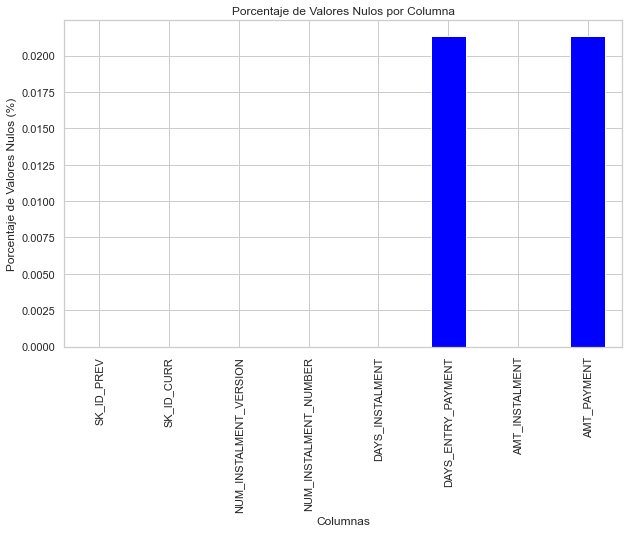

In [54]:
# Se muestran los valores nulos por columna
show_null_values(installments, 10, 6, 90)

Solo dos variables presentan valores nulos y con ratios muy bajos, por debajo del 1%. Además, no todos los registros tienen correspondencia con los registros del *application_train*, por lo que se podrían despreciar.

A la hora de integrar la información de este fichero con los datos de los ficheros *application*, se puede valorar incluir, entre otras, las siguientes variables:

- Número de pagos realizados
- Importe total pagado
- Promedio del importe pagado
- Número de pagos atrasados
- Importe total de pagos atrasados
- Promedio de días de atraso

Se analizará esta y otra información relevante, para añadirla al conjunto de datos final.

#### credit_card_balance
En este fichero se almacena la información relacionada con el comportamiento de tarjetas de crédito, o líneas de crédito, contratadas por el cliente anteriormente en la entidad. Mostramos, en primer lugar, una muestra de los registros del fichero.

In [60]:
# Primeras 5 filas del dataframe credit_card_balance
credit_card.head(5)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

Se trata de un fichero con varias variables numéricas y una variable categórica. Se muestra a continuación la información del fichero y sus campos.

In [61]:
# Información del dataframe credit_card_balance
credit_card.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   SK_ID_PREV                  3840312 non-null  int64  
 1   SK_ID_CURR                  3840312 non-null  int64  
 2   MONTHS_BALANCE              3840312 non-null  int64  
 3   AMT_BALANCE                 3840312 non-null  float64
 4   AMT_CREDIT_LIMIT_ACTUAL     3840312 non-null  int64  
 5   AMT_DRAWINGS_ATM_CURRENT    3090496 non-null  float64
 6   AMT_DRAWINGS_CURRENT        3840312 non-null  float64
 7   AMT_DRAWINGS_OTHER_CURRENT  3090496 non-null  float64
 8   AMT_DRAWINGS_POS_CURRENT    3090496 non-null  float64
 9   AMT_INST_MIN_REGULARITY     3535076 non-null  float64
 10  AMT_PAYMENT_CURRENT         3072324 non-null  float64
 11  AMT_PAYMENT_TOTAL_CURRENT   3840312 non-null  float64
 12  AMT_RECEIVABLE_PRINCIPAL    3840312 non-null  float64
 1

Se cuenta con un total de 22 variables, con el identificador del crédito que se está evaluando, para facilitar la integración, así como el identificador de la aplicación previa. Se entiende que estas tarjetas con líneas de crédito aprobadas. Se muestran los estadísticos básicos de las variables numéricas y las características principales de la variable categórica.

In [62]:
# Estadisticos básicos de las variables númericas
credit_card.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
count              3.090496e+06             3.535076e+06         3.072324e+06   
mean               2.968805e+03             3.540204e+03         1.028054e+04   
std                2.079689e+04             5.600154e+03         3.607808e+04   
min                0.000000e+00             0.000000e+00         0.000000e+00   
25%                0.000000e+00             0.000000e+00         1.523700e+02   
50%                0.000000e+00             0.000000e+00         2.702700e+03   
75%                0.000000e+00             6.633911e+03         9.000000e+03   
max                2.239274e+06             2.028820e+05         4.289207e+06   

       AMT_PAYMENT_TOTAL_CURRENT  AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  \
count               3.840312e+06              3.840312e+06   3.840312e+06   
mean                7.588857e+03              5.596588e+04   5.808881e+04   
std                 3.200599e+04              1.025336e+05   1.059654e+05   
min                 0.000000e+00             -4.233058e+05  -4.202502e+05   
25%                 0.000000e+00              0.000000e+00   0.000000e+00   
50%                 0.000000e+00              0.000000e+00   0.000000e+00   
75%                 6.750000e+03              8.535924e+04   8.889949e+04   
max                 4.278316e+06              1.472317e+06   1.493338e+06   

       AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count          3.840312e+06              3.090496e+06          3.840312e+06   
mean           5.809829e+04              3.094490e-01          7.031439e-01   
std            1.059718e+05              1.100401e+00          3.190347e+00   
min           -4.202502e+05              0.000000e+00          0.000000e+00   
25%            0.000000e+00              0.000000e+00          0.000000e+00   
50%            0.000000e+00              0.000000e+00          0.000000e+00   
75%            8.891451e+04              0.000000e+00          0.000000e+00   
max            1.493338e+06              5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std    

In [63]:
# Características de las variables categóricas
credit_card.describe(include="object")

NAME_CONTRACT_STATUS
count               3840312
unique                    7
top                  Active
freq                3698436

Se muestra la distribución de la variable NAME_CONTRACT_STATUS.


Distribución de la variable 'NAME_CONTRACT_STATUS':

        Valor  Conteo  Porcentaje
       Active 3698436       96.31
    Completed  128918        3.36
       Signed   11058        0.29
       Demand    1365        0.04
Sent proposal     513        0.01
      Refused      17        0.00
     Approved       5        0.00


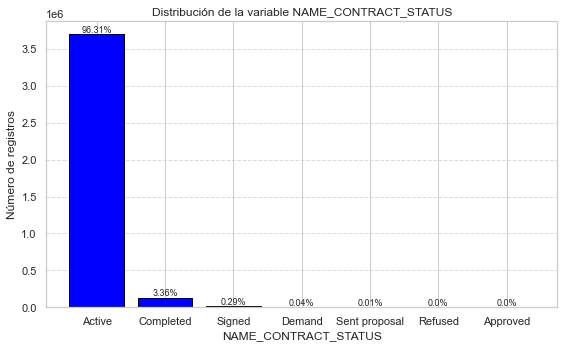

In [176]:
# Se muestra la distribución de la variable CREDIT_ACTIVE
get_variable_distribution(credit_card, 'NAME_CONTRACT_STATUS', 8, 5, 0)

La variable NAME_CONTRACT_STATUS tiene los siguientes posibles valores:

- Active: La tarjeta de crédito sigue abierta y tiene saldo pendiente.
- Completed: El cliente ha pagado completamente la deuda de la tarjeta y la cuenta está cerrada.
- Demand: La entidad financiera ha requerido el pago de la deuda debido a incumplimientos.
- Signed: El contrato de la tarjeta de crédito ha sido firmado, pero el crédito aún no ha sido utilizado o activado.
- Approved: La solicitud de la tarjeta fue aprobada, pero aún no ha sido activada o utilizada.
- Refused: La solicitud de tarjeta de crédito fue denegada por la institución financiera.
- Sent proposal: Se ha enviado una oferta o propuesta de crédito al cliente, pero aún no ha sido aceptada o firmada.

Se muestran los porcentajes de nulos en las columnas del fichero.

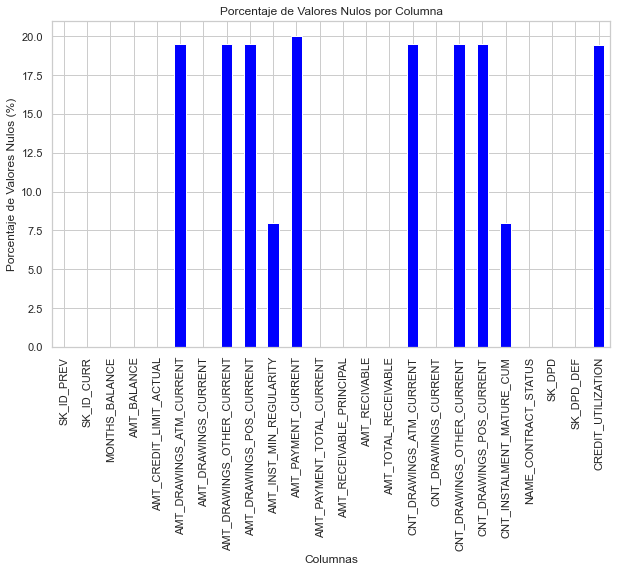

In [178]:
# Se muestran los valores nulos por columna
show_null_values(credit_card, 10, 6, 90)

Existen varias variables con valores nulos, pero por debajo del 20% del total. En base a si van a ser utilizadas, y si existe una alta correspondencia con los registros del fichero *application_train*, se puede valorar el tratar estos nulos.

Las posibles variables que se pueden añadir a partir de este fichero pueden ser las siguientes:

- Número de meses con saldo de tarjeta de crédito
- Promedio del saldo de tarjeta de crédito
- Número de meses con saldo de tarjeta de crédito atrasado
- Número de meses con saldo de tarjeta de crédito sin atraso
- Promedio de días de atraso
- Importe total de crédito utilizado

Se analizará esta y otra información relevante, para añadirla al conjunto de datos final.

### 1.2. Ingeniería de características

Una vez realizado el análisis exploratorio de los datos con los que trabajar, más profundo y detallado en el fichero *application* por ser la base del conjunto de datos definitivo que se va a usar para entrenar el modelo, se pasa a la fase de ingeniería de características. En este punto se van a transformar las variables del conjunto de datos orientando esta tarea a su posterior procesamiento por un modelo de *machine learning*.

En primer lugar, se crea una copia del fichero *app_train* para continuar con el proceso de ingeniería de características.

In [ ]:
# Se copia el dataframe app_train en el dataframe df_cradit_score
df_credit_score = app_train.copy()

A continuación, se van a reducir el número de categorías de las variables categóricas del conjunto de datos *df_credit_score*, siguiendo la lógica que se mostró en el análisis exploratorio de los datos anterior.

En primer lugar, se definen una serie de funciones para realizar los mapeos de valores. Existe la variable HOUR_APPR_PROCESS_START que indica la hora en la que se realiza la solicitud y tiene relación directa con la variable WEEKDAY_APPR_PROCESS_START. Se va a convertir la variable HOUR_APPR_PROCESS_START en una nueva variable llamada HOUR_CAT_APPR_PROCESS_START y se va a eliminar la columna HOUR_APPR_PROCESS_START.

In [53]:
# Función para mapear los valores de la variable OCCUPATION_TYPE
def categorize_occupation_type(occupation):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable OCCUPATION_TYPE

    Parámetros:
    - occupation: (str) valor a mapear de la variable OCCUPATION_TYPE.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if occupation in ['Laborers', 'Low-skill Laborers', 'Drivers', 'Cleaning staff', 'Security staff']:
        return 'Workers'
    elif occupation in ['Sales staff', 'Private service staff', 'Realty agents', 'Cooking staff', 'Waiters/barmen staff']:
        return 'Service_and_commerce'
    elif occupation in ['Secretaries', 'HR staff', 'Accountants', 'Core staff']:
        return 'Finance_and_administration'
    elif occupation in ['High skill tech staff', 'IT staff', 'Medicine staff', 'Managers']:
        return 'Managers_and _technicians'
    else:
        return 'Other' 

    
# Función para mapear los valores de la variable ORGANIZATION_TYPE
def categorize_organization_type(organization):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable ORGANIZATION_TYPE

    Parámetros:
    - organization: (str) valor a mapear de la variable ORGANIZATION_TYPE.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if organization in ['School', 'Government', 'Religion', 'Military', 'Security Ministries', 'Police', 'University', 
                        'Emergency', 'Postal', 'Kindergarten', 'Medicine']:
        return 'Public services'
    elif organization in ['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3', 'Self-employed', 
                          'Legal Services', 'Bank', 'Insurance', 'Realtor', 'Advertising', 'Telecom', 'Mobile']:
        return 'Private business'
    elif organization in ['Construction', 'Electricity', 'Industry: type 1', 'Industry: type 2', 'Industry: type 3', 
                          'Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 'Industry: type 8', 
                          'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 
                          'Industry: type 13', 'Agriculture', 'Housing']:
        return 'Industry and construction'
    elif organization in ['Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 
                          'Trade: type 6', 'Trade: type 7', 'Restaurant', 'Hotel', 'Cleaning', 'Culture', 'Services']:
        return 'Commerce and services'
    elif organization in ['Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4', 'Security']:
        return 'Transport and security'
    else:
        return 'Others' 
    

# Función para mapear los valores de la variable NAME_TYPE_SUITE   
def categorize_name_type_suite(type_suite):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable NAME_TYPE_SUITE

    Parámetros:
    - type_suite: (str) valor a mapear de la variable NAME_TYPE_SUITE.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if type_suite in ['Family', 'Spouse, partner', 'Children']:
        return 'Family'
    elif type_suite in ['Other_A', 'Other_B', 'Group of people']:
        return 'Other'
    else:
        return 'Unaccompanied' 

    
# Función para mapear los valores de la variable NAME_INCOME_TYPE    
def categorize_income_type(income):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable NAME_INCOME_TYPE

    Parámetros:
    - income: (str) valor a mapear de la variable NAME_INCOME_TYPE.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if income in ['Working', 'Pensioner', 'State servant']:
        return 'Salaried'
    elif income in ['Commercial associate', 'Businessman']:
        return 'Self-Employed'
    elif income in ['Unemployed']:
        return 'Unemployed'
    elif income in ['Maternity leave' 'Student']:
        return 'Other'
    else:
        return 'Other'  

    
# Función para mapear los valores de la variable NAME_FAMILY_STATUS 
def categorize_family_status(status):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable NAME_FAMILY_STATUS

    Parámetros:
    - status: (str) valor a mapear de la variable NAME_FAMILY_STATUS.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if status in ['Married', 'Civil marriage']:
        return 'Married'
    elif status in ['Single / not married']:
        return 'Single / not married'
    elif status in ['Widow']:
        return 'Widow'
    elif status in ['Separated']:
        return 'Separated'
    else:
        return 'Other'
    

# Función para mapear los valores de la variable NAME_EDUCATION_TYPE  
def categorize_education_type(education):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable NAME_EDUCATION_TYPE

    Parámetros:
    - education: (str) valor a mapear de la variable NAME_EDUCATION_TYPE.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if education in ['Secondary / secondary special', 'Lower secondary']:
        return 'Secondary'
    elif education in ['Incomplete higher', 'Higher education']:
        return 'Higher'
    elif education in ['Academic degree']:
        return 'Academic degree'
    else:
        return 'Other' 

    
# Función para mapear los valores de la variable NAME_HOUSING_TYPE      
def categorize_house_type(house):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable NAME_HOUSING_TYPE

    Parámetros:
    - house: (str) valor a mapear de la variable NAME_HOUSING_TYPE.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if house in ['House / apartment']:
        return 'Owned'
    elif house in ['Rented apartment']:
        return 'Rented'
    elif house in ['Municipal apartment', 'Co-op apartment']:
        return 'Social'
    elif house in ['With parents', 'Office apartment']:
        return 'Other'
    else:
        return 'Other'  

# Función para mapear los valores de la variable WEEKDAY_APPR_PROCESS_START     
def categorize_weekday(day):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable WEEKDAY_APPR_PROCESS_START

    Parámetros:
    - day: (str) valor a mapear de la variable WEEKDAY_APPR_PROCESS_START.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if day in ['WEDNESDAY', 'MONDAY', 'TUESDAY', 'THURSDAY', 'FRIDAY']:
        return 'WEEKDAY'
    elif day in ['SUNDAY', 'SATURDAY']:
        return 'WEEKEND'
    else:
        return 'Other'
    
# Función para mapear los valores de la variable HOUR_APPR_PROCESS_START
def categorize_hour(hour):
    """
    Función que obtiene el valor de la reclasificación de los valores de la 
    variable HOUR_APPR_PROCESS_START

    Parámetros:
    - hour: (int) valor a mapear de la variable HOUR_APPR_PROCESS_START.
    
    Devuelve: el valor mapeado con la nueva clasificación.
    """
    if 0 <= hour < 6:
        return 'Madrugada'
    elif 6 <= hour < 12:
        return 'Mañana'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noche'

Se mapean los valores y se muestran las variables con sus nuevas categorizaciones.

In [54]:
# Se reemplazan los valores en la columna ORGANIZATION_TYPE
df_credit_score['ORGANIZATION_TYPE'] =  df_credit_score['ORGANIZATION_TYPE'].apply(categorize_organization_type)
print('Categorías de la variable ORGANIZATION_TYPE')
print(df_credit_score['ORGANIZATION_TYPE'].value_counts())
print('************************************')

# Se reemplazan los valores en la columna OCCUPATION_TYPE
df_credit_score['OCCUPATION_TYPE'] =  df_credit_score['OCCUPATION_TYPE'].apply(categorize_occupation_type)
print('Categorías de la variable OCCUPATION_TYPE')
print(df_credit_score['OCCUPATION_TYPE'].value_counts())
print('************************************')

# Se reemplazan los valores en la columna NAME_TYPE_SUITE
df_credit_score['NAME_TYPE_SUITE'] =  df_credit_score['NAME_TYPE_SUITE'].apply(categorize_name_type_suite)
print('Categorías de la variable NAME_TYPE_SUITE')
print(df_credit_score['NAME_TYPE_SUITE'].value_counts())
print('************************************')

# Se reemplazan los valores en la columna NAME_INCOME_TYPE
df_credit_score['NAME_INCOME_TYPE'] =  df_credit_score['NAME_INCOME_TYPE'].apply(categorize_income_type)
print('Categorías de la variable NAME_INCOME_TYPE')
print(df_credit_score['NAME_INCOME_TYPE'].value_counts())
print('************************************')

# Se reemplazan los valores en la columna NAME_FAMILY_STATUS
df_credit_score['NAME_FAMILY_STATUS'] =  df_credit_score['NAME_FAMILY_STATUS'].apply(categorize_family_status)
print('Categorías de la variable NAME_FAMILY_STATUS')
print(df_credit_score['NAME_FAMILY_STATUS'].value_counts())
print('************************************')

# Se reemplazan los valores en la columna NAME_EDUCATION_TYPE
df_credit_score['NAME_EDUCATION_TYPE'] =  df_credit_score['NAME_EDUCATION_TYPE'].apply(categorize_education_type)
print('Categorías de la variable NAME_EDUCATION_TYPE')
print(df_credit_score['NAME_EDUCATION_TYPE'].value_counts())
print('************************************')

# Se reemplazan los valores en la columna NAME_HOUSING_TYPE
df_credit_score['NAME_HOUSING_TYPE'] =  df_credit_score['NAME_HOUSING_TYPE'].apply(categorize_house_type)
print('Categorías de la variable NAME_HOUSING_TYPE')
print(df_credit_score['NAME_HOUSING_TYPE'].value_counts())
print('************************************')
     
# Se reemplazan los valores en la columna WEEKDAY_APPR_PROCESS_START
df_credit_score['WEEKDAY_APPR_PROCESS_START'] =  df_credit_score[
    'WEEKDAY_APPR_PROCESS_START'].apply(categorize_weekday)
print('Categorías de la variable WEEKDAY_APPR_PROCESS_START')
print(df_credit_score['WEEKDAY_APPR_PROCESS_START'].value_counts())
print('************************************')  

Categorías de la variable ORGANIZATION_TYPE
ORGANIZATION_TYPE
Private business             183443
Public services               48447
Industry and construction     27394
Commerce and services         19306
Others                        16683
Transport and security        12237
Name: count, dtype: int64
************************************
Categorías de la variable OCCUPATION_TYPE
OCCUPATION_TYPE
Workers                       183647
Service_and_commerce           42799
Managers_and _technicians      41814
Finance_and_administration     39250
Name: count, dtype: int64
************************************
Categorías de la variable NAME_TYPE_SUITE
NAME_TYPE_SUITE
Unaccompanied    249818
Family            54785
Other              2907
Name: count, dtype: int64
************************************
Categorías de la variable NAME_INCOME_TYPE
NAME_INCOME_TYPE
Salaried         235838
Self-Employed     71627
Other                23
Unemployed           22
Name: count, dtype: int64
***************

Se convierte la variable HOUR_APPR_PROCESS_START en categórica y sus valores se van a transformar en un rango con 4 valores: Madrugada, Mañana, Tarde y Noche.

In [55]:
# Se crea la nueva variable categórica
df_credit_score['HOUR_CAT_APPR_PROCESS_START'] = df_credit_score['HOUR_APPR_PROCESS_START'].apply(categorize_hour)

# Se elimina la variable anterior
df_credit_score = df_credit_score.drop(columns=['HOUR_APPR_PROCESS_START'])

# Convertir a categórica explícitamente (opcional, para modelado)
df_credit_score['HOUR_CAT_APPR_PROCESS_START'] = df_credit_score['HOUR_CAT_APPR_PROCESS_START'].astype('object')

Por otro lado, existe la variable REGION_POPULATION_RELATIVE, que establece una clasificación en base a la densidad de población de la región donde vive el cliente. Se va a transformar esa variable en categórica y se va a mapear a una serie de valores más interpretables. El rango a utilizar es el siguiente:

- 0 - 0.01: muy baja
- 0.01 - 0.02: baja
- 0.02 - 0.03: media
- 0.03 - 0.05: alta
- 0.05 - máximo valor: muy alta

In [56]:
# Obtener el valor máximo real de la variable
max_value = df_credit_score['REGION_POPULATION_RELATIVE'].max()

# Definir los límites de los bins y las etiquetas
bins = [0, 0.01, 0.02, 0.03, 0.05, max_value + 0.001]
labels = ['Muy Baja', 'Baja', 'Media', 'Alta', 'Muy Alta']

# Crear una nueva columna categórica
df_credit_score['REGION_POPULATION_CATEGORY'] = pd.cut(df_credit_score['REGION_POPULATION_RELATIVE'], bins=bins, labels=labels)

# Verificar la nueva variable categórica
df_credit_score[['REGION_POPULATION_RELATIVE', 'REGION_POPULATION_CATEGORY']].head(10)

REGION_POPULATION_RELATIVE REGION_POPULATION_CATEGORY
0                    0.018801                       Baja
1                    0.003541                   Muy Baja
2                    0.010032                       Baja
3                    0.008019                   Muy Baja
4                    0.028663                      Media
5                    0.035792                       Alta
6                    0.035792                       Alta
7                    0.003122                   Muy Baja
8                    0.018634                       Baja
9                    0.019689                       Baja

In [57]:
# Se elimina el campo continuo
df_credit_score = df_credit_score.drop(columns=['REGION_POPULATION_RELATIVE'])

In [58]:
# Se establece la variable nueva como categórica
df_credit_score['REGION_POPULATION_CATEGORY'] = df_credit_score['REGION_POPULATION_CATEGORY'].astype('object')

In [59]:
# Se revisan las variables categóricas para certificar que se ha creado 
# correctamente la nueva variable REGION_POPULATION_CATEGORY
categorical_variables = df_credit_score.select_dtypes(include=["object"]).columns.tolist()
categorical_variables

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUR_CAT_APPR_PROCESS_START',
 'REGION_POPULATION_CATEGORY']

Para analizar mejor los resultados obtenidos, se vuelve a graficar la distribución de las variables para ver como quedan después de las agrupaciones.

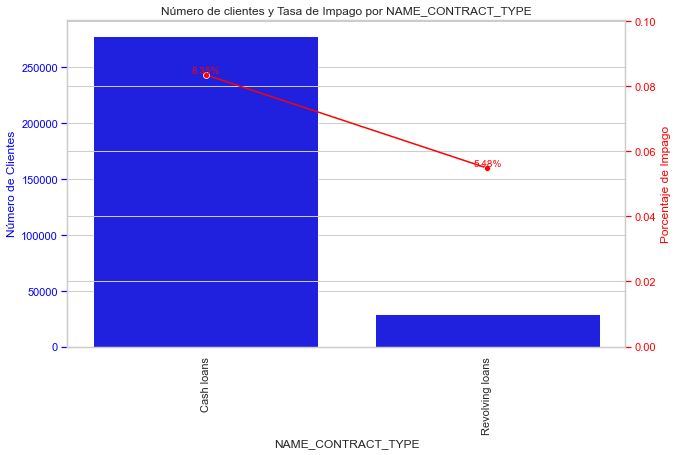

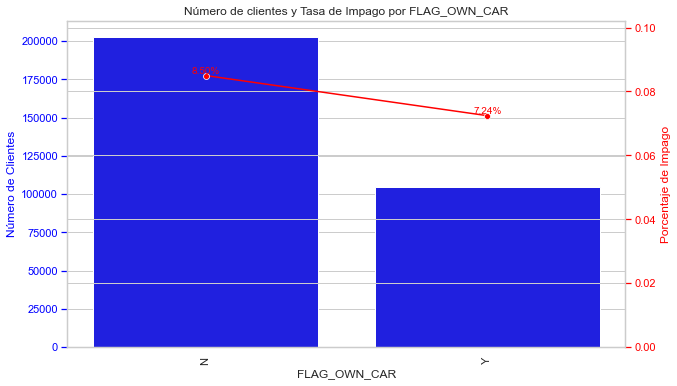

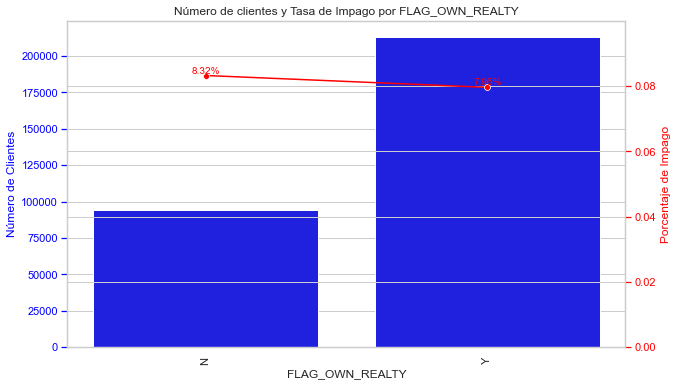

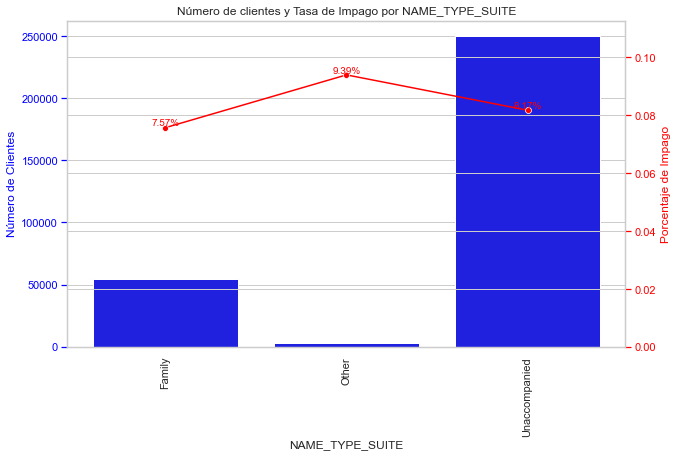

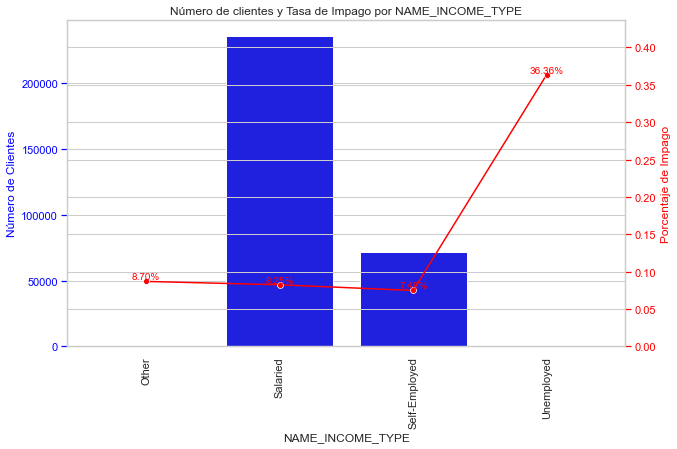

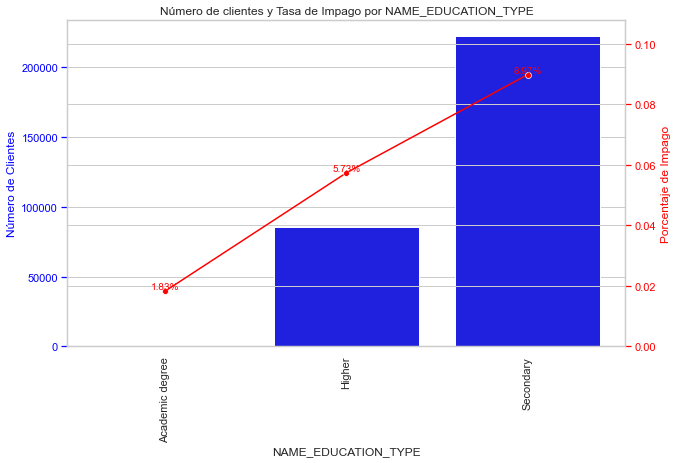

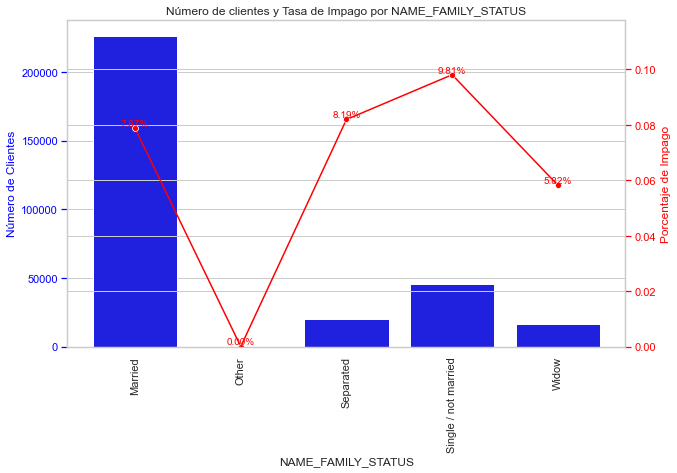

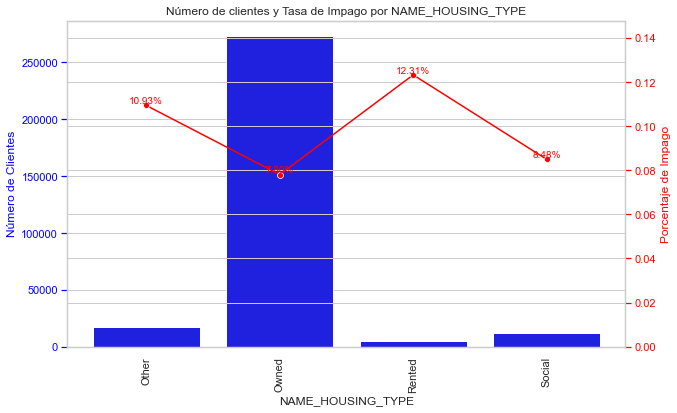

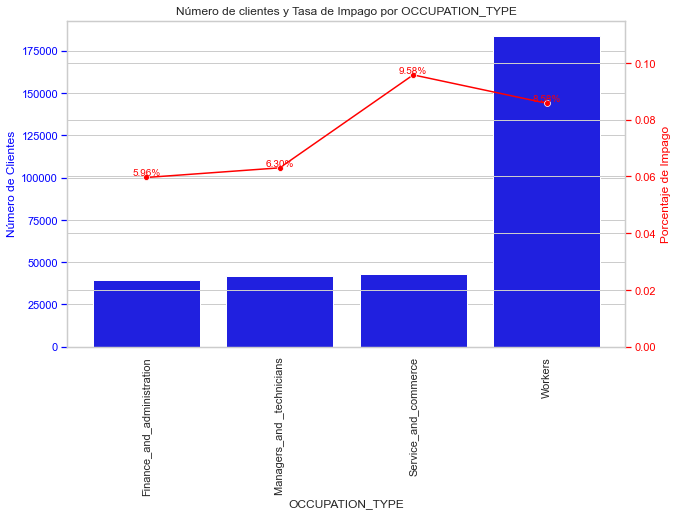

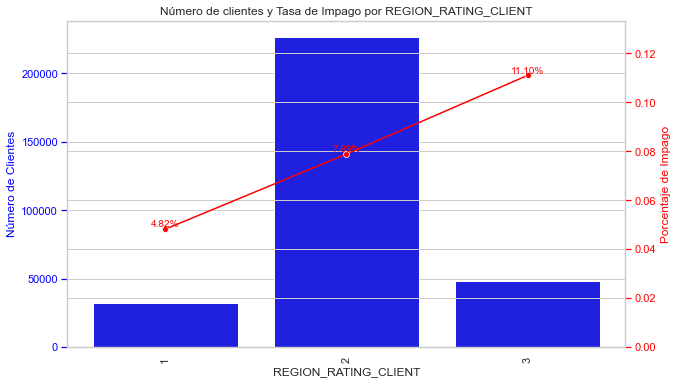

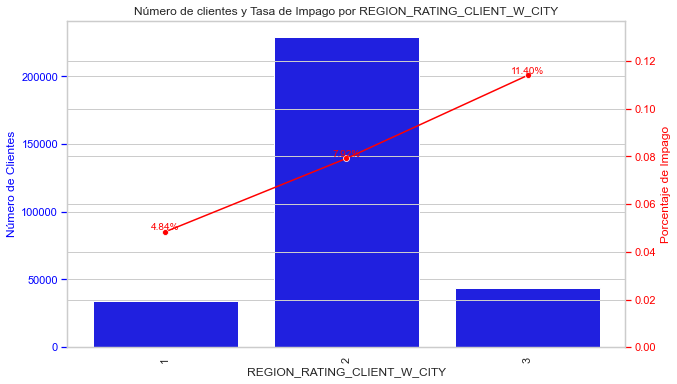

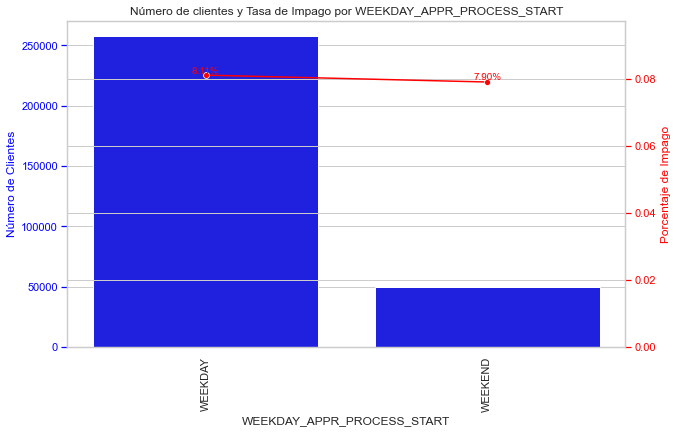

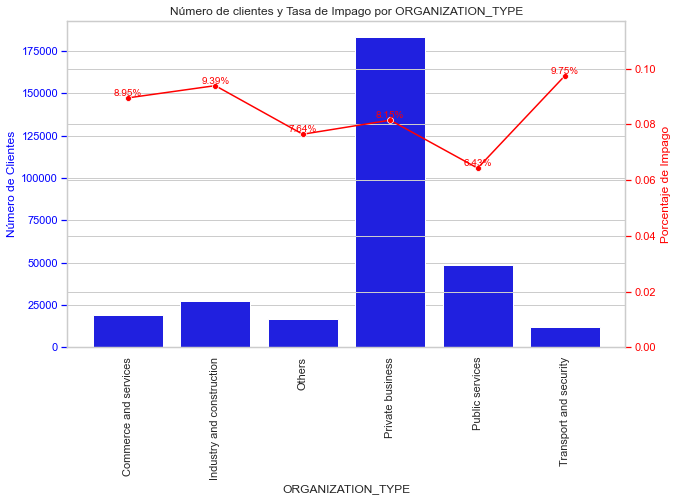

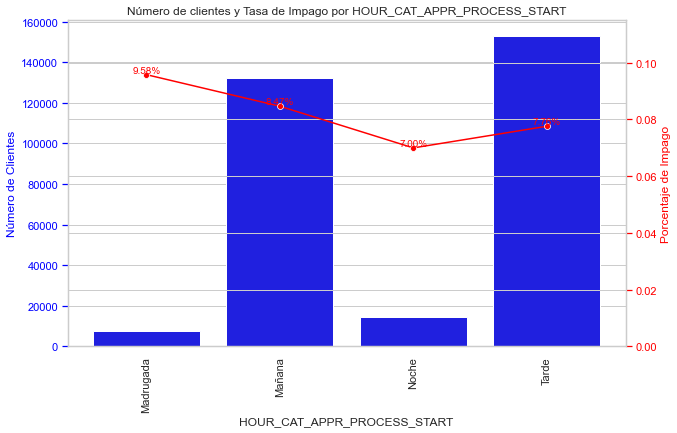

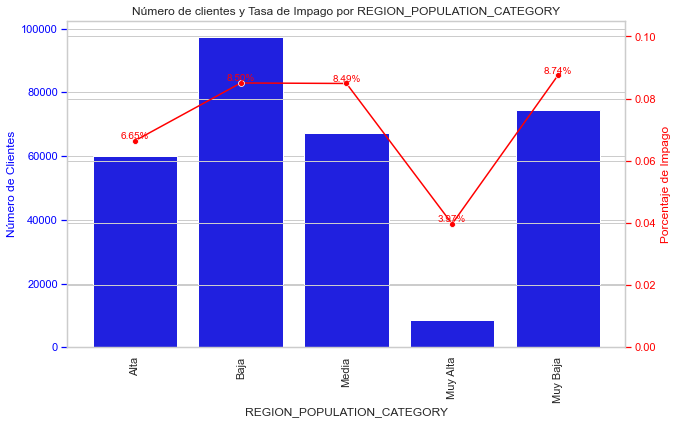

In [60]:
# Recorremos las variables categóricas a excepción de OCCUPATION_TYPE y ORGANIZATION_TYPE
# para mostrar la proporción de sus categorías
for column in categorical_variables:
    get_default_by_category(column, df_credit_score, 10, 6, 90)

Una vez mapeados los valores de las variables categóricas, continuamos con el proceso de ingeniería de características. Las variables FLAG_DOCUMENT_ se van a consolidar en una sola variable con la media de valores a 1, que representan el número de documentos presentados sobre el total. A continuación, se borran las variables FLAG_DOCUMENT_.

In [61]:
# Se crea una nueva variable con el número de los documentos presentados
df_credit_score['DOCUMENTS'] = df_credit_score[['FLAG_DOCUMENT_21','FLAG_DOCUMENT_20','FLAG_DOCUMENT_19',
'FLAG_DOCUMENT_18','FLAG_DOCUMENT_17','FLAG_DOCUMENT_16','FLAG_DOCUMENT_15','FLAG_DOCUMENT_14','FLAG_DOCUMENT_13',
'FLAG_DOCUMENT_12','FLAG_DOCUMENT_11','FLAG_DOCUMENT_10','FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_8', 
'FLAG_DOCUMENT_7','FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_2']].sum(axis=1)

# Se eliminan las variables FLAG_DOCUMENT_
# Lista de columnas a eliminar
columns_to_drop = ['FLAG_DOCUMENT_21','FLAG_DOCUMENT_20','FLAG_DOCUMENT_19',
'FLAG_DOCUMENT_18','FLAG_DOCUMENT_17','FLAG_DOCUMENT_16','FLAG_DOCUMENT_15','FLAG_DOCUMENT_14','FLAG_DOCUMENT_13',
'FLAG_DOCUMENT_12','FLAG_DOCUMENT_11','FLAG_DOCUMENT_10','FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_8', 
'FLAG_DOCUMENT_7','FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_2']

# Se eliminan las columnas del DataFrame
df_credit_score = df_credit_score.drop(columns=columns_to_drop)

A continuación, se van a transformar las variables categóricas en variables numéricas. En el caso que nos ocupa, tenemos tanto variables dicotómicas (con dos valores), como variables con múltiples categorías. En este caso, vamos a utilizar dos métodos diferentes:

- Para las variables dicotómicas, se va a usar *Label Encoding* (sklearn.preprocessing).
- Para las variables con múltiples categorías, se va a usar *One Hot Encoding* (método de pandas *get_dummies*).

La variable NAME_CONTRACT_TYPE tiene dos posibles valores: *Cash Loans* y *Revolving loans*. Se pretende que en esta variable se identifique con 1 a los créditos y con 0 a las tarjetas. El método *fit_transform()* de *LabelEncoder* asigna los valores por orden alfabético, es decir, en este caso asignara el 0 a los créditos, y no es lo que se quiere. Por eso, esa variable no se va a codificar con esa función y se va a recodificar explícitamente. En el resto de las variables dicotómicas, la función *fit_transform()* asignara el 1 a los *Y* o *Yes* y el 0 a los *N* o *No*, por lo que se usara esa función. Al hacer *One Hot Encoding* se puede eliminar una de las categorías, ya que se puede inferir del resto. En este caso no lo vamos a hacer porque queremos ver la correlación de cada una de las variables con la variable objetivo.

A la variable NAME_CONTRACT_TYPE se le cambia el nombre a FLAG_IS_LOAN.

In [62]:
# Se instancia el objeto LabelEncoder
le = LabelEncoder()

# Recorremos las varibles categóricas del conjunto de datos
for column in categorical_variables:
    if column == 'NAME_CONTRACT_TYPE':
        # Si la columna es NAME_CONTRACT_TYPE hacemos el label encoding manualmente
        df_credit_score[column] = df_credit_score[column].map({'Cash loans': 1, 'Revolving loans': 0})
    elif len(df_credit_score[column].value_counts()) == 2:
        # Si la columna no es NAME_CONTRACT_TYPE y es dicotómica hacemos label encoding
        df_credit_score[column] = le.fit_transform(df_credit_score[column])
    else:
        # Si es una variable multicategórica, se hace one hot encoding
        df_credit_score = pd.get_dummies(df_credit_score, columns=[column], dtype=int)
        
# Se renombran las columnas NAME_CONTRACT_TYPE
df_credit_score.rename(columns={'NAME_CONTRACT_TYPE': 'FLAG_IS_LOAN'}, inplace=True)

Centrando en análisis en las variables de score externas, vamos a analizar la correlación de estas con la variable objetivo.

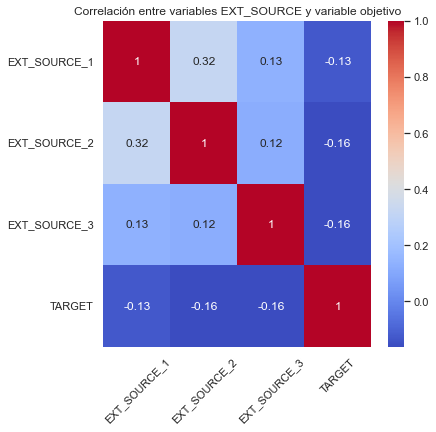

In [63]:
# Se muestra la correlación de las variables EXT_SOURCE con la variable objetivo
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(df_credit_score[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET']].corr(), 
            annot=True, cmap="coolwarm")
plt.title("Correlación entre variables EXT_SOURCE y variable objetivo")
plt.xticks(rotation=45)
plt.show()

Las tres variables de score externas no tienen la misma importancia respecto a su correlación con la variable objetivo, por lo que se van a ponderar para asignar más peso a la que más correlacionada está con esta última. para obtener el peso más adecuado para cada variable, se va a analizar su importancia respecto a la variable objetivo utilizando la significancia de cada una de ellas respecto a un modelo Gradient Boosting.

In [64]:
# Se selccionan las variables a tratar y se crean los conjuntos de entrenamiento y test
X_ext = df_credit_score[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].dropna()
y_ext = df_credit_score.loc[X_ext.index, 'TARGET']

# Se entrena el modelo
model_ext = GradientBoostingClassifier().fit(X_ext, y_ext)
# Se obtienen los pesos
importances = model_ext.feature_importances_

# Se normalizan los pesos para aplicarlos a continuación
weights = importances / importances.sum()  # Normalizar
# Se muestran los pesos
print(weights)

[0.16888471 0.37406861 0.45704668]


Como se ha visto, se ha de ponderar la variable EXT_SOURCE_3 por encima del resto, seguida de la variable EXT_SOURCE_2 y siendo la variable EXT_SOURCE_1 la que reciba menor ponderación. Se usarán estos pesos a la hora de ponderar alguna de las variables nuevas a crear.

A continuación, se van a añadir una serie de variables al conjunto de datos *df_credit_score* a partir de las variables ya existentes. En algunos casos, se trata de variables derivadas de las variables de score externo EXT_SOURCE_1, EXT_SOURCE_2 y EXT_SOURCE_3. En otros casos se ha intentado obtener variables que estén relacionadas con las anteriores en función de otras que también se consideran relevantes. Las variables que se van a añadir son las siguientes:

- EXT_SOURCE_MUL: multiplicación de las variables de score del préstamo.
- EXT_SOURCE_MAX: máximo valor de las variables de score del préstamo.
- EXT_SOURCE_MIN: mínimo valor de las variables de score del préstamo.
- EXT_SOURCE_MED: mediana de las variables de score del préstamo.
- EXT_SOURCE_STD: desviación estándar de las variables de score del préstamo.
- EXT_SOURCE_VAR: varianza de las variables de score del préstamo.
- EXT_SOURCE_SUM: suma de las variables de score del préstamo.
- EXT_SOURCE_MEAN: media de las variables de score del préstamo.
- WEIGHTED_EXT_SOURCE: producto ponderado de las variables de score del préstamo. Se le da más peso a la más correlacionada con la variable objetivo. Los pesos son los calculados en el paso anterior.
- EXT_SOURCE_1_RATIO: relevancia del score EXT_SOURCE_1 sobre la suma de las tres notas de score.
- EXT_SOURCE_2_RATIO: relevancia del score EXT_SOURCE_2 sobre la suma de las tres notas de score.
- EXT_SOURCE_3_RATIO: relevancia del score EXT_SOURCE_3 sobre la suma de las tres notas de score.
- ANNUITY_INCOME_PERCENT: carga sobre ingreso del préstamo.
- CREDIT_ANNUITY_RATIO: ratio del importe del crédito sobre la anualidad.
- DAYS_EMPLOYED_RATIO: porcentaje de día trabajados por el solicitante sobre el total de su vida.
- CREDIT_GOODS_RATIO: porcentaje del bien cubierto por el préstamo.
- CREDIT_DOWNPAYMENT: ratio del precio del bien sobre el importe del crédito solicitado.
- CREDIT_INCOME_RATIO: ratio del importe del crédito sobre el importe de los ingresos.
- AGE_YEARS: edad del solicitante en años.
- EMPLOYED_YEARS: tiempo trabajando del solicitante en años.
- CREDIT_YEARS_RATIO: ratio del importe del crédito sobre la edad del solicitante.
- CREDIT_EMPLOYED_RATIO: ratio del importe del crédito sobre el tiempo trabajado del solicitante.
- EXT_SOURCE_MEAN_AGE: media de los scores por la edad.
- EXT_SOURCE_MEAN_EMPLOYED: media de los scores por el tiempo trabajado.
- EXT_SOURCE_MEAN_CREDIT_INCOME_RATIO: producto de la media de los scores y el tiempo necesario para pagar el crédito con el sueldo total.
- EXT_SOURCE_MEAN_ANNUITY_INCOME_RATIO: producto de la media de los scores y la carga sobre ingresos.
- EXT_SOURCE_DIFF: diferencia entre el máximo score y el mínimo.

In [65]:
# Se añaden las variables a partir de datos del fichero *application*
# Se ha comprobado que las variables de los scores externos son las más correlacionadas
# con la variable objetivo, por lo que se combinan para obtener diferentes variables

# Se preseleccionan las variables EXT_SOURCE
ext_sources = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

#Se calculan las variables relaciondas con los scores externos
df_credit_score['EXT_SOURCE_MUL'] = df_credit_score[ext_sources].prod(axis=1)
df_credit_score['EXT_SOURCE_MAX'] = df_credit_score[ext_sources].max(axis=1)
df_credit_score['EXT_SOURCE_MIN'] = df_credit_score[ext_sources].min(axis=1)
df_credit_score['EXT_SOURCE_MED'] = df_credit_score[ext_sources].median(axis=1)
df_credit_score['EXT_SOURCE_STD'] = df_credit_score[ext_sources].std(axis=1)
df_credit_score['EXT_SOURCE_VAR'] = df_credit_score[ext_sources].var(axis=1)
df_credit_score['EXT_SOURCE_SUM'] = df_credit_score[ext_sources].sum(axis=1)
df_credit_score['EXT_SOURCE_MEAN'] = df_credit_score[ext_sources].mean(axis=1)
# Se pondera cada variable en función de su correlación con la variable objetivo
df_credit_score['WEIGHTED_EXT_SOURCE'] = (df_credit_score['EXT_SOURCE_1'] * weights[0] +
                                          df_credit_score['EXT_SOURCE_2'] * weights[1] +
                                          df_credit_score['EXT_SOURCE_3'] * weights[2])

# Promedios de cada una de las variables sobre la suma del resto
df_credit_score['EXT_SOURCE_1_RATIO'] = df_credit_score['EXT_SOURCE_1'
                                                       ] / df_credit_score[['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                            'EXT_SOURCE_3']].sum(axis = 1)
df_credit_score['EXT_SOURCE_2_RATIO'] = df_credit_score['EXT_SOURCE_2'
                                                       ] / df_credit_score[['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                            'EXT_SOURCE_3']].sum(axis = 1)
df_credit_score['EXT_SOURCE_3_RATIO'] = df_credit_score['EXT_SOURCE_3'
                                                       ] / df_credit_score[['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                            'EXT_SOURCE_3']].sum(axis = 1)

# Se calculan otras variables relevantes
# carga sobre ingreso del préstamo
df_credit_score['ANNUITY_INCOME_RATIO'] = df_credit_score['AMT_ANNUITY'] / df_credit_score['AMT_INCOME_TOTAL']
# duración del préstamo en años
df_credit_score['CREDIT_ANNUITY_RATIO'] = df_credit_score['AMT_CREDIT']/df_credit_score['AMT_ANNUITY']
# porcentaje de día trabajados por el solicitante
df_credit_score['DAYS_EMPLOYED_RATIO'] = df_credit_score['DAYS_EMPLOYED'] / df_credit_score['DAYS_BIRTH']
# porcentaje del bien cubierto por el préstamo    
df_credit_score['CREDIT_GOODS_RATIO'] = df_credit_score['AMT_CREDIT'] / df_credit_score['AMT_GOODS_PRICE'] 
# porcentaje del préstamo sobre el precio del bien 
df_credit_score['CREDIT_DOWNPAYMENT'] = df_credit_score['AMT_GOODS_PRICE'] - df_credit_score['AMT_CREDIT']
# sueldo anual necesario para pagar el préstamo
df_credit_score['CREDIT_INCOME_RATIO'] = df_credit_score['AMT_CREDIT'] / df_credit_score['AMT_INCOME_TOTAL']
# edad del soliciante en años
df_credit_score['AGE_YEARS'] = df_credit_score['DAYS_BIRTH'] / -365        
# tiempo trabajando del solicitante en años
df_credit_score['EMPLOYED_YEARS'] = df_credit_score['DAYS_EMPLOYED'] / -365
# ratio entre el credito y la edad
df_credit_score['CREDIT_YEARS_RATIO'] = df_credit_score['AMT_CREDIT'] / df_credit_score['AGE_YEARS']
# ratio entre el credito y el tiempo trabajado
df_credit_score['CREDIT_EMPLOYED_RATIO'] = df_credit_score['AMT_CREDIT'] / df_credit_score['EMPLOYED_YEARS']

# Variables derivadas de las calculadas sobre los scores externos
# media de los scores entre la edad
df_credit_score['EXT_SOURCE_MEAN_AGE'] = df_credit_score['EXT_SOURCE_MEAN'] * df_credit_score['AGE_YEARS']
# media de los scores entre el tiempo trabajado
df_credit_score['EXT_SOURCE_MEAN_EMPLOYED'] = df_credit_score['EXT_SOURCE_MEAN'] * df_credit_score['EMPLOYED_YEARS']
# ratio entre la media de los scores y el tiempo necesario para pagar el credito con el sueldo total
df_credit_score['EXT_SOURCE_MEAN_CREDIT_INCOME_RATIO'] = df_credit_score['EXT_SOURCE_MEAN'
                                                                        ] * df_credit_score['CREDIT_INCOME_RATIO']
# ratio entre la media de los scores y la carga sobre ingresos
df_credit_score['EXT_SOURCE_MEAN_ANNUITY_INCOME_RATIO'] = df_credit_score['EXT_SOURCE_MEAN'
                                                                         ] * df_credit_score['ANNUITY_INCOME_RATIO']
# diferencia entre el máximo score y el mínimo
df_credit_score['EXT_SOURCE_DIFF'] = df_credit_score['EXT_SOURCE_MAX'] - df_credit_score['EXT_SOURCE_MIN']

Se eliminan las variables DAYS_BIRTH y DAYS_EMPLOYED por tener la misma correlación con la variable objetivo que las variables AGE_YEARS y EMPLOYED_YEARS

In [66]:
# Se eliminan las variables DAYS_BIRTH y DAYS_EMPLOYED
df_credit_score = df_credit_score.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED']) 

La nuevas variable basadas en scores externos EXT_SOURCE pueden tener una alta correlación con las variables EXT_SOURCE. Se muestra la correlación entre todas las variables generadas y la variable TARGET para valorar su eliminación.

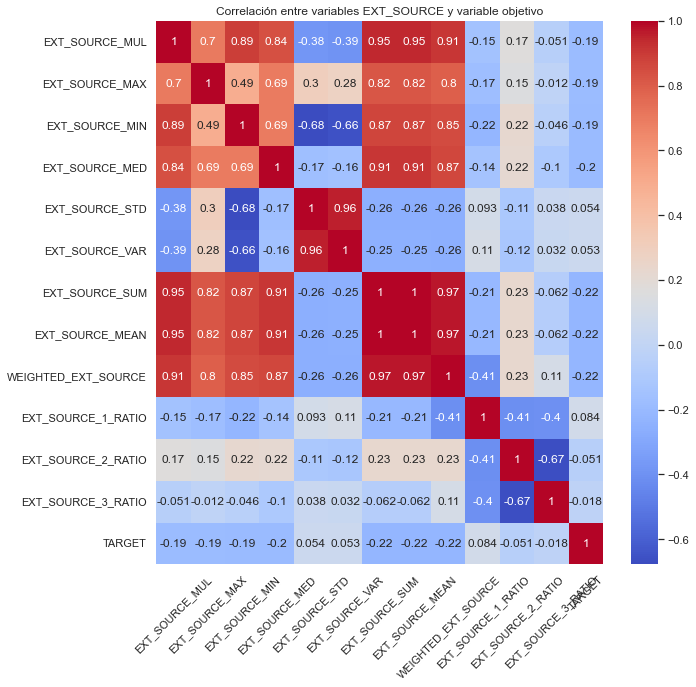

In [67]:
# Se muestra la correlación de las variables EXT_SOURCE con la variable objetivo
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_credit_score[['EXT_SOURCE_MUL',
'EXT_SOURCE_MAX','EXT_SOURCE_MIN','EXT_SOURCE_MED','EXT_SOURCE_STD','EXT_SOURCE_VAR','EXT_SOURCE_SUM',
'EXT_SOURCE_MEAN','WEIGHTED_EXT_SOURCE','EXT_SOURCE_1_RATIO','EXT_SOURCE_2_RATIO',
'EXT_SOURCE_3_RATIO','TARGET']].corr(), 
            annot=True, cmap="coolwarm")
plt.title("Correlación entre variables EXT_SOURCE y variable objetivo")
plt.xticks(rotation=45)
plt.show()

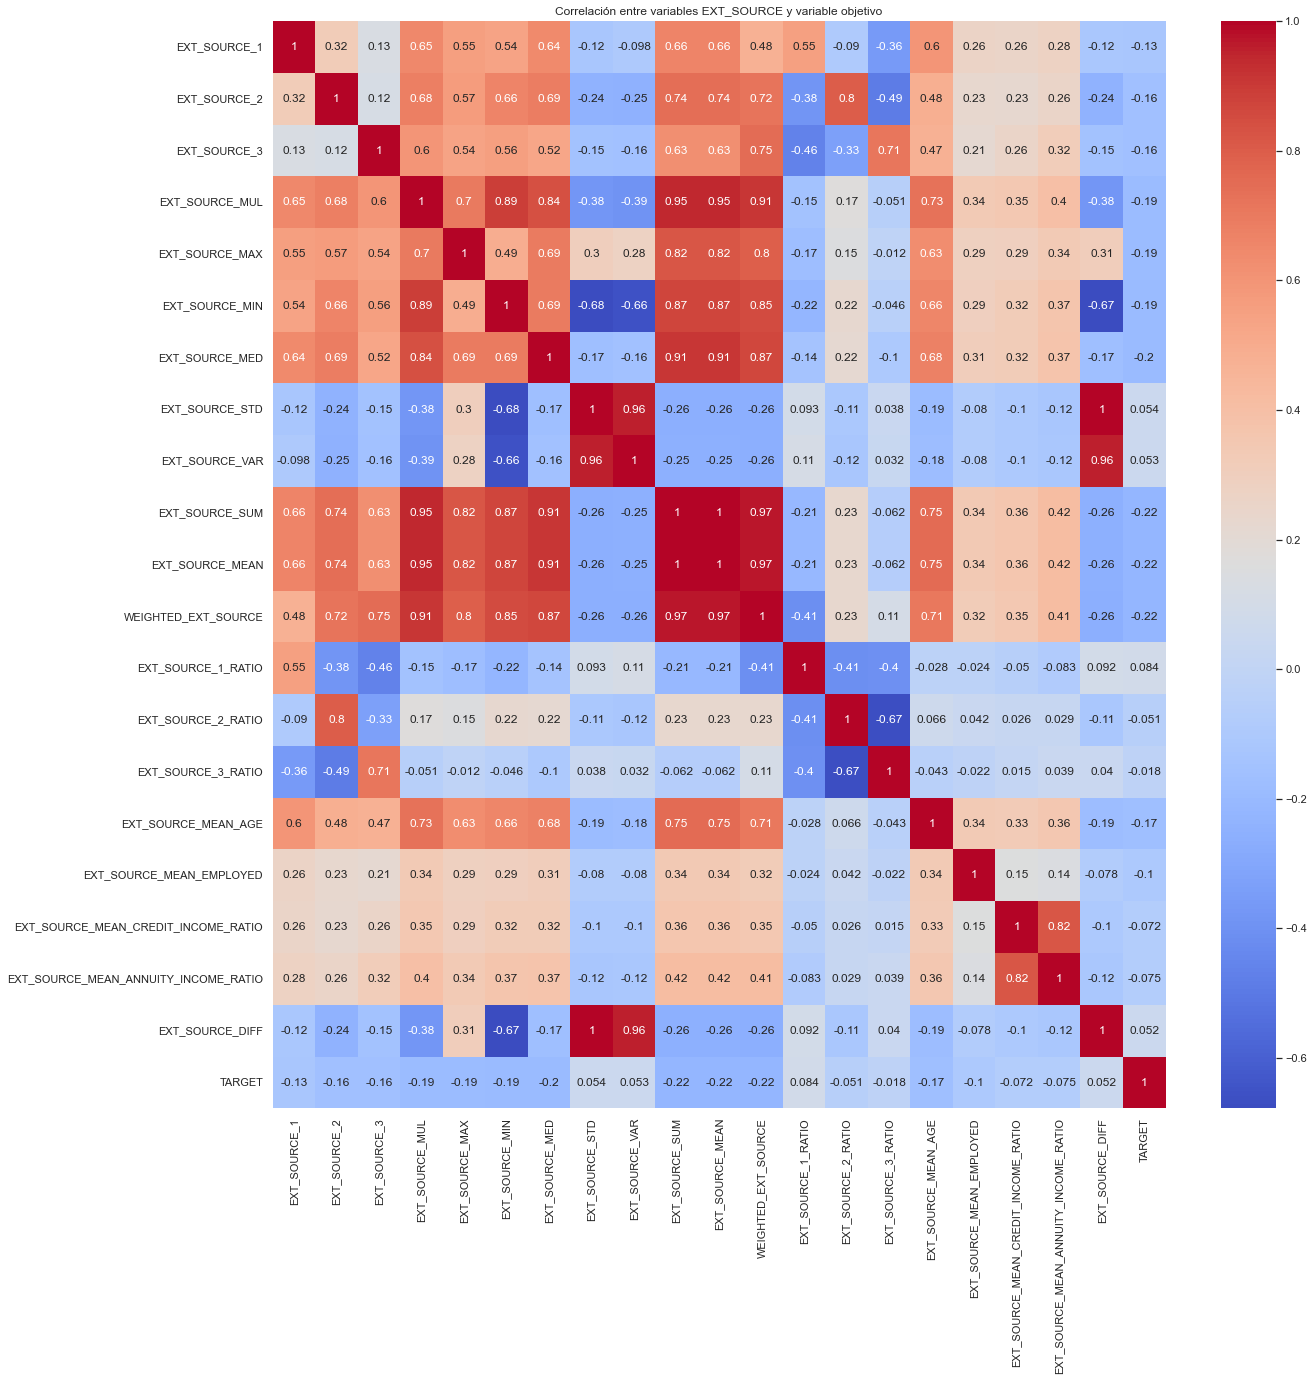

In [68]:
# Se muestra la correlación de las variables EXT_SOURCE con la variable objetivo
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_credit_score[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','EXT_SOURCE_MUL',
'EXT_SOURCE_MAX','EXT_SOURCE_MIN','EXT_SOURCE_MED','EXT_SOURCE_STD','EXT_SOURCE_VAR','EXT_SOURCE_SUM',
'EXT_SOURCE_MEAN','WEIGHTED_EXT_SOURCE','EXT_SOURCE_1_RATIO','EXT_SOURCE_2_RATIO',
'EXT_SOURCE_3_RATIO','EXT_SOURCE_MEAN_AGE','EXT_SOURCE_MEAN_EMPLOYED','EXT_SOURCE_MEAN_CREDIT_INCOME_RATIO',
'EXT_SOURCE_MEAN_ANNUITY_INCOME_RATIO','EXT_SOURCE_DIFF','TARGET']].corr(), 
            annot=True, cmap="coolwarm")
plt.title("Correlación entre variables EXT_SOURCE y variable objetivo")
plt.show()

Se puede apreciar que algunas de las variables están altamente correlacionadas entre sí. Posteriormente se eliminaran variables que no aporten nada debido a su alta correlación entre sí, y como consecuencia pueden viciar el análisis.

A continuación, y para incluir nuevas variables que permitan identificar o establecer vinculaciones más fuertes entre el conjunto de datos y la variable objetivo, se van a añadir diferentes variables calculadas a partir del resto de ficheros que forman el conjunto de datos.

Se inicia el proceso con los ficheros *bureau* y *bureau_balance*, que están relacionados. Del fichero *bureau_balance* se van a sumar los meses en los que el cliente tuvo retrasos para sus créditos previos, y se va a agregar esta información al fichero *bureau*.

- BUREAU_BAL_NUM_MONTHS_LATE: número de meses con impago del cliente en sus créditos anteriores.

En relación a los valores nulos detectados con anterioridad, se considera que es mejor que se informen aquellos créditos que estén informados, y los que no que no informen nada, ya que la imputación de NaN en variables con una alto porcentaje de nulos puede derivar en la creación de variables falseadas que pueden viciar el resultado del análisis. Se van a añadir al conjunto de datos final las siguientes variables:

- BUREAU_NUM_PREVIOUS_LOANS: número de créditos previos.
- BUREAU_TOTAL_CREDIT_AMOUNT: importe de los créditos previos.
- BUREAU_TOTAL_CREDIT_DEBT: importe adeudado de los créditos previos.
- BUREAU_AVG_LOAN_DURATION: media de la duración de los créditos previos.
- BUREAU_HAS_OVERDUE: flag indicando si ha tenido retrasos en los créditos previos.
- BUREAU_NUM_MONTHS_LATE: número de meses de retraso en los créditos previos.
- BUREAU_NUM_ACTIVE_LOANS: número de créditos activos.
- BUREAU_TOTAL_ACTIVE_CREDIT_AMOUNT: importe de los créditos activos.
- BUREAU_HAS_ACTIVE_OVERDUE: flag indicando si ha tenido retrasos en los créditos previos activos.
- BUREAU_ACTIVE_NUM_MONTHS_LATE: número de meses de retraso en los créditos previos activos.
- BUREAU_ACTIVE_AMT_ANNUITY: anualidad de los créditos previos activos.
- BUREAU_LAST_ACTIVE_DAYS: días del último crédito previo de bureau firmado por el cliente.

- BUREAU_NUM_CLOSED_LOANS: número de créditos cerrados.
- BUREAU_TOTAL_CLOSED_CREDIT_AMOUNT: importe de los créditos cerrados.
- BUREAU_HAS_CLOSED_OVERDUE: flag indicando si ha tenido retrasos en los créditos previos cerrados.
- BUREAU_CLOSED_NUM_MONTHS_LATE: suma meses de retraso de los créditos previos del cliente.

- BUREAU_DEBT_CREDIT_RATIO: deuda sobre el importe total del crédito previo.
- EXT_SOURCE_BUREAU_NUM_MONTS_LATE_RATIO: ratio entre la media de los scores previos y el número de meses de retraso del crédito.

In [69]:
# Se crea un dataframe con la suma de meses de retraso por cliente
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(
    BUREAU_BAL_NUM_MONTHS_LATE = ('STATUS', lambda x: (x.isin(['1', '2', '3', '4', '5'])).sum())
).reset_index()

# Se añade esta información al fichero bureau
bureau_mod = bureau.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')

# Se convierten los dias del crédito en bureau a meses
bureau_mod['DAYS_CREDIT'] = bureau_mod['DAYS_CREDIT'] / -30

# Se eeemplazan NaN con 0 donde sea necesario
bureau_mod.fillna(0, inplace=True)

In [70]:
# Se crea un dataframe de agregaciones
bureau_agg = bureau_mod.groupby('SK_ID_CURR').agg(
    BUREAU_NUM_PREVIOUS_LOANS=('SK_ID_BUREAU', 'count'),
    BUREAU_TOTAL_CREDIT_AMOUNT=('AMT_CREDIT_SUM', 'sum'),
    BUREAU_TOTAL_CREDIT_DEBT=('AMT_CREDIT_SUM_DEBT', 'sum'),
    BUREAU_AVG_LOAN_DURATION=('DAYS_CREDIT', 'mean'),
    BUREAU_HAS_OVERDUE=('CREDIT_DAY_OVERDUE', lambda x: int((x > 0).any())),
    BUREAU_NUM_MONTHS_LATE=('BUREAU_BAL_NUM_MONTHS_LATE', 'sum')
).reset_index()

# Dataframe con las variables específicas para créditos activos
active_loans = bureau_mod[bureau_mod['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').agg(
    BUREAU_NUM_ACTIVE_LOANS=('SK_ID_BUREAU', 'count'),
    BUREAU_TOTAL_ACTIVE_CREDIT_AMOUNT=('AMT_CREDIT_SUM', 'sum'),
    BUREAU_HAS_ACTIVE_OVERDUE=('CREDIT_DAY_OVERDUE', lambda x: int((x > 0).any())),
    BUREAU_ACTIVE_NUM_MONTHS_LATE=('BUREAU_BAL_NUM_MONTHS_LATE', 'sum'),
    BUREAU_ACTIVE_AMT_ANNUITY=('AMT_ANNUITY', 'sum'),
    BUREAU_LAST_ACTIVE_DAYS=('DAYS_CREDIT', 'max')
).reset_index()

# Dataframe con las variables específicas para créditos cerrados
closed_loans = bureau_mod[bureau_mod['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').agg(
    BUREAU_NUM_CLOSED_LOANS=('SK_ID_BUREAU', 'count'),
    BUREAU_TOTAL_CLOSED_CREDIT_AMOUNT=('AMT_CREDIT_SUM', 'sum'),
    BUREAU_HAS_CLOSED_OVERDUE=('CREDIT_DAY_OVERDUE', lambda x: int((x > 0).any())),
    BUREAU_CLOSED_NUM_MONTHS_LATE=('BUREAU_BAL_NUM_MONTHS_LATE', 'sum')
).reset_index()

# Se unen los dataframes
bureau_final = bureau_agg.merge(active_loans, on='SK_ID_CURR', how='left')\
                         .merge(closed_loans, on='SK_ID_CURR', how='left')

# Se unen con el dataframe final
df_credit_score = df_credit_score.merge(bureau_final, on='SK_ID_CURR', how='left')

# Se calcula la variable BUREAU_DEBT_CREDIT_RATIO
df_credit_score['BUREAU_DEBT_CREDIT_RATIO'] = df_credit_score['BUREAU_TOTAL_CREDIT_DEBT'
                                                             ] / df_credit_score['BUREAU_TOTAL_CREDIT_AMOUNT']

# *****************************************************************************************
# Se añaden variables de impago en bureau relacionadas con el score externo
df_credit_score['EXT_SOURCE_BUREAU_NUM_MONTS_LATE_RATIO'] = df_credit_score['EXT_SOURCE_MEAN'
                                                             ] * df_credit_score['BUREAU_NUM_MONTHS_LATE']


# Se eeemplazan NaN con 0 donde sea necesario
df_credit_score.fillna(0, inplace=True)

A continuación, se revisan las posibles variables a incluir del fichero *previous_appplication*. Este fichero, al igual que ocurría con los ficheros *bureau* y *bureau_balance*, está relacionado con los ficheros *POS_CASH_balance*, *credit_card_balance* y *installments_payments*.

Como en el caso de los ficheros *bureau*, para realizar la integración de los datos de estos ficheros en el fichero final, es mejor integrar previamente algunas variables del fichero *POS_CASH_balance* en el fichero *previous_application*. Se van a añadir las siguientes variables:

- POS_CREDIT_DURATION: duración del crédito.
- POS_DPD_TOTAL: número total de días en impago.
- FLAG_ACTIVE: flag que indica si el crédito es activo. Para ello marcará como activo aquellos créditos que solo tengan ese estado en el fichero. 

Se añaden también dos variables binarias en el fichero *previous_application* para indicar si un crédito ha sido rechazado o aprobado. Se usarán para calcular media de rechazos y aprobados por cliente y se realiza el cálculo de esta forma ya que intentar hacerlo con funciones *lambda* ralentiza mucho el proceso.

- IS_REFUSED: indica si el crédito ha sido anulado.
- IS_APPROVED: indica si el crédito ha sido aprobado.

In [71]:
# Se hace una copia del fichero original
prev_app_mod = previous_app.copy()

# Se añaden las variables IS_APPROVED e IS_REFUSED
prev_app_mod['IS_APPROVED'] = (prev_app_mod['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)
prev_app_mod['IS_REFUSED'] = (prev_app_mod['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)

# Se obtiene la duración del crédito en un único registro por SK_ID_PREV del fichero pos_cash_balance
# y se obtiene la suma de todos los días de retraso del préstamo
pos_duration = pos_cash_balance.groupby('SK_ID_PREV').agg(
    POS_CREDIT_DURATION=('CNT_INSTALMENT', 'max'), # Se coge el máximo ya que algunos créditos están mal informados
    POS_DPD_TOTAL=('SK_DPD', 'sum')
).reset_index()

# Calcular el flag de créditos activos a partir de la información del fichero pos_cash_balance
pos_status = pos_cash_balance.groupby('SK_ID_PREV')['NAME_CONTRACT_STATUS'].agg(lambda x: (x == 'Active').all()).reset_index()
pos_status['FLAG_ACTIVE'] = pos_status['NAME_CONTRACT_STATUS'].astype(int)

# Se unen las dos variables calculadas
pos_agg = pos_duration.merge(pos_status[['SK_ID_PREV', 'FLAG_ACTIVE']], on='SK_ID_PREV', how='left')

# Se unen las nuevas variables con previous_application
prev_app_mod = prev_app_mod.merge(pos_agg, on='SK_ID_PREV', how='left')

# Se rellenan NaN con 0 solamente en estas variables
prev_app_mod[['POS_CREDIT_DURATION', 'FLAG_ACTIVE', 'IS_APPROVED', 'IS_REFUSED', 'POS_DPD_TOTAL'
             ]] = prev_app_mod[['POS_CREDIT_DURATION', 'FLAG_ACTIVE', 'IS_APPROVED', 'IS_REFUSED', 'POS_DPD_TOTAL']].fillna(0)

Para facilitar el proceso de ingeniería de características, y por el mismo motivo por el que creamos las variables IS_APPROVED e IS_REFUSED en el fichero *previous_application*, es decir el rendimiento computacional, se van a crear una serie de variables en otros ficheros. En el fichero *credit_card_balance*:

- CREDIT_UTILIZATION: calcular el uso de la tarjea sobre el límite.

En el fichero *installments_payments*:
- LATE_PAYMENT: indica si la cuota se ha retrasado.
- PAYMENT_DIFF: indica la diferencia entre el importe de la cuota y el pago realizado.

In [72]:
# Se añade la variable CRADIT_UTILIZATION en el fichero credit_card_balance
credit_card['CREDIT_UTILIZATION'] = credit_card['AMT_BALANCE'] / credit_card['AMT_CREDIT_LIMIT_ACTUAL']

# Se añaden las variables LATE_PAYMENT y PAYMENT_DIFF al fichero installments_payments
installments['LATE_PAYMENT'] = (installments['DAYS_ENTRY_PAYMENT'] > installments['DAYS_INSTALMENT']).astype(int)
installments['PAYMENT_DIFF'] = installments['AMT_PAYMENT'] - installments['AMT_INSTALMENT']

A continuación, se agregan al fichero *previous_application* las siguientes variables a partir de los datos del fichero *credit_card_balance*:

- CCB_MAX_NUM_MONTH: número de meses máximo de actividad de la tarjeta.
- CCB_DPD_TOTAL: número de días de impago de la tarjeta.

In [73]:
# Se añeden atributos calculados del fichero credit_card_balance al fichero previous_application
ccb_duration = credit_card.groupby('SK_ID_PREV').agg(
    CCB_MAX_NUM_MONTH=('MONTHS_BALANCE', 'min'), # Se coge el mínimo ya que los meses están en negativo
    CCB_DPD_TOTAL=('SK_DPD', 'sum')
).reset_index()

# Se pasan los meses a positivo
ccb_duration['CCB_MAX_NUM_MONTH']=abs(ccb_duration['CCB_MAX_NUM_MONTH'])

# Se unen las nuevas variables con previous_application
prev_app_mod = prev_app_mod.merge(ccb_duration, on='SK_ID_PREV', how='left')

# Se rellenan NaN con 0 solamente en estas variables
prev_app_mod[['CCB_MAX_NUM_MONTH', 'CCB_DPD_TOTAL']] = prev_app_mod[['CCB_MAX_NUM_MONTH', 'CCB_DPD_TOTAL']].fillna(0)

Una vez añadida las variables anteriores, se calculan las variables a incluir en el conjunto de datos final. Del fichero *previous_application*, se van a añadir:

- FLG_IS_REPEATER: flag que indica si el cliente es nuevo o conocido (ha solicitado préstamos previamente)
- PREV_COUNT: número de créditos solicitados previamente.
- PREV_CREDIT_APPROVED_RATIO: media de créditos aprobados.
- PREV_CREDIT_REFUSED_RATIO: media de créditos rechazados.
- PREV_MEAN_AMT_CREDIT: media de importe solicitado.
- PREV_MEAN_CONTRACT_DURATION: media de duración del crédito solicitado.
- PREV_AMT_ANNUITY_ACTIVE: suma de las anualidades de los créditos activos.

Del fichero *POS_CASH_balance*, se añaden las siguientes variables:

- POS_DPD_MAX: número de días máximos en mora.
- POS_DPD_MEAN: número de días medios en mora.

Del fichero *credit_card_balance*:

- CCB_MEAN_BALANCE: media del saldo promedio de la tarjeta.
- CCB_CREDIT_UTILIZATION_RATIO: porcentaje de uso del crédito de la tarjeta.
- CCB_DPD_MAX: número de días máximos en mora.
- CCB_DPD_MEAN: media de los días en mora.

Del fichero *installments_payments*:

- INSTAL_NUM_LATE_PAYMENTS: número de cuotas atrasadas.
- INSTAL_MEAN_PAYMENT_DIFF: diferencia promedio entre la cuota y el pago realizado.

In [74]:
# Se tratan los nulos de la variable NFLAG_INSURED_ON_APPROVAL, ya que se va a usar a continuación
prev_app_mod[['NFLAG_INSURED_ON_APPROVAL']] = prev_app_mod[['NFLAG_INSURED_ON_APPROVAL']].fillna(0)

# Se crea un objeto para agrupar los valores del cliente en previous_application
client_type = prev_app_mod.groupby('SK_ID_CURR')['NAME_CLIENT_TYPE'].apply(
    lambda x: 1 if 'Repeater' in x.values else 0).to_dict()

# Se añade el flag en el fichero que indique si el cliente es conocido (1) o no (0)
df_credit_score['FLAG_IS_REPEATER'] = df_credit_score[
    'SK_ID_CURR'].map(client_type).fillna(0).astype(int)

# Se tratan las variables del fichero previous_application
prev_agg = prev_app_mod.groupby('SK_ID_CURR').agg(
    PREV_APP_COUNT=('SK_ID_PREV', 'count'),
    PREV_CREDIT_APPROVED_RATIO=('IS_APPROVED', 'mean'),
    PREV_CREDIT_REFUSED_RATIO=('IS_REFUSED', 'mean'),
    PREV_MEAN_AMT_CREDIT=('AMT_CREDIT', 'mean'),
    PREV_MEAN_CONTRACT_DURATION=('POS_CREDIT_DURATION', 'mean'),
    POS_CREDIT_DURATION=('POS_CREDIT_DURATION', 'sum'),
    POS_DPD_MAX=('POS_DPD_TOTAL', 'max'),
    POS_DPD_TOTAL=('POS_DPD_TOTAL', 'sum'),
    CCB_MAX_NUM_MONTH=('CCB_MAX_NUM_MONTH', 'sum'),
    CCB_DPD_MAX=('CCB_DPD_TOTAL', 'max'),
    CCB_DPD_TOTAL=('CCB_DPD_TOTAL', 'sum'),
    PREV_INSURANCE_MEAN=('NFLAG_INSURED_ON_APPROVAL', 'mean')
).reset_index()

# Se calcula la media de los dias de retraso en los prestamos
prev_agg['POS_DPD_MEAN'] = prev_agg['POS_DPD_TOTAL'] / (prev_agg['POS_CREDIT_DURATION'] * 30)
# Se borran los atributos usados para calcular los dias de retraso
prev_agg = prev_agg.drop(columns=['POS_DPD_TOTAL', 'POS_CREDIT_DURATION'])

# Se calcula la media de los dias de retraso en las tarjetas
prev_agg['CCB_DPD_MEAN'] = prev_agg['CCB_DPD_TOTAL'] / (prev_agg['CCB_MAX_NUM_MONTH'] * 30)
# Se borran los atributos usados para calcular los dias de retraso
prev_agg = prev_agg.drop(columns=['CCB_DPD_TOTAL', 'CCB_MAX_NUM_MONTH'])

# Se trata la variable de anualidad de los créditos activos
prev_agg_active = prev_app_mod[prev_app_mod['FLAG_ACTIVE'] == 1].groupby('SK_ID_CURR').agg(
    PREV_AMT_ANNUITY_ACTIVE = ('AMT_ANNUITY', 'sum')
).reset_index()

# Se tratan las variables procedentes de fichero Credit Card Balance
credit_card_agg = credit_card.groupby('SK_ID_CURR').agg(
    CCB_MEAN_BALANCE=('AMT_BALANCE', 'mean'),
    CCB_CREDIT_UTILIZATION_RATIO=('CREDIT_UTILIZATION', 'mean')
).reset_index()

# Se tratan las variables procedentes del fichero Installments Payments
installments_agg = installments.groupby('SK_ID_CURR').agg(
    INSTAL_NUM_LATE_PAYMENTS=('LATE_PAYMENT', 'sum'),
    INSTAL_MEAN_PAYMENT_DIFF=('PAYMENT_DIFF', 'mean'),
    INSTAL_MAX_AMT_INSTALMENT=('AMT_INSTALMENT', 'max')
).reset_index()

# Se unen todas las variables al dataset principal
df_credit_score = df_credit_score\
    .merge(prev_agg, on='SK_ID_CURR', how='left')\
    .merge(prev_agg_active, on='SK_ID_CURR', how='left')\
    .merge(credit_card_agg, on='SK_ID_CURR', how='left')\
    .merge(installments_agg, on='SK_ID_CURR', how='left')
    
# Se reemplazan NaN con 0
df_credit_score.fillna(0, inplace=True)

Además de las variables añadidas al conjunto de datos final procedentes de otros ficheros, ahora que se dispone de la anualidad de todos los créditos activos del cliente, se puede calcular la carga sobre ingreso total teniendo en cuenta todos los créditos conocidos del mismo. Además, se añade también la variable ANNUITY_OVER_MAX_INSTALMENT con la relación entre la anualidad y el máximo importe de recibo.

- TOTAL_ANNUITY_INCOME_PERCENT: carga sobre ingreso de todos los préstamos del cliente.
- ANNUITY_OVER_MAX_INSTALMENT: importe de la anualidad sobre el importe máximo de recibo a pagar.

In [75]:
# Se calcula la variable de la carga sobre ingresos total
df_credit_score['TOTAL_ANNUITY_INCOME_RATIO'] =(df_credit_score[
    'AMT_ANNUITY'] + df_credit_score['BUREAU_ACTIVE_AMT_ANNUITY'] + df_credit_score[
    'PREV_AMT_ANNUITY_ACTIVE']) / df_credit_score['AMT_INCOME_TOTAL']

# Se calcula la variable de la anualidad sobre la cantidad máxima de recibo
df_credit_score['ANNUITY_OVER_MAX_INSTALMENT'] = df_credit_score['AMT_ANNUITY'] / df_credit_score['INSTAL_MAX_AMT_INSTALMENT']

# Se reemplazan NaN con 0 (clientes sin historial en otros archivos)
df_credit_score.fillna(0, inplace=True)
# Se reemplazan los infinitos por 0
df_credit_score.replace([np.inf, -np.inf], 0, inplace=True)

A continuación, se revisa el conjunto de datos resultante. En primer lugar se muestra información general del dataframe y se comprueba que no haya variables con valores nulos.

In [76]:
# Se muestra información del dataframe
df_credit_score.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307510 entries, 0 to 307509
Data columns (total 149 columns):
 #    Column                                       Non-Null Count   Dtype  
---   ------                                       --------------   -----  
 0    SK_ID_CURR                                   307510 non-null  int64  
 1    TARGET                                       307510 non-null  int64  
 2    FLAG_IS_LOAN                                 307510 non-null  int64  
 3    FLAG_OWN_CAR                                 307510 non-null  int32  
 4    FLAG_OWN_REALTY                              307510 non-null  int32  
 5    CNT_CHILDREN                                 307510 non-null  int64  
 6    AMT_INCOME_TOTAL                             307510 non-null  float64
 7    AMT_CREDIT                                   307510 non-null  float64
 8    AMT_ANNUITY                                  307510 non-null  float64
 9    AMT_GOODS_PRICE                              3

El conjunto de datos tiene un total de 149 variables (contando con el identificador del crédito y el TARGET indicador de pago). Se puede apreciar también que ninguna variable tiene valores nulos. Se muestra a continuación la correlación de cada una de las variables con la variable TARGET.

In [77]:
# Se calculan las correlaciones de las variables con la variable objetivo
correlations = df_credit_score.corr()['TARGET'].drop('TARGET')

# Se hace un ranking de las correlaciones
ranking = correlations.abs().sort_values(ascending=False)

# Se muestr el ranking
print(ranking)

WEIGHTED_EXT_SOURCE                            0.223553
EXT_SOURCE_MEAN                                0.222214
EXT_SOURCE_SUM                                 0.222214
EXT_SOURCE_MED                                 0.197052
EXT_SOURCE_MIN                                 0.193031
EXT_SOURCE_MAX                                 0.187139
EXT_SOURCE_MUL                                 0.186967
EXT_SOURCE_MEAN_AGE                            0.171898
EXT_SOURCE_3                                   0.161905
EXT_SOURCE_2                                   0.160329
EXT_SOURCE_1                                   0.126522
EXT_SOURCE_MEAN_EMPLOYED                       0.102454
EXT_SOURCE_1_RATIO                             0.084461
BUREAU_AVG_LOAN_DURATION                       0.083961
AGE_YEARS                                      0.078241
PREV_CREDIT_REFUSED_RATIO                      0.077893
EXT_SOURCE_MEAN_ANNUITY_INCOME_RATIO           0.074658
EXT_SOURCE_MEAN_CREDIT_INCOME_RATIO            0

### 1.3. Reducción de la dimensionalidad

El hecho de contar con muchas variables, algunas de ellas muy correlacionadas entre sí, o con muy poca varianza, puede provocar que el conjunto de datos no sea el idóneo para desarrollar el modelo de *credit score*. Por este motivo, se va a realizar un proceso de reducción de la dimensionalidad. En primer lugar, se elimina la variable que identifica al crédito y se procede a reducir la dimensionalidad en dos pasos:

- Seleccionar las 100 variables con mayor correlación con la variable objetivo.
- Eliminar las variables altamente correlacionadas entre sí.

In [3]:
# Se obtiene un dataframe sin la variable identificadora del préstamo
df_credit_score_predictors = df_credit_score.drop(columns=['SK_ID_CURR'])

# Se obtienen las correlaciones de las variables con la variable objetivo (TARGET)
correlations = df_credit_score_predictors.corr()['TARGET'].abs().sort_values(ascending=False)

# Se seleccionan las 100 variables más correlacionadas con TARGET (excluyendo TARGET)
top_100_features = correlations.index[1:101].tolist()

# Se crea un dataframe con las variables seleccionadas
df_selected = df_credit_score_predictors[top_100_features]

# Se obtiene la matriz de correlación en valores absolutos para facilitar
# la comparación de correlaciones
corr_matrix = df_selected.corr().abs()

# Se establece un umbral de correlación alta
threshold = 0.85
# Se crea un objeto para almacenar las columnas con correlación alta
columns_to_remove = set()

# Para cada variable del dataframe
for i in range(len(corr_matrix.columns)):
    # Para cada variable posterior a la variable del indice i
    for j in range(i+1, len(corr_matrix.columns)):
        # Se obtiene la correlación y si es superior al umbral se marca la 
        # variable del indice j como a eliminar
        if corr_matrix.iloc[i, j] > threshold:
            colname = corr_matrix.columns[j]
            columns_to_remove.add(colname)

# Se filtran las variables que no son redundantes
filtered_features = [col for col in top_100_features if col not in columns_to_remove]

# Se crea el nuevo dataset con las variables finales seleccionadas
df_credit_score_final = df_credit_score_predictors[filtered_features + ['TARGET']]  # Asegurar que TARGET sigue en el dataset

# Se muestra el número de variables seleccionadas
print(f"El dataset final tiene {len(filtered_features)} variables seleccionadas.")

El dataset final tiene 80 variables seleccionadas.


Una vez reducido el conjunto de datos a 80 variables, se va a comprobar que el conjunto resultante conserva un porcentaje de la variabilidad del conjunto inicial suficiente para considerarlo como apto para seguir trabajando con él.

In [80]:
# Se definen los conjunros de datos
X_full = df_credit_score_predictors.drop(columns=['TARGET'])
X_reduced = df_credit_score_final.drop(columns=['TARGET'])
y = df_credit_score_predictors['TARGET']

# Se dividen en entrenamiento y prueba
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=0.3, random_state=42)
X_train_reduced, X_test_reduced, _, _ = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Función para comparar capacidad predictiva
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test):
    """
    Función que permite evaluar las métricas de un modelo de aprendizaje 
    automático para clasificación.

    Parámetros:
    - modelo: (obj) modelo de aprendizaje automático.
    - X_train: (obj) variables predictoras del conjunto de entrenamiento.
    - X_test: (obj) variables predictoras del conjunto de test.
    - y_train: (obj) valores reales de los registros a evaluar.
    - y_test: (obj) predicciones realizadas por el modelo.
    """
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]
    return {
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }

# Se defininen los modelos
rf_full = RandomForestClassifier(random_state=42)
rf_reduced = RandomForestClassifier(random_state=42)

# Se obtienen las evaluaciones
results = {
    "RF_Full": evaluar_modelo(rf_full, X_train_full, X_test_full, y_train, y_test),
    "RF_Reduced": evaluar_modelo(rf_reduced, X_train_reduced, X_test_reduced, y_train, y_test)
}

# Se obtienen los resultados
resultados_df = pd.DataFrame(results).T

# Se muestran los resultados
resultados_df

AUC  Accuracy  Precision    Recall        F1
RF_Full     0.801571  0.928989   0.927412  0.130406  0.228659
RF_Reduced  0.792562  0.922734   0.853333  0.051571  0.097264

Los resultados no son malos excepto para la métrica *Recall*, que en casos de clasificación es bastante importante. Esto es debido a que los dos conjuntos de datos están muy desbalanceados, por lo que para poder realizar una comparativa con garantías, se van a balancear los dos conjuntos de datos y a repetir el proceso.

In [81]:
#Se definen los conjuntos de datos con la variable objetivo
y_full = df_credit_score_predictors['TARGET']
y_reduced = df_credit_score_final['TARGET']

# Se realiza el balanceo en los conjuntos de datos
under_sampler = RandomUnderSampler(random_state=42)
X_full, y_full = under_sampler.fit_resample(X_full, y_full)
X_reduced, y_reduced = under_sampler.fit_resample(X_reduced, y_reduced)

# Se dividen en entrenamiento y prueba
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.3, random_state=42)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.3, random_state=42)

# Modelos
rf_full = RandomForestClassifier(random_state=42)
rf_reduced = RandomForestClassifier(random_state=42)

# Evaluaciones
results = {
    "RF_Full": evaluar_modelo(rf_full, X_train_full, X_test_full, y_train_full, y_test_full),
    "RF_Reduced": evaluar_modelo(rf_reduced, X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced)
}

# Se obtienen los resultados
resultados_df = pd.DataFrame(results).T

# Se muestran los resultados
resultados_df

c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in

AUC  Accuracy  Precision    Recall        F1
RF_Full     0.815306  0.731655   0.727344  0.742459  0.734824
RF_Reduced  0.798500  0.725680   0.721471  0.736560  0.728937

Como se puede apreciar, el conjunto de datos reducido conserva la práctica totalidad de la capacidad predicción del conjunto original, por lo que se considera apto para continuar con el desarrollo del proyecto.

---

## 2. Entrenamiento y selección del modelo

A continuación, se van a entrenar un conjunto de modelos de *machine learning* con los datos del conjunto de datos generado en pasos anteriores para poder comparar sus capacidades de predicción. Los modelos que se van a emplear son los siguientes:

- Regresión logística
- Random Forest
- Gradient Boosting
- LightGBM

En primer lugar, se definen una serie de funciones que nos van a ayudar para poder evaluar cada uno de los modelos indicados.

In [82]:
# Función que obtiene una evaluación de un modelo con matriz de confusión
def print_evaluation(y_true, y_pred, y_prob, model_name):
    """
    Genera un pequeño informe de evaluación del modelo, mostrando la matriz de confusión,
    el valor AUC-ROC y un informe con variables de rendimiento.
    
    Parámetros:
    - y_true: (obj) valores reales de los registros a evaluar.
    - y_pred: (obj) predicciones realizadas por el modelo.
    - y_prob: (obj) probabilidades calibradas de los resultados del modelo.
    - model_name: (str) nombre del modelo.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], 
                yticklabels=["No Default", "Default"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - " + model_name)
    plt.show()

    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("AUC-ROC:", roc_auc_score(y_true, y_prob))

# Función que obtiene las variables más siginificativas del modelo
def show_feature_importance(model, feature_names, top_n=20):
    """
    Genera un gráfico de barras horizontales con la importancia de las variables 
    del modelo que se le pase por parámetro.
    
    Parámetros:
    - model: (obj) modelo ML del que obtener las variables más relevantes.
    - feature_names: (obj) lista con el nombre de las variables de entrada al modelo.
    - top_n: (int, opcional) indica el número de variables a mostrar (por defecto 20).
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("Este modelo no tiene coeficientes disponibles.")
        return
    
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Top {} características más importantes".format(top_n))
    plt.show()

# Función que genera un gráfico de ganancia
def plot_gain_chart(y_true, y_scores):
    """
    Dibuja la curva de ganancia del modeo.
    
    Parámetros:
    - y_true: (obj) array de valores reales (0 o 1).
    - y_scores: (obj) array de probabilidades predichas (entre 0 y 1).
    """
    df = pd.DataFrame({'y': y_true, 'score': y_scores})
    df = df.sort_values('score', ascending=False)
    df['cumulative_data'] = np.arange(1, len(df)+1) / len(df)
    df['cumulative_default'] = df['y'].cumsum() / df['y'].sum()

    plt.figure(figsize=(10, 6))
    plt.plot(df['cumulative_data'], df['cumulative_default'], label='Modelo')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Aleatorio')
    plt.title('Curva de Ganancia')
    plt.xlabel('% de datos evaluados')
    plt.ylabel('% de positivos capturados')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Función que genera una curva de Kolmogorv-Smirnov
def plot_ks_curve(y_true, y_scores):
    """
    Dibuja la curva de Kolmogorov-Smirnov (KS) con anotación del punto KS máximo.
    
    Parámetros:
    - y_true: (obj) array de valores reales (0 o 1).
    - y_scores: (obj) array de probabilidades predichas (entre 0 y 1).
    """
    # Crear DataFrame ordenado por probabilidad descendente
    data = pd.DataFrame({'y_true': y_true, 'y_scores': y_scores})
    data = data.sort_values(by='y_scores', ascending=False).reset_index(drop=True)

    # Cálculo de acumulados
    data['cum_event'] = (data['y_true'] == 1).cumsum() / (data['y_true'] == 1).sum()
    data['cum_non_event'] = (data['y_true'] == 0).cumsum() / (data['y_true'] == 0).sum()

    # Calcular estadístico KS
    data['ks_stat'] = np.abs(data['cum_event'] - data['cum_non_event'])
    ks_max = data['ks_stat'].max()
    ks_max_idx = data['ks_stat'].idxmax()

    # Coordenadas del punto máximo KS
    x_ks = ks_max_idx / len(data)
    y_ks_event = data.loc[ks_max_idx, 'cum_event']
    y_ks_non_event = data.loc[ks_max_idx, 'cum_non_event']

    # Graficar
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=np.arange(len(data)) / len(data), y=data['cum_event'], label='TPR acumulado (positivos)', color='blue')
    sns.lineplot(x=np.arange(len(data)) / len(data), y=data['cum_non_event'], label='FPR acumulado (negativos)', color='orange')
    
    # Línea vertical del KS
    plt.axvline(x=x_ks, linestyle='--', color='red', label=f'KS = {ks_max:.3f}')
    
    # Línea conectando ambos puntos
    plt.plot([x_ks, x_ks], [y_ks_non_event, y_ks_event], color='red', linewidth=2)

    # Anotación del valor KS
    plt.text(x_ks + 0.02, (y_ks_event + y_ks_non_event)/2, f'KS = {ks_max:.3f}', color='red', fontsize=12)

    # Estética
    plt.title('Curva de Kolmogorov-Smirnov (KS)', fontsize=14)
    plt.xlabel('Proporción ordenada de observaciones')
    plt.ylabel('Distribución acumulada')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
# Función que genera la curva de aprendizaje de un modelo LightGBM (o que genere un objeto evals_result)
def plot_learning_curve_LightGBM(evals_result):
    """
    Dibuja la curva de aprendizaje de un modelo LightGBM a partir de un objeto evals_results.
    
    Parámetros:
    - evals_result: (obj) valores de rendimiento del modelo LightGBM.
    """
    # Graficar la curva de aprendizaje (AUC vs número de iteraciones)
    plt.figure(figsize=(10, 6))
    plt.plot(evals_result[list(evals_result.keys())[0]]['binary_logloss'], label='Entrenamiento')
    plt.plot(evals_result[list(evals_result.keys())[1]]['binary_logloss'], label='Validación')
    plt.xlabel('Número de iteraciones')
    plt.ylabel('binary_logloss')
    plt.title('Curva de Aprendizaje - LightGBM')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
# Función que genera una curva ROC
def plot_ROC_curve(y_test, y_prob_lgb):
    """
    Dibuja la curva de ROC de rendimiento del modelo.
    
    Parámetros:
    - y_test: (obj) array de valores de test empleados (0 o 1).
    - y_prob_lgb: (obj) array con las probabilidades calibradas (entre 0 y 1).
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob_lgb)
    auc_score = roc_auc_score(y_test, y_prob_lgb)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('Curva ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
# Función que permite comparar la curva ROC de varios modelos
def plot_roc_curves(models, model_names, X_test, y_test):
    """
    Dibuja las curvas ROC de varios modelos en una misma gráfica,
    considerando que algunos modelos pueden estar dentro de un pipeline.

    Parámetros:
    - models: (obj) lista de modelos (pueden ser pipelines o modelos sueltos).
    - model_names: (str) lista de nombres de los modelos.
    - X_test: (obj) datos de prueba (features).
    - y_test: (obj) etiquetas reales (target).
    """

    plt.figure(figsize=(10, 7))

    for model, name in zip(models, model_names):
        # Se intenta usar predict_proba; si no existe, se usa predict
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.predict(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Comparativa curvas ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

Se definen los conjuntos de predictores (X) y variable objetivo (y).

In [4]:
X = df_credit_score_final.drop(columns=['TARGET'])  # Variables predictoras
y = df_credit_score_final['TARGET']  # Variable objetivo

Como se comentó anteriormente, el conjunto de datos tiene un desbalanceo muy grande, lo que puede perjudicar el entrenamiento del modelo. Para evitar que esta situación impacte de manera negativa en el proceso de entrenamiento y validación del modelo, se ha decidido por realizar un submuestreo para conseguir un conjunto balanceado que permita generar un modelo aislado de la presencia de una clase mayoritaria, que en otro caso influiría de forma que el modelo seleccionase generalmente la dicha clase.

In [5]:
# Ver distribución original
print("Distribución antes del submuestreo:", Counter(y))

# Aplicar Random UnderSampling
under_sampler = RandomUnderSampler(random_state=42)
X, y = under_sampler.fit_resample(X, y)

# Ver distribución después del submuestreo
print("Distribución después del submuestreo:", Counter(y))

Distribución antes del submuestreo: Counter({0: 282685, 1: 24825})
Distribución después del submuestreo: Counter({0: 24825, 1: 24825})


c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Se crean los conjuntos de datos de entrenamiento, validación, calibración y test.

In [6]:
# Separar en TRAIN (70%) y TEMPORAL (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Separar TEMPORAL en TEST (15%) y VALIDACIÓN (15%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Separar TRAIN en Train (60%) y Calibración (10%)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

# Verificar tamaños de los conjuntos seleccionados
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}, Calibration: {X_cal.shape}")

Train: (29541, 80), Validation: (7448, 80), Test: (7447, 80), Calibration: (5214, 80)


Se crea el objeto *KFold* estratificado para entrenar el modelo buscando la optimización del proceso y la ausencia de sobreajuste o subajuste.

In [86]:
# Se genera el objeto KFold estratificado
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

A continuación se generan los diferentes modelos y se comparan sus resultados.

### 2.1. Regresión logística

Se genera el modelo de regresión logística con los datos de entrenamiento y validación. Posteriormente se calibra el modelo mediante los datos de calibración y se testea con los datos de test para finalizar mostrando los datos obtenidos.

Para trabajar con el modelo de regresión logística se han de estandarizar las variables. En este caso es necesario que los datos estén normalizados para que el modelo pueda trabajar de manera eficiente. En el resto de los casos, al estar basados en árboles, no es necesario normalizar las variables.

===== REGRESIÓN LOGÍSTICA =====
AUC en validación: 0.7600
AUC en validación: 0.7438
AUC en validación: 0.7488
AUC en validación: 0.7503
AUC en validación: 0.7425


c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


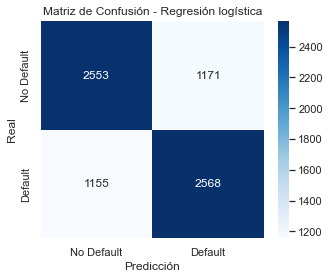


Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69      3724
           1       0.69      0.69      0.69      3723

    accuracy                           0.69      7447
   macro avg       0.69      0.69      0.69      7447
weighted avg       0.69      0.69      0.69      7447

AUC-ROC: 0.7509045435044962


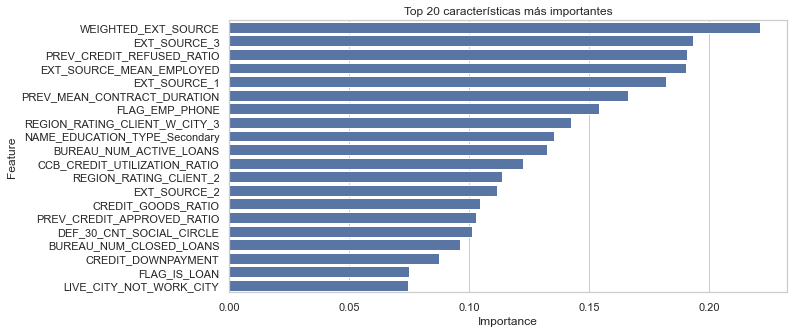

In [87]:
print("===== REGRESIÓN LOGÍSTICA =====")

# Pipeline con escalado + modelo
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

# Se entrena y valida del modelo
for train_index, val_index in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    pipeline_lr.fit(X_tr, y_tr)
    y_val_probs = pipeline_lr.predict_proba(X_val)[:, 1]
    # Se obtiene el valor AUC
    auc_val = roc_auc_score(y_val, y_val_probs)
    print(f"AUC en validación: {auc_val:.4f}")

# Calibración
calibrated_lr = CalibratedClassifierCV(pipeline_lr, method='sigmoid', cv='prefit')
calibrated_lr.fit(X_cal, y_cal)

# Test y evaluación
y_pred_lr = calibrated_lr.predict(X_test)
y_prob_lr = calibrated_lr.predict_proba(X_test)[:, 1]
print_evaluation(y_test, y_pred_lr, y_prob_lr, 'Regresión logística')

# Se muestran las variables más significativas
coef = pipeline_lr.named_steps['lr'].coef_[0]
features = X.columns
importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coef)})
importance = importance.sort_values(by='Importance', ascending=False).head(20)

# Graficar las características más importantes
plt.figure(figsize=(10, 5))
sns.barplot(x=importance['Importance'], y=importance['Feature'])
#plt.barh(importance['Feature'], importance['Importance'], color='blue')
plt.title('Top 20 características más importantes')
plt.show()

El modelo de regresión logística no presenta malos resultados, su AUC-ROC es de 0.75, mientras que su F1-score tanto para los default como para los no default es de 0.69. Son resultados que en determinadas situaciones podrían ser aceptables, pero esperamos obtener mejores resultados con los siguientes modelos.

### 2.2. Random Forest

Repetimos el proceso con el modelo de Random Forest. Esperamos conseguir mejores resultados que los mostrados por el modelo de regresión logística.


===== RANDOM FOREST =====
AUC en validación: 0.7757
AUC en validación: 0.7560
AUC en validación: 0.7659
AUC en validación: 0.7621
AUC en validación: 0.7533


c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


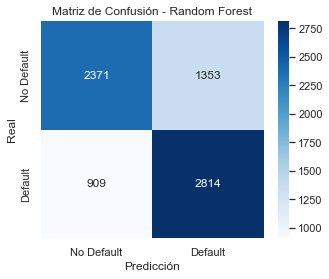


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.64      0.68      3724
           1       0.68      0.76      0.71      3723

    accuracy                           0.70      7447
   macro avg       0.70      0.70      0.70      7447
weighted avg       0.70      0.70      0.70      7447

AUC-ROC: 0.760529950985441


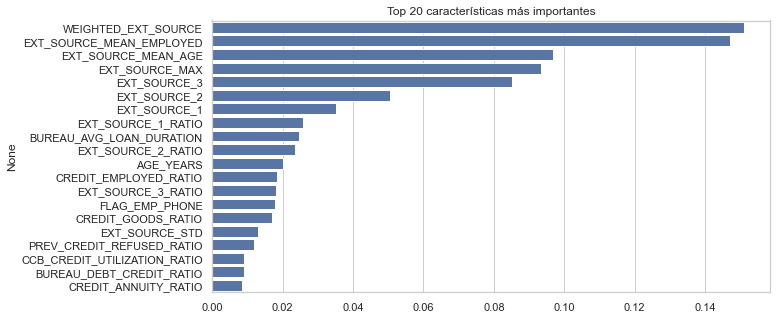

In [88]:
print("\n===== RANDOM FOREST =====")
model_rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)

for train_index, val_index in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model_rf.fit(X_tr, y_tr)
    # Se obtiene el valor AUC
    auc_val = roc_auc_score(y_val, model_rf.predict_proba(X_val)[:, 1])
    print(f"AUC en validación: {auc_val:.4f}")

# Calibración
calibrated_rf = CalibratedClassifierCV(model_rf, method='isotonic', cv='prefit')
calibrated_rf.fit(X_cal, y_cal)

# Test y evaluación
y_pred_rf = calibrated_rf.predict(X_test)
y_prob_rf = calibrated_rf.predict_proba(X_test)[:, 1]
print_evaluation(y_test, y_pred_rf, y_prob_rf, 'Random Forest')
show_feature_importance(model_rf, X.columns)

El modelo de Random Forest mejora en métricas los valores obtenidos por el modelo de regresión logística, pero tiende a clasificar de más en default, que de cara a prevenir impagos no tiene por qué ser negativo, aunque supone un recorte en la producción. En cualquier caso, la AUC-ROC es de 0.76 y los F1-scores para default y no default son de 0.71 y 0.68 respectivamente.

### 2.3. Gradient Boosting

Repetimos el proceso con el modelo de Gradient Boosting. Este modelo es más sofisticado y pensamos que puede obtener mejores resultados que los anteriores.


===== GRADIENT BOOSTING =====
AUC en validación: 0.8212
AUC en validación: 0.8077
AUC en validación: 0.8182
AUC en validación: 0.8146
AUC en validación: 0.8071


c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


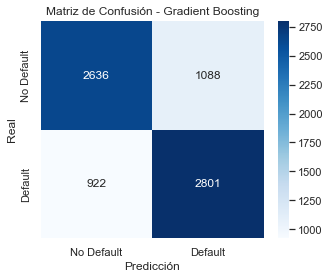


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72      3724
           1       0.72      0.75      0.74      3723

    accuracy                           0.73      7447
   macro avg       0.73      0.73      0.73      7447
weighted avg       0.73      0.73      0.73      7447

AUC-ROC: 0.813453139006143


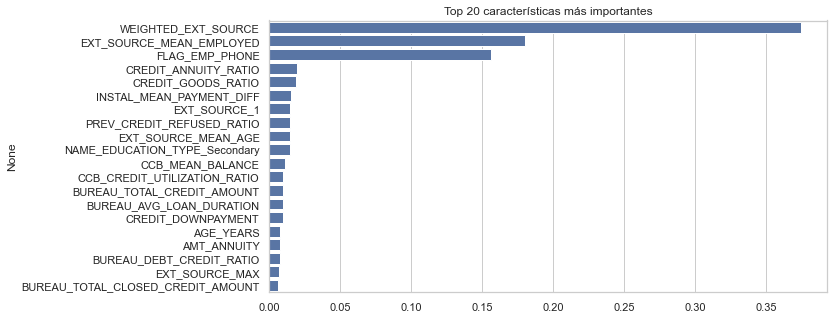

In [89]:
print("\n===== GRADIENT BOOSTING =====")
model_gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=6, 
                                 subsample=0.7, min_samples_leaf=25, random_state=42)

for train_index, val_index in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model_gb.fit(X_tr, y_tr)
    # Se obtiene el valor AUC
    auc_val = roc_auc_score(y_val, model_gb.predict_proba(X_val)[:, 1])
    print(f"AUC en validación: {auc_val:.4f}")

# Calibración
calibrated_gb = CalibratedClassifierCV(model_gb, method='sigmoid', cv='prefit')
calibrated_gb.fit(X_cal, y_cal)

# Test y evaluación
y_pred_gb = calibrated_gb.predict(X_test)
y_prob_gb = calibrated_gb.predict_proba(X_test)[:, 1]
print_evaluation(y_test, y_pred_gb, y_prob_gb, 'Gradient Boosting')
show_feature_importance(model_gb, X.columns)

El modelo Gradient Boosting obtiene mejores resultados que los anteriores, con un AUC-ROC de 0.813, un F1-score para default de 0.74 y un F1-score para no default de 0.72. Sin embargo, la significancia de las variables no es muy alentadora. Mientras que la significación del modelo en las pruebas anteriores se reparte entre varias variables, en este con solo tres de las variables se obtiene la mayor parte de la significación, lo que puede hacer pensar que, a la hora de utilizar este modelo en un entorno real, los resultados que va a obtiene pueden no ser muy buenos. Incluso puede ocurrir que haya sobre entrenamiento o *data leakage*. Si nos decantásemos por este modelo deberíamos comprobar estas situaciones.

### 2.4. LightGBM

Por último, se va a entrenar el modelo LightGBM, que es una implementación de gradient boosting desarrollada por Microsoft y que implementa mejoras que permiten obtener mejores resultados que Gradient Boosting.


===== LIGHTGBM =====
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 11816, number of negative: 11816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wi

Early stopping, best iteration is:
[179]	valid_0's auc: 0.881366	valid_0's binary_logloss: 0.450834	valid_1's auc: 0.825342	valid_1's binary_logloss: 0.510768
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
AUC en validación: 0.8253
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction

c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


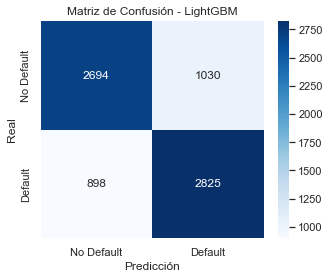


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.74      3724
           1       0.73      0.76      0.75      3723

    accuracy                           0.74      7447
   macro avg       0.74      0.74      0.74      7447
weighted avg       0.74      0.74      0.74      7447

AUC-ROC: 0.8214036155197479


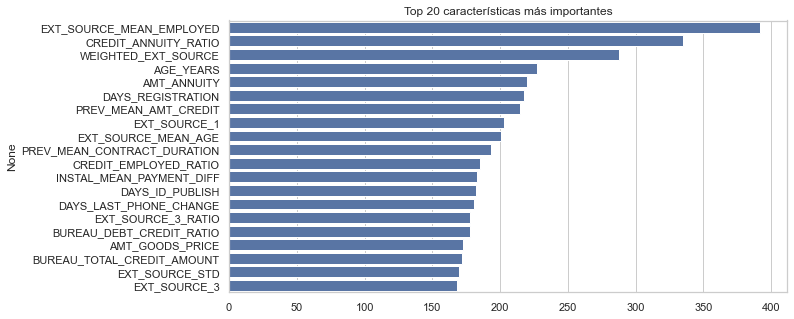

In [90]:
print("\n===== LIGHTGBM =====")
model_lgb = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.7,  # <- usa 70% de las variables en cada iteración
    bagging_fraction=0.8,  # <- se controlan las muestras
    bagging_freq=5,        # <- realiza bagging cada 5 iteraciones
    random_state=42)

# Se entrena el modelo con registro de métricas
for train_index, val_index in kf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    model_lgb.fit(X_tr, y_tr, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='auc',
                  callbacks=[lgb.early_stopping(stopping_rounds=25)])
    # Se obtiene el valor AUC
    auc_val = roc_auc_score(y_val, model_lgb.predict_proba(X_val)[:, 1])
    print(f"AUC en validación: {auc_val:.4f}")
    
# Se captura los resultados de evaluación
evals_result = model_lgb.evals_result_

# Calibración    
calibrated_lgb = CalibratedClassifierCV(model_lgb, method='sigmoid', cv='prefit')
calibrated_lgb.fit(X_cal, y_cal)

# Test y evaluación
y_pred_lgb = calibrated_lgb.predict(X_test)
y_prob_lgb = calibrated_lgb.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_prob_lgb)
print(f"AUC en test: {auc_test:.4f}")
print_evaluation(y_test, y_pred_lgb, y_prob_lgb, 'LightGBM')
show_feature_importance(model_lgb, X.columns)

El modelo LightGBM presenta las mejores métricas de la comparativa, con un AUC-ROC de 0.82 y con unos F1-scores para los valores no default y default de 0.75 y 0.74 respectivamente. Las variables más significativas tienen sentido y aportan de manera más proporcionada significancia al modelo. Por todo lo anterior, este va a ser el modelo seleccionado para seguir el desarrollo del proyecto. Antes de eso, se va a comprobar que el modelo no tiene ningún problema.

Para confirmar la selección, se comparan las curvas ROC de los cuatro modelos

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


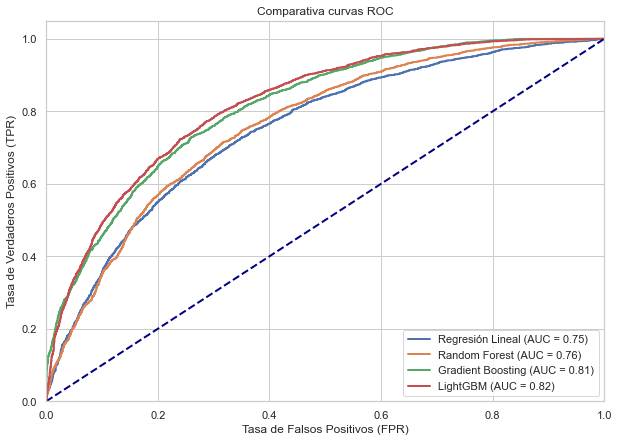

In [91]:
# Se configuran los modelos a comparar
models = [pipeline_lr, model_rf, model_gb, model_lgb]
model_names = ['Regresión Lineal', 'Random Forest', 'Gradient Boosting', 'LightGBM']

# Se comparan las curvas ROC de los tres modelos
plot_roc_curves(models, model_names, X_test, y_test)

Se puede apreciar que los modelos de Regresión Logística y Random Forest son los que peor comportamiento tienen y que de los dos restantes, el modelo LightGBM tiene un comportamiento mejor al del modelo Gradient Boosting, confirmando la elección realizada.

### 2.5. Comprobación del modelo seleccionado

A continuación, se va a comprobar que el modelo seleccionado se comporta adecuadamente, es robusto, discrimina bien entre los valores default-no default, no tiene *data leakage*, no está sobreentrenado, etc. Es decir, se va a comprobar que el modelo seleccionado es fiable. Para ello, se va a validar su desempeño mediante una serie de pruebas de validación.

En primer lugar, se van a generar una serie de gráficos para comprobar diferentes aspectos del modelo. En concreto se van a generar las siguientes gráficas:

- Curvas de Aprendizaje: permite evaluar el ajuste del modelo y descartar la presencia de overfitting o subfitting.
- Curva ROC: permite evaluar la capacidad de discriminación del modelo.
- Curva de Ganancia: permite evaluar la efectividad a la hora de identificar defaults, en nuestro caso.
- Curva KS: permite evaluar la capacidad de discriminación entre default y no default.

Posteriormente, se va a comprobar la capacidad y robustez del modelo mediante las siguientes pruebas:

- Cross-Validation: proporciona una evaluación más robusta y confiable del rendimiento del modelo.
- Comparativa de AUC: comparando el AUC de los conjuntos de entrenamiento, validación, calibración y test podemos averiguar si existe *data leakage*.


Se muestran a continuación las curvas de evaluación del modelo.

#### Curva de aprendizaje

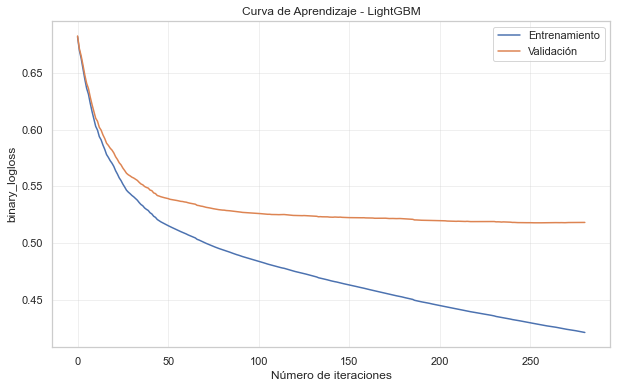

In [92]:
# Se genera el gráfico comparativo de las curvas de aprendizaje de entrenamiento y test
plot_learning_curve_LightGBM(evals_result)

La curva de aprendizaje muestra cómo la pérdida logarítmica (Log Loss) disminuye a medida que aumenta el número de iteraciones tanto para los datos de entrenamiento como para los datos de prueba. La curva azul, muestra una disminución continua y más pronunciada en comparación con la curva naranja. Esto indica que el modelo está aprendiendo y mejorando su rendimiento en los datos de entrenamiento de manera más rápida y efectiva. Es importante indicar que la curva de prueba se estabiliza alrededor de las 150 iteraciones, lo que sugiere que el modelo alcanza su capacidad máxima de generalización en ese punto.

La estabilización de la curva de prueba alrededor de las 150 iteraciones es un indicador positivo de que el modelo no está sobreajustando los datos de entrenamiento. Si la curva de prueba continuara disminuyendo junto con la curva de entrenamiento, podría ser una señal de sobreajuste. En este caso, la diferencia entre las dos curvas sugiere que el modelo está bien ajustado y generaliza adecuadamente. 

#### Curva ROC

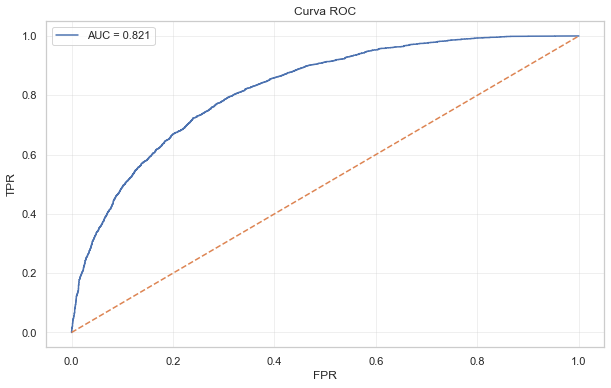

In [93]:
# Se general la curva ROC
plot_ROC_curve(y_test, y_prob_lgb)

La curva ROC permite evaluar el rendimiento del modelo clasificatorio en distintos umbrales de decisión. En el eje x se representa la tasa de falsos positivos (FPR) y en el eje y la tasa de verdaderos positivos (TPR). La línea azul muestra cómo varían estos valores según se ajusta el umbral, mientras que la línea diagonal punteada representa un clasificador aleatorio. En el modelo seleccionado la curva se sitúa significativamente por encima de esta línea, lo que indica un desempeño superior al azar. Un AUC de 0.82 es un valor sólido, que sugiere que el modelo tiene una buena capacidad discriminatoria. Podría ser mejor, pero este valor indica que el modelo es bastante confiable en términos de clasificación general.

#### Curva de ganancia

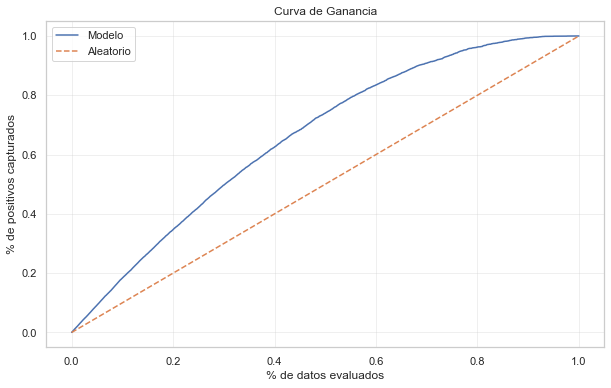

In [94]:
# Se genera la curva de ganancia
plot_gain_chart(y_test, y_prob_lgb)

La curva de ganancia permite comparar el rendimiento predictivo del modelo (línea azul) frente a una situación en la que la decisión fuese aleatoria (línea de puntos naranja). En el gráfico se aprecia como el modelo logra capturar un mayor porcentaje de positivos evaluando un menor porcentaje de datos. En base a la evolución del rendimiento del modelo, muy por encima de la decisión aleatoria, indica que el modelo se comporta bien e identifica correctamente los default. Por ejemplo, si se evalúa solo el 40% de los datos con mayor probabilidad según el modelo, se puede llegar a capturar más del 70% de los casos default, lo que refleja un buen desempeño. Lo ideal hubiera sido que la curva fuese más pronunciada al inicio del eje x, pero aun así, la forma curvada y creciente sugiere una buena capacidad predictiva.

#### Curva de Kolmogorov-Smirnov

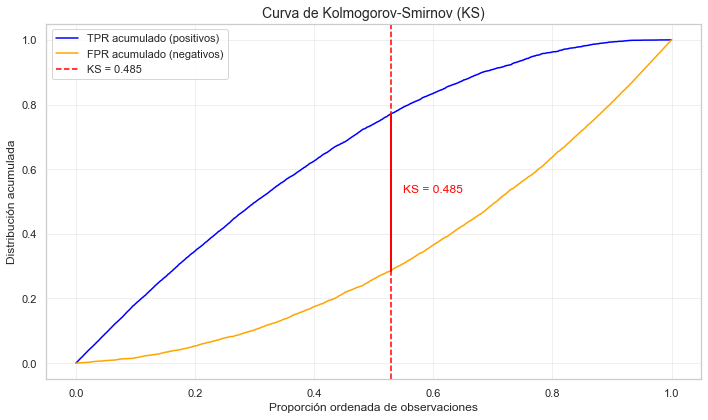

In [95]:
# Se genera la cuva de Kolmogorov-Smirnov
plot_ks_curve(y_test, y_prob_lgb)

La curva de Kolmogorov-Smirnov nos permite evaluar la capacidad discriminatoria del modelo. En la curva se aprecia la separación entre los verdaderos positivos, es decir los default clasificados como default, y los falsos positivos, es decir, no default clasificados como default. Como se aprecia en la gráfica, ambas líneas están separadas con claridad, y su valor KS, o distancia vertical máxima entre las curvas, es de 0485, que es un valor aceptable en un modelo de clasificación binaria de credit score, por lo que se sugiere por esta curva, que el modelo está haciendo un buen trabajo al distinguir entre default y no default.

#### Cross-validation

In [96]:
# Se realiza la validación cruzada del modelo mediante la función cross_val_score
cv_scores = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Mean AUC: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 11816, number of negative: 11816
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004995 seconds.
You can set `force_col_wise=true` to remove the

El valor de AUC de 0.8198 indica que el modelo tiene una muy buena capacidad de discriminación. Es decir, puede diferenciar correctamente entre las clases positivas y negativas (default - no default) en un 81.97% de los casos. Un AUC superior a 0.8 generalmente se considera un resultado sólido en problemas de clasificación binaria.

Por otro lado, la desviación estándar de 0.0054 sobre los resultados de la validación cruzada refleja una variación muy baja en el rendimiento del modelo entre los distintos folds. Esto es una señal positiva, ya que sugiere que el modelo es estable y robusto, es decir, generaliza bien independientemente del subconjunto de datos sobre el que se entrene. En conjunto, tanto el AUC como su baja desviación estándar indican que el modelo no solo es preciso, sino también fiable, y que su rendimiento es coherente en distintas particiones de los datos.

In [97]:
print("AUC Entrenamiento:", roc_auc_score(y_train, model_lgb.predict_proba(X_train)[:, 1]))
print("AUC Validación:", roc_auc_score(y_val, model_lgb.predict_proba(X_val)[:, 1]))
print("AUC Calibración:", roc_auc_score(y_cal, model_lgb.predict_proba(X_cal)[:, 1]))
print("AUC Test:", roc_auc_score(y_test, model_lgb.predict_proba(X_test)[:, 1]))

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
AUC Entrenamiento: 0.8991771695595409
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
AUC Validación: 0.8188859740118054
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_f

El AUC en entrenamiento (0.8991) es claramente superior al de validación y test, pero no excesivamente alto como para levantar sospechas graves de overfitting o leakage. Es completamente normal que el rendimiento en entrenamiento sea mejor, ya que el modelo está optimizado para ese conjunto. Por otro lado, la AUC de validación (0.8188), de calibración (0.8280) y de test (0.8214) están muy alineadas (con variación menor al 1%), lo que sugiere que no hay *data leakage*, ya que un modelo con este problema suele mostrar un rendimiento desproporcionadamente alto en test o validación (>0.90), que no se sostiene en producción.
En conclusión, un valor AUC comprendido entre 0.81 y 0.83 para un problema de *credit score* es completamente razonable y aceptable.

Resumiendo, los datos obtenidos, el modelo LightGBM parece tener un rendimiento sólido y equilibrado. La curva de aprendizaje muestra que el modelo está aprendiendo y ajustándose bien a los datos de entrenamiento, aunque hay una ligera diferencia con la curva de validación, que podría indicar un ligero sobreajuste, sin embargo, otras evidencias obtenidas como cross-validation y la curva ROC parecen indicar que si existe, es prácticamente inexistente. Por otro lado, los valores de AUC en diferentes conjuntos de datos (entrenamiento, validación, calibración y test) son bastante consistentes, lo que sugiere que el modelo generaliza bien y mantiene un buen rendimiento en datos no tratados.

Además, los valores de F1-score para las clases de default y no default son bastante cercanos, lo que indica que el modelo tiene una buena capacidad para distinguir entre las dos clases. La curva de Kolmogorov-Smirnov muestra un valor de 0.483, lo cual es un buen indicador de la capacidad discriminatoria del modelo. En conjunto, los resultados de cross-validation con un AUC de 0.8197 y una desviación estándar de tan solo 0.0059 refuerzan la estabilidad y fiabilidad del modelo. En resumen, el modelo parece estar bien ajustado y es capaz de proporcionar predicciones precisas y consistentes.

## 3. Explicabilidad del modelo

Una vez se ha seleccionado y entrenado el modelo, se pasa a una de las partes más importantes del proyecto: la fase de la explicabilidad. Como se ha comentado tanto en el planteamiento como a lo largo del desarrollo, uno de los objetivos principales de TFG es conseguir desarrollar un modelo de *machine learning* explicable. 

Actualmente existen técnicas como SHAP o LIME, que permiten obtener una interpretación comprensible de la importancia de las variables en la decisión tomada por el modelo, que se puede traducir en una explicación de por qué ha tomado una decisión determinada. Sin embargo, se trata de procesos que requieren una alta comprensión de los aspectos técnicos, tanto del modelo como de la interpretación de los resultados, por lo que no se trata de una solución que pueda ser usada por un operador o una persona de atención al cliente de una entidad financiera.

Por este motivo, se considera como una gran posibilidad de innovación e investigación, la creación de un intérprete de IA generativa que permita explicar en un lenguaje coloquial el motivo por el cual una solicitud de financiación ha sido aprobada o rechazada. Este será el objetivo a alcanzar en este apartado.

El sistema que se va a desarrollar se basará en la técnica de *Few Shots Prompting*, la cual consiste en utilizar un modelo LLM (Large Language Model) al que se le pasan unos pocos ejemplos (few shots) compuestos por datos a evaluar y la salida esperada, para que el modelo aprenda lo que se espera de él. A continuación, se enviarán casos a evaluar, solo con los datos, para que el modelo genere una salida en base a estos.

Para entrenar el modelo, se le proporcionarán los siguientes datos:

- Las características o variables más significativas del modelo.
- Las SHAP values más significativas.
- La probabilidad de impago obtenida por el modelo.
- La explicación que acompaña a la decisión tomada.

A partir de este punto, se le proporcionará todo lo anterior excepto la explicación, para que el modelo genere una a partir de las que se le han introducido.

Antes de comenzar todo el proceso, se van a definir una serie de funciones que facilitarán las tareas a desarrollar.

In [24]:
# Se define la función para generar la estructura de los ejemplos few shots
def get_record_structure(df_data, explainer, X, model, iterator=1, ejemplo=1):
    """
    Función que genera la estructura de ejemlos para entrenar el modelo LLM de explicabilidad 
    de las decisiones del modelo.
    
    Parámetros:
    - df_data: DataFrame de Pandas.
    - explainer: (obj) objeto explainer de SHAP para la SHAP values.
    - X: (obj) conjunto de datos de entrenamiento.
    - model: (obj) modelo ML de credit score.
    - iterator: (int) valor de inicio de la numeración de los ejemplos generados.
    - ejemplo: (int) indicador de estructura de ejemplo (1). En caso contrario, estructura a explicar (0) 
    """
    # Se inicializa el contador de iteraciones y ejemplos
    n = iterator
    # Se declara la variable para almacenar los casos de ejemplo
    texto_completo = ""
    # Se recorren los registros a formatear
    for index, row in df_data.iterrows():
        # Se obtienen las explicaciones de la observación
        x_instance = X.loc[[index]]
        # Se obtienen las SHAP values
        shap_values_instance = explainer(x_instance)
        # Se pasan las SHAP values a un dataframe
        df_shap = pd.DataFrame(shap_values_instance.values, columns=X.columns)
        # Se obtiene la probabilidad de impago
        prob_impago = model.predict_proba(x_instance)[0][1]
        # Se obtiene el ejemplo en caso de que sea ese tipo de estructura
        if ejemplo == 1:
            texto = (
            'Ejemplo ' + str(n) + ':\n'
            'Features:\n'
            '{\n'
            '\t"Score externo": ' + str(round(row['WEIGHTED_EXT_SOURCE'], 2)) + ',\n'
            '\t"Carga sobre ingresos": ' + str(round(row['TOTAL_ANNUITY_INCOME_RATIO'] * 100, 2)) + '%,\n'
            '\t"Duración del préstamo": ' + str(int(row['CREDIT_ANNUITY_RATIO'])) + ' años,\n'
            '\t"Porcentaje rechazos previos": ' + str(round(row['PREV_CREDIT_REFUSED_RATIO']* 100, 2)) + '%,\n'
            '\t"Antigüedad empleo": ' + str(round(row['EMPLOYED_YEARS'], 2)) + ' años,\n'
            '\t"Meses impago previos": ' + str(int(row['BUREAU_ACTIVE_NUM_MONTHS_LATE'] + 
                                                   row['INSTAL_NUM_LATE_PAYMENTS'])) + ' meses,\n'
            '}\n'
            'SHAP Values:\n'
            '{\n'
            '\t"SHAP Score externo": ' + str(round(df_shap['WEIGHTED_EXT_SOURCE'].iloc[0], 2)) + ',\n'
            '\t"SHAP Ratio score antigüedad empleo": ' + str(round(df_shap['EXT_SOURCE_MEAN_EMPLOYED'].iloc[0], 2)) + ',\n'      
            '\t"SHAP Duración del préstamo": ' + str(round(df_shap['CREDIT_ANNUITY_RATIO'].iloc[0], 2))  + ',\n' 
            '\t"SHAP Diferencia entre cuota y pago":' + str(round(df_shap['INSTAL_MEAN_PAYMENT_DIFF'].iloc[0], 2))  + ',\n' 
            '\t"SHAP Porcentaje rechazos previos": ' + str(round(df_shap['PREV_CREDIT_REFUSED_RATIO'].iloc[0], 2))  + ',\n'                
            '}\n'
            'Probabilidad impago: ' + str(round(prob_impago, 2) * 100) + '%\n'
            '\n'
            )
        else:
            texto = (
            '[Solicitud a explicar]\n'
            'Features:\n'
            '{\n'
            '\t"Score externo": ' + str(round(row['WEIGHTED_EXT_SOURCE'], 2)) + ',\n'
            '\t"Carga sobre ingresos": ' + str(round(row['TOTAL_ANNUITY_INCOME_RATIO'] * 100, 2)) + '%,\n'
            '\t"Duración del prestamo": ' + str(int(row['CREDIT_ANNUITY_RATIO'])) + ' años,\n'
            '\t"Porcentaje rechazos previos": ' + str(round(row['PREV_CREDIT_REFUSED_RATIO']* 100, 2)) + '%,\n'
            '\t"Antigüedad empleo": ' + str(round(row['EMPLOYED_YEARS'], 2)) + ' años,\n'
            '\t"Meses impago previos": ' + str(int(row['BUREAU_ACTIVE_NUM_MONTHS_LATE'] + 
                                                   row['INSTAL_NUM_LATE_PAYMENTS'])) + ' meses,\n'
            '}\n'
            'SHAP Values:\n'
            '{\n'
            '\t"SHAP Score externo": ' + str(round(df_shap['WEIGHTED_EXT_SOURCE'].iloc[0], 2)) + ',\n'
            '\t"SHAP Ratio score antigüedad empleo": ' + str(round(df_shap['EXT_SOURCE_MEAN_EMPLOYED'].iloc[0], 2)) + ',\n'      
            '\t"SHAP Duración del préstamo": ' + str(round(df_shap['CREDIT_ANNUITY_RATIO'].iloc[0], 2))  + ',\n'
            '\t"SHAP Diferencia entre cuota y pago":' + str(round(df_shap['INSTAL_MEAN_PAYMENT_DIFF'].iloc[0], 2))  + ',\n'
            '\t"SHAP Porcentaje rechazos previos": ' + str(round(df_shap['PREV_CREDIT_REFUSED_RATIO'].iloc[0], 2))  + ',\n'                
            '}\n'
            'Probabilidad impago: ' + str(round(prob_impago * 100, 2)) + '%\n'
            '\n'
            )

        # Se incrementa el contador de iteraciones y ejemplos
        n+=1
        # Se concatenan los textos
        texto_completo = texto_completo + texto
    # Se devuelve la cadena generada
    return texto_completo

En primer lugar, se han de generar los datos a partir de los cuales se van a generar tanto los ejemplos que se van a pasar al modelo LLM, como las observaciones de las que se van a obtener sus explicaciones de manera automática. 

Antes de todo, se va a verificar que la calibración del modelo proporciona una probabilidad de impago, para saber interpretar el valor una vez obtenido.

In [10]:
# El modelo permite generar una probabilidad, pero se ha de verificar su significado
# Se obtienen las predicciones y las probabilidades
y_pred_lgb = calibrated_lgb.predict(X_test)
y_prob_lgb = calibrated_lgb.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [113]:
# Se pasan las predicciones y probabilidades a series de pandas
pred_series = pd.Series(y_pred_lgb)
prob_series = pd.Series(y_prob_lgb)

# Se concatenan en un dataframe
df_base = pd.DataFrame({
    'Target': y_test
})

# Se resetea el indice (guarda el índice antiguo en una nueva columna llamada 'index')
df_base = df_base.reset_index()  

# Se añaden las predicciones y las probabilidades
df_base['Prediccion'] = pred_series
df_base['Probabilidad'] = prob_series

# Se puestran los 10 primeros registros del dataframe obtenido
df_base.head(20)

index  Target  Prediccion  Probabilidad
0     5553       1           1      0.546745
1   276585       0           0      0.433375
2   171260       1           0      0.493309
3   139059       1           1      0.870511
4   179899       1           1      0.677790
5   296962       1           1      0.744378
6   151018       0           0      0.146242
7    16660       1           1      0.866378
8    20433       0           0      0.435673
9    35286       1           1      0.795269
10  151180       1           0      0.459239
11  231035       0           1      0.578142
12  180355       1           1      0.536940
13  292935       1           1      0.514451
14   44655       1           0      0.357556
15   90546       0           0      0.497341
16  206852       0           1      0.583508
17  217811       0           0      0.359329
18   91690       1           0      0.227556
19   91570       1           1      0.845505

Como se puede ver, la probabilidad indica el riesgo de impago, es decir, una probabilidad alta indica que el cliente es un mal pagador. A continuación, se van a obtener los SHAP values del modelo, que nos permiten identificar las variables más influyentes en la decisión del modelo, así como la forma en la que influyen en el resultado.

c:\users\usuario\appdata\local\programs\python\python39\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


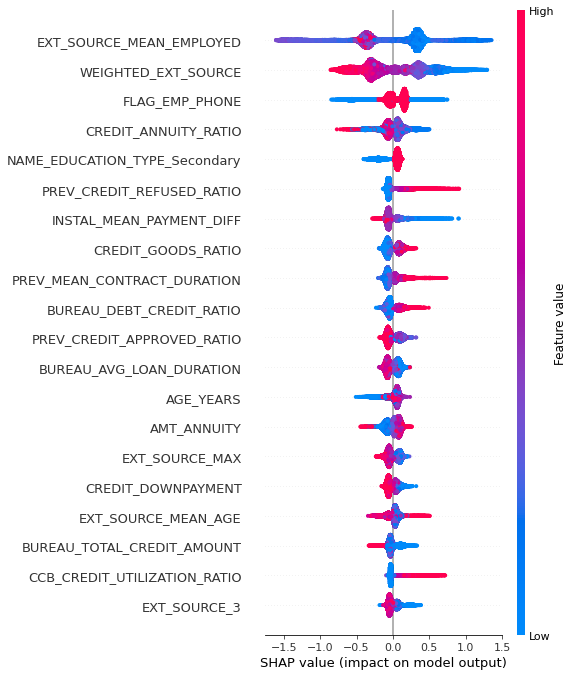

In [22]:
# Se instancia el explainer de SHAP sobre el modelo
explainer = shap.TreeExplainer(model_lgb)
# Se aplica el explicador sobre los predictores del modelo
shap_values = explainer.shap_values(X)

# Se muestra a continuación el resultado
shap.summary_plot(shap_values, X)

El gráfico obtenido, muestra por orden de importancia las variables más importantes para el modelo a la hora de tomar una decisión. Los valores menores que 0 indican una tendencia al buen pagador, mientras que los valores positivos identifican a los mal pagadores. EL color indica el valor de la variable. Los valores más bajos de la variable se muestran en azul, mientras que los valores más altos aparecen en rojo.

Por ejemplo, la variable más significativa, WEIGHTED_EXT_SOURCE, que es la suma de los scores externos ponderados, muestra que los solicitantes con notas más bajas tienden a impagar, mientras que los que tienen notas más altas son buenos pagadores, en general, ya que se aprecian algunas observaciones rojas (notas altas) con valores SHAP positivos, por lo que impagan, pero son muy pocos.

A partir de estos valores, podemos seleccionar los más importantes para pasárselos al modelo LLM. Por ejemplo, podemos coger las 10 variables más significativas.

In [105]:
# Se obtiene la media absoluta de cada variable
mean_abs_shap = np.abs(shap_values).mean(axis=0)
# Se seleccionan las 10 variables con mayores SHAP values
top_features = pd.Series(mean_abs_shap, index=X.columns).nlargest(10)

In [106]:
# Se muestran las variables seleccionadas
top_features

EXT_SOURCE_MEAN_EMPLOYED         0.423361
WEIGHTED_EXT_SOURCE              0.372071
FLAG_EMP_PHONE                   0.151647
CREDIT_ANNUITY_RATIO             0.115484
NAME_EDUCATION_TYPE_Secondary    0.098025
PREV_CREDIT_REFUSED_RATIO        0.093956
INSTAL_MEAN_PAYMENT_DIFF         0.088029
CREDIT_GOODS_RATIO               0.086960
PREV_MEAN_CONTRACT_DURATION      0.084761
BUREAU_DEBT_CREDIT_RATIO         0.075805
dtype: float64

Por otro lado, se han de seleccionar las variables más significativas del modelo. En este caso, se van a seleccionar las 6 variables más significativas. Al modelo se le tendrán que pasar las variables sin tratar.

In [107]:
# Se obtiene la importancia de las variables
importances = model_lgb.feature_importances_

In [108]:
# Se seleccionan las 10 más relevantes
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(10)

# Se muestran las variables seleccionadas
feat_imp

EXT_SOURCE_MEAN_EMPLOYED       392
CREDIT_ANNUITY_RATIO           335
WEIGHTED_EXT_SOURCE            288
AGE_YEARS                      227
AMT_ANNUITY                    220
DAYS_REGISTRATION              218
PREV_MEAN_AMT_CREDIT           215
EXT_SOURCE_1                   203
EXT_SOURCE_MEAN_AGE            201
PREV_MEAN_CONTRACT_DURATION    193
dtype: int32

Una vez se han identificado las variables más significativas del modelo, así como los SHAP values con mayor relevancia para el modelo, se puede empezar a trabajar con el modelo LLM para explicar el porqué de la decisión tomada. Antes de esto, se van a preparar los datos para generar los ejemplos a partir de los cuales el modelo va a aprender a dar una explicación.

In [114]:
# Seleccionamos registros que se van a usar como ejemplo 3 con imapago y 3 con gestión normal
df_default = df_credit_score_predictors.loc[[139059, 179899, 296962]]
df_no_default = df_credit_score_predictors.loc[[276585, 151018, 217811]]

Para favorecer la interpretabilidad del modelo, se ha decidido no usar las variables más significativas del modelo, ya que no permiten facilitar el proceso. Por lo tanto, se van a seleccionar variables del conjunto de datos original que den una idea de la situación del cliente en el momento de solicitar el préstamo. 

Después de revisar las variables disponibles, se van a usar para generar la explicabilidad del modelo las siguientes variables:

- WEIGHTED_EXT_SOURCE: representa una combinación ponderada de las notas de score externas, lo que da una idea de la solvencia del cliente.
- TOTAL_ANNUITY_INCOME_RATIO: carga sobre ingresos total del cliente.
- CREDIT_ANNUITY_RATIO: representa la duración del préstamo en años.
- PREV_CREDIT_REFUSED_RATIO: ratio de préstamos rechazados anteriores al actual.
- EMPLOYED_YEARS: antigüedad en el empleo.
- BUREAU_ACTIVE_NUM_MONTHS_LATE + INSTAL_NUM_LATE_PAYMENTS: número de mensualidades atrasadas del cliente en créditos previos.

Por otro lado, se van a obtener los SHAP values de cada una de las observaciones, y de estos se van a seleccionar los 6 que más peso tienen en la decisión del modelo. Estos son los siguientes:

- WEIGHTED_EXT_SOURCE: representa una combinación ponderada de las notas de score externas, lo que da una idea de la solvencia del cliente.             
- EXT_SOURCE_MEAN_EMPLOYED: ratio entre la media de los scores externos y la antigüedad en el empleo del cliente.               
- CREDIT_ANNUITY_RATIO: representa la duración del préstamo en años.            
- INSTAL_MEN_PAYMENT_DIFF: Diferencia media entre el importe de la cuota y lo pagado por el cliente.   
- PREV_CREDIT_REFUSED_RATIO: ratio de préstamos rechazados anteriores al actual.

Por último, se va a añadir la probabilidad de impago obtenida por el modelo de *credit score*.

In [110]:
# Se muestran las variables seleccionadas para cada uno de los registros default
texto_default = get_record_structure(df_default, explainer, X, calibrated_lgb)
# Se muestra el texto generado
print(texto_default)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

In [115]:
# Se muestran las variables seleccionadas para cada uno de los registros no default
# Contador para las iteraciones
texto_no_default = get_record_structure(df_no_default, explainer, X, calibrated_lgb, 4)
# Se muestra el texto generado
print(texto_no_default)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

Una vez se tiene identificados los ejemplos y los valores a tener en cuenta, se van a transcribir las explicaciones de cada uno de los ejemplos para crear el *prompt* que se pasara al modelo LLM para que aprenda a realizar las predicciones.

In [25]:
# Se generan los ejemplos para ayudar al modelo LLM a generar la explicación
few_shot_prompt = """
[Contexto]
El objetivo es generar una explicación clara, breve y coherente sobre la decisión de una solicitud de crédito. 
La decisión se basa en las características del solicitante (features), los valores SHAP que explican la predicción del modelo, 
y la probabilidad de impago estimada. 
La explicación debe ser en un solo párrafo, con lenguaje comprensible, empático y sin juicios negativos.

[Reglas del modelo]

[1. Reglas sobre features]
- Score externo ≥ 0.50 se considera alto; si es menor, se considera bajo. Cuanto mayor sea, menos riesgo de impago.
- Antigüedad en el empleo:
    - ≥ 5 años se considera alta **reduce el riesgo de impago**.
    - ≥ 2 años y < 5 años aceptable
    - < 2 años se considera baja **aumenta el riesgo de impago**.
- Carga sobre ingresos:
    - > 33% se considera alta **aumenta el riesgo de impago**.
    - ≤ 33% se considera baja **reduce el riesgo de impago**.
- Porcentaje de rechazos previos > 10% **aumenta el riesgo de impago**.
- Meses con impagos previos > 6 meses **aumenta el riesgo de impago**.
- Duración del préstamo ≥ 15 años incrementa el riesgo de impago. 

[2. Reglas sobre SHAP values]
- Los valores SHAP muestran cuánto influye cada variable en la probabilidad de impago.
- Un valor SHAP positivo indica que esa variable **aumenta** la probabilidad de impago.
      - Ejemplo: si "SHAP Score externo" = 0.25, entonces ese score contribuye a **elevar el riesgo**.
- Un valor SHAP negativo indica que esa variable **reduce** la probabilidad de impago.
      - Ejemplo: si "SHAP Antigüedad empleo" = -0.30, entonces la antigüedad contribuye a **disminuir el riesgo**.
- Cuanto mayor (positivo o negativo) sea el valor, mayor es su impacto.
- Si predominan valores SHAP positivos: la decisión tiende al **rechazo**.
- Si predominan valores SHAP negativos: la decisión tiende a la **aprobación**.

[3. Regla de decisión final]
- Probabilidad de impago > 50% → se recomienda rechazar.
- Probabilidad de impago ≤ 50% → se puede aprobar.

[Instrucciones para redactar la explicación]
- Comenzar con el resultado (aprobado o rechazado) y la probabilidad.
- Mencionar los factores más influyentes: score externo, antigüedad laboral, carga, historial, etc.
- Si los SHAP values aportan claridad, incorporarlos para reforzar la interpretación.
- Evitar mezclar valores reales con SHAP sin distinguirlos.
- Usar lenguaje empático y respetuoso, especialmente si es una denegación.

[Ejemplos]

Ejemplo 1:
Features:
{
    "Score externo": 0.36,
    "Carga sobre ingresos": 41.74%,
    "Duración del préstamo": 12 años,
    "Porcentaje rechazos previos": 14.29%,
    "Antigüedad empleo": 6.95 años,
    "Meses impago previos": 2 meses,
}
SHAP Values:
{
    "SHAP Score externo": 0.34,
    "SHAP Ratio score antigüedad empleo": -0.28,
    "SHAP Duración del préstamo": 0.31,
    "SHAP Diferencia entre cuota y pago":0.04,
    "SHAP Porcentaje rechazos previos": -0.05,
}
Probabilidad impago: 87.0%
Explicación: La solicitud de crédito se rechaza por una probabilidad de impago elevada (87.0%), influida por un score 
externo bajo (0.36), una carga sobre ingresos alta (41.74%) y un historial con un porcentaje de rechazos del 14.29%. 
De entre los valores SHAP, los que más influyen en la decisión son el score externo (+0.34) y la duración del préstamo 
(+0.31), lo que refuerza la decisión de rechazo.

Ejemplo 2:
Features:
{
    "Score externo": 0.35,
    "Carga sobre ingresos": 71.1%,
    "Duración del préstamo": 19 años,
    "Porcentaje rechazos previos": 20.0%,
    "Antigüedad empleo": 9.31 años,
    "Meses impago previos": 6 meses,
}
SHAP Values:
{
    "SHAP Score externo": 0.41,
    "SHAP Ratio score antigüedad empleo": -0.42,
    "SHAP Duración del préstamo": 0.07,
    "SHAP Diferencia entre cuota y pago":0.03,
    "SHAP Porcentaje rechazos previos": -0.05,
}
Probabilidad impago: 74.0%
Explicación: La solicitud se rechaza por una probabilidad de impago del 74.0%, ya que cuenta con un score externo bajo (0.35) 
una carga sobre ingresos muy alta (71.1%) y un historial de 6 meses con impago. Entre los SHAP values, los que más influyen 
en la decisión son el score externo (+0.41) y la duración del préstamo (+0.07), que justifican la decisión de rechazo.

Ejemplo 3:
Features:
{
    "Score externo": 0.54,
    "Carga sobre ingresos": 20.69%,
    "Duración del préstamo": 20 años,
    "Porcentaje rechazos previos": 0.0%,
    "Antigüedad empleo": 1.36 años,
    "Meses impago previos": 1 meses,
}
SHAP Values:
{
    "SHAP Score externo": -0.28,
    "SHAP Ratio score antigüedad empleo": 0.32,
    "SHAP Duración del préstamo": 0.09,
    "SHAP Diferencia entre cuota y pago":0.15,
    "SHAP Porcentaje rechazos previos": -0.05,
}
Probabilidad impago: 44.0%
Explicación: La solicitud se aprueba con una probabilidad de impago del 44.0%, respaldada por un score externo alto (0.54),
una carga sobre ingresos aceptable (20.69%) y no haber tenido rechazos previos. Los SHAP values que refuerzan la decisión 
de aprobar la solicitud son el score externo (-0.28) y el porcentaje de rechazos previos (-0.05).

Ejemplo 4:
Features:
{
    "Score externo": 0.58,
    "Carga sobre ingresos": 13.17%,
    "Duración del préstamo": 17 años,
    "Porcentaje rechazos previos": 0.0%,
    "Antigüedad empleo": 14.97 años,
    "Meses impago previos": 2 meses,
}
SHAP Values:
{
    "SHAP Score externo": -0.33,
    "SHAP Ratio score antigüedad empleo": -0.34,
    "SHAP Duración del préstamo": -0.04,
    "SHAP Diferencia entre cuota y pago":0.03,
    "SHAP Porcentaje rechazos previos": -0.04,
}
Probabilidad impago: 36.0%
Explicación: La solicitud se aprueba con una probabilidad de impago del 36.0%, por debajo del 50.0%, decisión respaldada por 
un alto score externo (0.58), una baja carga sobre ingresos (13.17%) y no tener historial de rechazos previos (0.0%).Los  
SHAP values que más influyen en la decisión son el score externo (-0.33) y el ratio de score sobre la antigüedad en el 
empleo (-0.34).
"""

Se obtienen los datos de un ejemplo para comprobar como el modelo LLM genera la explicación a partir de las que se han introducido por nuestra parte.

In [117]:
# Se escoge otro registro del ejemplo anterior como solicitud a analizar
solicitud = get_record_structure(df_credit_score_predictors.loc[[91570]], explainer, X, calibrated_lgb, 7, ejemplo=0)
# Se muestra la solicitud a analizar
print(solicitud)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[Solicitud a explicar]
Features:
{
	"Score externo": 0.24,
	"Carga sobre ingresos": 14.35%,
	"Duración del prestamo": 12 años,
	"Porcentaje rechazos previos": 0.0%,
	"Antigüedad empleo": 5.09 años,
	"Meses impago previos": 0 meses,
}
SHAP Values:
{
	"SHAP Score externo": 0.57,
	"SHAP Ratio score antigüedad empleo": 0.26,
	"SHAP Duración del préstamo": 0.38,
	"SHAP Diferencia entre cuota y pago":-0.04,
	"SHAP Porcentaje rechazos previos": -0.07,
}
Probabilidad impago: 84.55%




In [26]:
# Se genera la estructura de la observación a predecir
new_example = """
[Solicitud a explicar]
Features:
{
    "Score externo": 0.24,
    "Carga sobre ingresos": 14.35%,
    "Duración del préstamo": 12 años,
    "Porcentaje rechazos previos": 0.0%,
    "Antigüedad empleo": 5.09 años,
    "Meses impago previos": 0 meses,
}
SHAP Values:
{
    "SHAP Score externo": 0.57,
    "SHAP Ratio score antigüedad empleo": 0.26,
    "SHAP Duración del préstamo": 0.38,
    "SHAP Diferencia entre cuota y pago": -0.04,
    "SHAP Porcentaje rechazos previos": -0.07,
}
Probabilidad impago: 84.55%

Explicación:
"""

Para generar la explicabilidad de la decisión tomada, se va a instancia el modelo LLM a utilizar y se le va a pasar los ejemplos con la explicación dada junto con el ejemplo del que queremos generar la explicación. A partir de los ejemplos, el modelo emitirá una explicación que se pasará a evaluar.

In [13]:
# Se incluye el token de acceso a la API
login("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
# Se selecciona el modelo LLM
model_name = "mistralai/Mistral-7B-Instruct-v0.2" # "tiiuae/falcon-7b-instruct" # "EleutherAI/gpt-neo-1.3B"

# Se instancia el tokenizador para el tratamiento de los tokens del texto de los ejemplos
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Se instancia el modelo
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [120]:
# Se genera el prompt a pasar al modelo compuesot por los ejemplos y 
# la observación de la que queremos obtener la explicación
prompt = few_shot_prompt.strip() + "\n" + new_example.strip()

# Se genera el input a partir del objeto de los ejemplos más la observación objetivo
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
# Se genera la salida
output = model.generate(
    **inputs, 
    max_new_tokens=500,
    temperature=0.3,
    do_sample=True,
    top_p=0.8
)
# Se decodifica para darle legibilidad
result = tokenizer.decode(output[0], skip_special_tokens=True)

# Se presenta la explicación de la observación objetivo
print("\n--- Explicación de la decisión del modelo ---\n")
print(result.split("Explicación:")[-1].strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



--- Explicación de la decisión del modelo ---

La solicitud de crédito se rechaza por una probabilidad de impago elevada (81.0%), a pesar de no tener historial de rechazos previos (0.0%) y una carga sobre ingresos aceptable (14.35%). Sin embargo, el score externo bajo (0.24) y la duración del préstamo de 12 años son factores importantes que aumentan el riesgo de impago. Entre los valores SHAP, el score externo (+0.57) y la duración del préstamo (+0.38) son los que más influyen en la decisión de rechazo.


Para continuar con el proceso de explicabilidad, se va a crear una función que recibiendo el tokenizador, modelo y la observación, devuelva la decisión del proceso de evaluación y los motivos por los cuáles se ha tomado esa decisión, automatizando de esta manera todo el proceso.

In [20]:
# Se define la función para generalizar las explicaciones
def get_credit_score_explanation(tokenizer, model_llm, id_request, few_shot_prompt, explainer, X, calibrated_lgb, df_data):
    """"""
    # Se obtienen los datos del elemento a evaluar
    df_obs = df_data.loc[[id_request]]
    new_example = get_record_structure(df_obs, explainer, X, calibrated_lgb, ejemplo=0)
    # Se concatenan los ejemplos con la observación
    prompt = few_shot_prompt.strip() + "\n" + new_example.strip() + "\n" +"Explicación:"
    # Se genera el input a partir del objeto de los ejemplos más la observación objetivo
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    # Se genera la salida
    output = model.generate(
        **inputs, 
        max_new_tokens=500,
        temperature=0.3,
        do_sample=True,
        top_p=0.95
    )
    # Se decodifica para darle legibilidad
    result = tokenizer.decode(output[0], skip_special_tokens=True)
    # Se presentan los datos de la observación
    print('*****************************************************')
    print(new_example)
    print('\n')
    print('*****************************************************')
    print('Explicación de la decisión del modelo:\n')
    print(result.split("Explicación:")[-1].strip())

A continuación, se va avaluar la decisión del modelo respecto dos muestras de solicitudes, una aprobada y otra rechazada, para comprobar la calidad de las explicaciones dadas por el modelo LLM.

In [122]:
# Se muestra el resultado de una solicitud aprobada
get_credit_score_explanation(tokenizer, model, 296962, few_shot_prompt, explainer, X, calibrated_lgb, 
                                 df_credit_score_predictors)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
*****************************************************
[Solicitud a explicar]
Features:
{
	"Score externo": 0.35,
	"Carga sobre ingresos": 71.1%,
	"Duración del prestamo": 19 años,
	"Porcentaje rechazos previos": 20.0%,
	"Antigüedad empleo": 9.31 años,
	"Meses impago previos": 6 meses,
}
SHAP Values:
{
	"SHAP Score externo": 0.41,
	"SHAP Ratio score antigüedad empleo": -0.42,
	"SHAP Duración del préstamo": 0.07,
	"SHAP Diferencia entre cuota y pago":0.03,
	"SHAP Porcentaje rechazos previos": -0.05,
}
Probabilidad impago: 74.44%




*****************************************************
Explicación de la decisión del modelo:

La solicitud se rech

In [123]:
# Se muestra el resultado de una solicitud aprobada
get_credit_score_explanation(tokenizer, model, 276585, few_shot_prompt, explainer, X, calibrated_lgb, 
                                 df_credit_score_predictors)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
*****************************************************
[Solicitud a explicar]
Features:
{
	"Score externo": 0.54,
	"Carga sobre ingresos": 20.69%,
	"Duración del prestamo": 20 años,
	"Porcentaje rechazos previos": 0.0%,
	"Antigüedad empleo": 1.36 años,
	"Meses impago previos": 1 meses,
}
SHAP Values:
{
	"SHAP Score externo": -0.28,
	"SHAP Ratio score antigüedad empleo": 0.32,
	"SHAP Duración del préstamo": 0.09,
	"SHAP Diferencia entre cuota y pago":0.12,
	"SHAP Porcentaje rechazos previos": -0.05,
}
Probabilidad impago: 43.34%




*****************************************************
Explicación de la decisión del modelo:

La solicitud se rech

Se obtienen muestras de solicitudes con default y no default, y se selecciona un ejemplo de cada tipo para realizar una validación más exhaustiva de la calidad de las explicaciones dadas por el modelo LLM.

In [17]:
# Se seleccionan tres ejemplos de prestamos en default
df_y = pd.DataFrame(y)
df_test_no_default = df_y[df_y['TARGET']==1].sample(n=3)
df_test_no_default

TARGET
88007        1
18835        1
242588       1

In [124]:
# Se muestra la explicación para uno de los casos seleccionados
get_credit_score_explanation(tokenizer, model, 106301, few_shot_prompt, explainer, X, calibrated_lgb, 
                                 df_credit_score_predictors)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
*****************************************************
[Solicitud a explicar]
Features:
{
	"Score externo": 0.45,
	"Carga sobre ingresos": 18.81%,
	"Duración del prestamo": 19 años,
	"Porcentaje rechazos previos": 0.0%,
	"Antigüedad empleo": 3.47 años,
	"Meses impago previos": 0 meses,
}
SHAP Values:
{
	"SHAP Score externo": 0.08,
	"SHAP Ratio score antigüedad empleo": 0.23,
	"SHAP Duración del préstamo": 0.07,
	"SHAP Diferencia entre cuota y pago":0.05,
	"SHAP Porcentaje rechazos previos": -0.06,
}
Probabilidad impago: 61.12%




*****************************************************
Explicación de la decisión del modelo:

La solicitud se recha

In [18]:
# Se seleccionan tres ejemplos de prestamos en no default
df_test_no_default = df_y[df_y['TARGET']==0].sample(n=3)
df_test_no_default

TARGET
98896        0
203163       0
280857       0

In [29]:
# Se muestra la explicación para uno de los casos buenos pagadores seleccionados
get_credit_score_explanation(tokenizer, model, 98896, few_shot_prompt, explainer, X, calibrated_lgb, 
                                 df_credit_score_predictors)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
*****************************************************
[Solicitud a explicar]
Features:
{
	"Score externo": 0.68,
	"Carga sobre ingresos": 9.24%,
	"Duración del prestamo": 9 años,
	"Porcentaje rechazos previos": 0.0%,
	"Antigüedad empleo": 6.31 años,
	"Meses impago previos": 0 meses,
}
SHAP Values:
{
	"SHAP Score externo": -0.68,
	"SHAP Ratio score antigüedad empleo": -0.42,
	"SHAP Duración del préstamo": -0.37,
	"SHAP Diferencia entre cuota y pago":-0.09,
	"SHAP Porcentaje rechazos previos": -0.05,
}
Probabilidad impago: 12.74%




*****************************************************
Explicación de la decisión del modelo:

La solicitud se apr

In [30]:
# Se muestra la explicación para uno de los casos buenos pagadores seleccionados
get_credit_score_explanation(tokenizer, model, 280857, few_shot_prompt, explainer, X, calibrated_lgb, 
                                 df_credit_score_predictors)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
*****************************************************
[Solicitud a explicar]
Features:
{
	"Score externo": 0.57,
	"Carga sobre ingresos": 18.01%,
	"Duración del prestamo": 14 años,
	"Porcentaje rechazos previos": 0.0%,
	"Antigüedad empleo": 4.63 años,
	"Meses impago previos": 0 meses,
}
SHAP Values:
{
	"SHAP Score externo": -0.27,
	"SHAP Ratio score antigüedad empleo": -1.29,
	"SHAP Duración del préstamo": 0.07,
	"SHAP Diferencia entre cuota y pago":-0.07,
	"SHAP Porcentaje rechazos previos": -0.05,
}
Probabilidad impago: 7.71%




*****************************************************
Explicación de la decisión del modelo:

La solicitud se apr

En este punto, se puede afirmar que se ha conseguido desarrollar, siguiendo las premisas de la IA responsable, un modelo de *credit score* de una calidad aceptable, que permite establecer una probabilidad de impago en función de diferentes características de la solicitud, relacionadas con el cliente, el tipo y características financieras del préstamo y otros factores. Además, mediante IA generativa se ha creado un *prompt* utilizando el modelo LLM *Mistral-7B-Instruct-v0.2* capaz de explicar en lenguaje natural y comprensible las decisiones tomadas por el modelo, garantizando la explicabilidad del mismo.